In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import pickle
import numpy as np
import pandas as pd

# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns

from olympus.objects import (
        ParameterContinuous,
        ParameterDiscrete,
        ParameterCategorical,
)
from olympus.planners import Planner
from olympus.campaigns import Campaign, ParameterSpace
from olympus.surfaces import Surface

from atlas.optimizers.gp.planner import BoTorchPlanner

In [53]:
def surface(x, s):
    if s == '0':
        return  np.sin(x[0])+ 12*np.cos(x[1]) - 0.1*x[2]
    elif s == '1':
        return 3*np.sin(x[0])+ 0.01*np.cos(x[1]) + 1.*x[2]**2
    elif s == '2':
        return 5*np.cos(x[0])+ 0.01*np.cos(x[1]) + 2.*x[2]**3
    
    
    

In [54]:
# evaluate the surface for the best points 
p1_domain = np.linspace(0, 1, 100)
p2_domain = np.linspace(0, 1, 100)
p3_domain = np.linspace(0, 1, 100)

params = []
measurements = []

for p1 in p1_domain:
    for p2 in p2_domain:
        for p3 in p3_domain:
            vals = []
            x = [p1, p2, p3]
            for s in ['0', '1', '2']:
                vals.append(surface(x, s))
            measurements.append(np.mean(vals))
            params.append(x)

            

In [55]:
best_ix = np.argmin(measurements)
best_val = measurements[best_ix]
best_params = params[best_ix]

In [56]:
best_ix, best_val, best_params

(9904, 3.830719239025027, [0.0, 1.0, 0.04040404040404041])

In [57]:
# make parameter space
param_space = ParameterSpace()

# add ligand --> general parameter
param_space.add(
    ParameterCategorical(
        name='param_0',
        options=[str(i) for i in range(3)],
        descriptors=[None for i in range(3)],        # add descriptors later
    )
)
# add temperature
param_space.add(
    ParameterContinuous(
        name='param_1',
        low=0.,
        high=1.
    )
)
# add residence time
param_space.add(
    ParameterContinuous(
        name='param_2',
        low=0.,
        high=1.
    )
)
# add catalyst loading
# summit expects this to be in nM
param_space.add(
    ParameterContinuous(
        name='param_3',
        low=0.,
        high=1.,
    )
)



In [59]:
BUDGET = 20
NUM_RUNS = 15

In [60]:
all_campaigns = []
all_true_measurements = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)

    planner = BoTorchPlanner(
        goal='minimize',
        init_design_strategy='random',
        num_init_design=5,
        batch_size=1,
        acquisition_optimizer_kind='genetic',
        general_parmeters=[0],
        
    )
    planner.set_param_space(param_space)

    true_measurements = []

    for iter_ in range(BUDGET):

        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurements.append(np.mean(all_measurements))


        print(f'ITER : {iter_}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
        campaign.add_observation(samples, measurement)
    
    all_true_measurements.append(true_measurements)
        
    all_campaigns.append(campaign)

ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8648976286311447, param_2 = 0.03491929507381075, param_3 = 0.223651739783983)]	 MEASUREMENT : 3.27595820218671
ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5812593241387363, param_2 = 0.24971325109786047, param_3 = 0.7768425408752425)]	 MEASUREMENT : 5.126173674254012
ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8516685958077298, param_2 = 0.21819724772625115, param_3 = 0.09028344621604989)]	 MEASUREMENT : 3.304877933518785
ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1382148981419461, param_2 = 0.9566979640131212, param_3 = 0.11372547920147014)]	 MEASUREMENT : 7.041064963244836
ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6666635358772915, param_2 = 0.6021967639467357, param_3 = 0.35992741846474174)]	 MEASUREMENT : 4.030942488152389


[INFO] Regression surrogate GP trained in 0.663 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8648976286311447, param_2 = 0.08418896128021497, param_3 = 0.81581668686995)]	 MEASUREMENT : 12.636945613958693


[INFO] Regression surrogate GP trained in 0.185 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9991683972786837, param_2 = 0.7826955308598804, param_3 = 0.9507053188089142)]	 MEASUREMENT : 9.254133799826064


[INFO] Regression surrogate GP trained in 0.548 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7453553239179636, param_2 = 0.03491929507381075, param_3 = 0.11340275624238141)]	 MEASUREMENT : 12.659577286715832


[INFO] Regression surrogate GP trained in 0.456 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9991683972786837, param_2 = 0.9566979640131212, param_3 = 0.07886235346106707)]	 MEASUREMENT : 7.747797396010431


[INFO] Regression surrogate GP trained in 0.233 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9991683972786837, param_2 = 0.9982541003519895, param_3 = 0.11110056264699225)]	 MEASUREMENT : 7.33115858739479


[INFO] Regression surrogate GP trained in 0.304 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5699644895615203, param_2 = 0.448065430576164, param_3 = 0.4606255429223931)]	 MEASUREMENT : 11.308982252183545


[INFO] Regression surrogate GP trained in 0.468 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03962611585531428, param_2 = 0.23537484082381557, param_3 = 0.7959243835685028)]	 MEASUREMENT : 11.62914723544182


[INFO] Regression surrogate GP trained in 0.542 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0675578380854378, param_2 = 0.9982541003519895, param_3 = 0.031730631094536554)]	 MEASUREMENT : 6.565580663646988


[INFO] Regression surrogate GP trained in 0.192 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9991683972786837, param_2 = 0.9821658066153592, param_3 = -0.00622017063698585)]	 MEASUREMENT : 7.504313934761757


[WARNING] Proposed parameter -0.00622017063698585 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.184 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8843341051650448, param_2 = 0.9982541003519895, param_3 = -0.04573822266530094)]	 MEASUREMENT : 7.27931420026941


[WARNING] Proposed parameter -0.04573822266530094 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.143 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.02032224134891958, param_2 = 0.9982541003519895, param_3 = -0.0868882475622841)]	 MEASUREMENT : 6.530256933941274


[WARNING] Proposed parameter -0.0868882475622841 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.147 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0674626260896607, param_2 = 0.9982541003519895, param_3 = 0.04813145504921816)]	 MEASUREMENT : 6.563845586143978


[INFO] Regression surrogate GP trained in 0.027 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9775176069223033, param_2 = 0.9982541003519895, param_3 = 0.03457266992312613)]	 MEASUREMENT : 7.326902063762966


[INFO] Regression surrogate GP trained in 0.03 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9494180245343424, param_2 = 0.9964056652879447, param_3 = -0.10843016823437013)]	 MEASUREMENT : 7.343799909569655


[WARNING] Proposed parameter -0.10843016823437013 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.104 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0004068646396607756, param_2 = 0.9982541003519895, param_3 = 0.02199186787602192)]	 MEASUREMENT : 6.49945494447365
ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6500200603645272, param_2 = 0.44824654075868675, param_3 = 0.029460026046882137)]	 MEASUREMENT : 1.825487103291387
ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1717159903279839, param_2 = 0.2785940916200228, param_3 = 0.9563222571584277)]	 MEASUREMENT : 1.4367867489537232
ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7152896230638451, param_2 = 0.46673431357157336, param_3 = 0.1766900687710321)]	 MEASUREMENT : 11.354677266844156
ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3907757888042588, param_2 = 0.3350205330954882, param_3 = 0.7366610796288847)]	 MEASUREMENT : 1.6948310860385956
ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8350607452299716, param_2 = 0.6896935148999594, param_3 = 0.4128237092893303)]	 MEASURE

[INFO] Regression surrogate GP trained in 0.08 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1717159903279839, param_2 = 0.2785940916200228, param_3 = 0.14458231052493226)]	 MEASUREMENT : 11.693731351275751


[INFO] Regression surrogate GP trained in 0.908 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter 1.186784520195697 not within defined bounds (0.0,1.0)


ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1717159903279839, param_2 = 0.9981545510024684, param_3 = 1.186784520195697)]	 MEASUREMENT : 6.554446221736647


[INFO] Regression surrogate GP trained in 0.205 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.1934672012557915 not within defined bounds (0.0,1.0)


ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0008917161215959979, param_2 = 0.005026513753010553, param_3 = -0.1934672012557915)]	 MEASUREMENT : 12.020086841405124


[INFO] Regression surrogate GP trained in 0.992 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.0014520159854768677 not within defined bounds (0.0,1.0)


ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07819881587907536, param_2 = 0.005026513753010553, param_3 = -0.0014520159854768677)]	 MEASUREMENT : 12.078112748777391


[INFO] Regression surrogate GP trained in 0.765 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0008917161215959979, param_2 = 0.9981545510024684, param_3 = 0.4818938978563688)]	 MEASUREMENT : 6.4549536468986375


[INFO] Regression surrogate GP trained in 0.133 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0008917161215959979, param_2 = 0.005026513753010553, param_3 = 0.11150028090670863)]	 MEASUREMENT : 11.989590093188875


[INFO] Regression surrogate GP trained in 0.921 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.1949426728189668 not within defined bounds (0.0,1.0)


ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0008917161215959979, param_2 = 0.9981545510024684, param_3 = -0.1949426728189668)]	 MEASUREMENT : 6.522637303966171


[INFO] Regression surrogate GP trained in 0.376 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0008917161215959979, param_2 = 0.9981545510024684, param_3 = 0.888846848256076)]	 MEASUREMENT : 6.414258351858666


[INFO] Regression surrogate GP trained in 0.232 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0008917161215959979, param_2 = 0.005026513753010553, param_3 = -0.1964197216425069)]	 MEASUREMENT : 12.020382093443796


[WARNING] Proposed parameter -0.1964197216425069 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.142 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0008917161215959979, param_2 = 0.005026513753010553, param_3 = 0.5402248177287632)]	 MEASUREMENT : 11.94671763950667


[INFO] Regression surrogate GP trained in 0.073 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0041089288958923165, param_2 = 0.9981545510024684, param_3 = 1.1947864452761108)]	 MEASUREMENT : 6.386881593487101


[WARNING] Proposed parameter 1.1947864452761108 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.03 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0008917161215959979, param_2 = 0.9981545510024684, param_3 = 1.0985600620687161)]	 MEASUREMENT : 6.393287030477403


[WARNING] Proposed parameter 1.0985600620687161 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.028 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07287186488049589, param_2 = 0.9933672796344694, param_3 = 1.336896373141344)]	 MEASUREMENT : 6.489577213015671


[WARNING] Proposed parameter 1.336896373141344 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.026 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07958330021293986, param_2 = 0.9981545510024684, param_3 = 0.9105572449724889)]	 MEASUREMENT : 6.490694916167898


[INFO] Regression surrogate GP trained in 0.032 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0008917161215959979, param_2 = 0.9204167780214342, param_3 = 0.5138168529337898)]	 MEASUREMENT : 7.215372207918206
ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.677189192086271, param_2 = 0.3566706975449746, param_3 = 0.6417630888532614)]	 MEASUREMENT : 4.434688865181008
ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8324682444998273, param_2 = 0.22973544576104654, param_3 = 0.8478042001332883)]	 MEASUREMENT : 4.593754598597182
ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7599504061822702, param_2 = 0.4584158585740944, param_3 = 0.14192811814891382)]	 MEASUREMENT : 11.435748479004918
ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8894320095390128, param_2 = 0.4770086244554902, param_3 = 0.631417451940247)]	 MEASUREMENT : 3.661627315288676
ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.39170058870202007, param_2 = 0.6714545725813088, param_3 = 0.7191234712698933)]	 MEASUREMENT 

[INFO] Regression surrogate GP trained in 0.859 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07734369372478223, param_2 = 0.9861209385193864, param_3 = 0.8734835590428093)]	 MEASUREMENT : 6.613062894897663


[INFO] Regression surrogate GP trained in 0.936 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8894320095390128, param_2 = 0.9973164515805122, param_3 = 0.9814073342817589)]	 MEASUREMENT : 7.189275218525781


[INFO] Regression surrogate GP trained in 0.63 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3969856510221395, param_2 = 0.9721539492139226, param_3 = 0.6999743327062812)]	 MEASUREMENT : 7.078900255769612


[INFO] Regression surrogate GP trained in 0.591 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4535639566108654, param_2 = 0.9973164515805122, param_3 = 0.9121563396842219)]	 MEASUREMENT : 6.8576581151173315


[INFO] Regression surrogate GP trained in 0.836 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9093629566838405, param_2 = 0.9973164515805122, param_3 = 0.7547680514334238)]	 MEASUREMENT : 7.224337621527488


[INFO] Regression surrogate GP trained in 1.002 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8529559822508812, param_2 = 0.9973164515805122, param_3 = 1.028090320654906)]	 MEASUREMENT : 7.161120816202394


[WARNING] Proposed parameter 1.028090320654906 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.082 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.08930364333195129, param_2 = 0.9973164515805122, param_3 = 0.9115519500802234)]	 MEASUREMENT : 6.5087316239095445


[INFO] Regression surrogate GP trained in 0.134 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07734369372478223, param_2 = 0.9973164515805122, param_3 = 0.8291264602615404)]	 MEASUREMENT : 6.5050557882736495


[INFO] Regression surrogate GP trained in 0.032 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1712786241103436, param_2 = 0.9985318592312004, param_3 = 0.7941783351868015)]	 MEASUREMENT : 6.589470021223803


[INFO] Regression surrogate GP trained in 0.19 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9738114595807489, param_2 = 0.9985318592312004, param_3 = 1.0578925358321085)]	 MEASUREMENT : 7.219690531079416


[WARNING] Proposed parameter 1.0578925358321085 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.144 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03747832569286791, param_2 = 0.9985318592312004, param_3 = 0.7441595399556755)]	 MEASUREMENT : 6.4614990503513905


[INFO] Regression surrogate GP trained in 0.025 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03747832569286791, param_2 = 0.9941186058016959, param_3 = 1.0835113655080315)]	 MEASUREMENT : 6.472021878177394


[WARNING] Proposed parameter 1.0835113655080315 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.029 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11017486464031351, param_2 = 0.9732519766385892, param_3 = 0.8936171062387808)]	 MEASUREMENT : 6.771958848721622


[INFO] Regression surrogate GP trained in 0.024 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.05326328984017292, param_2 = 0.9985318592312004, param_3 = 1.039880644975797)]	 MEASUREMENT : 6.447695496320238


[WARNING] Proposed parameter 1.039880644975797 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.024 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.008855800646430434, param_2 = 0.9985318592312004, param_3 = 0.9241615826898257)]	 MEASUREMENT : 6.414884978494378
ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.47067107210325754, param_2 = 0.32917953538636935, param_3 = 0.13518902284882517)]	 MEASUREMENT : 4.470725368075427
ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31495118936271604, param_2 = 0.6794796238237469, param_3 = 0.9999956888767804)]	 MEASUREMENT : 6.7618106321999685
ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.614192435017846, param_2 = 0.8982792456389098, param_3 = 0.2962430308445143)]	 MEASUREMENT : 8.022157959616598
ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5262456553607403, param_2 = 0.5301641369030515, param_3 = 0.7331337328382307)]	 MEASUREMENT : 10.781666124251043
ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.25848280885237096, param_2 = 0.8311841500674735, param_3 = 0.16145034874306996)]	 MEASUREM

[INFO] Regression surrogate GP trained in 0.144 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9597032346600134, param_2 = 0.6588498392456414, param_3 = 0.2898656839477862)]	 MEASUREMENT : 10.278397464036145


[INFO] Regression surrogate GP trained in 0.19 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4637980837060387, param_2 = 0.32917953538636935, param_3 = 0.018856370419495408)]	 MEASUREMENT : 4.481275920853907


[INFO] Regression surrogate GP trained in 0.166 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7605642871612072, param_2 = 0.32917953538636935, param_3 = 0.9452247818629389)]	 MEASUREMENT : 11.95050256387466


[INFO] Regression surrogate GP trained in 0.578 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8335164541559911, param_2 = 0.32917953538636935, param_3 = 0.9828600757658766)]	 MEASUREMENT : 11.997708656892247


[INFO] Regression surrogate GP trained in 0.114 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter 1.0092428031690257 not within defined bounds (0.0,1.0)


ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9345337815839438, param_2 = 0.025282678721776253, param_3 = 1.0092428031690257)]	 MEASUREMENT : 12.69956278250798


[INFO] Regression surrogate GP trained in 0.211 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6918684579430465, param_2 = 0.04308156209546259, param_3 = 0.9220363032364529)]	 MEASUREMENT : 12.534639077029182


[INFO] Regression surrogate GP trained in 0.16 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.0793818642061766 not within defined bounds (0.0,1.0)


ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.25848280885237096, param_2 = 0.6170243064457653, param_3 = -0.0793818642061766)]	 MEASUREMENT : 4.841050122171716


[INFO] Regression surrogate GP trained in 0.447 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3062182446339762, param_2 = 0.9840221487550619, param_3 = 0.2612687080152063)]	 MEASUREMENT : 6.9194600939883335


[INFO] Regression surrogate GP trained in 0.47 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.052916207357787015, param_2 = 0.9840221487550619, param_3 = 0.1329562963791)]	 MEASUREMENT : 6.683727879616561


[INFO] Regression surrogate GP trained in 0.875 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.1429093392298847 not within defined bounds (0.0,1.0)


ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.052916207357787015, param_2 = 0.9840221487550619, param_3 = -0.1429093392298847)]	 MEASUREMENT : 6.71131444317746


[INFO] Regression surrogate GP trained in 0.361 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.02535879682642539, param_2 = 0.9840221487550619, param_3 = -0.14237513448104694)]	 MEASUREMENT : 6.683725586226302


[WARNING] Proposed parameter -0.14237513448104694 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.084 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21087450074019015, param_2 = 0.42938446198109964, param_3 = 0.04813550916427012)]	 MEASUREMENT : 11.115167685335999


[INFO] Regression surrogate GP trained in 0.265 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.027775687173483332, param_2 = 0.945958552964837, param_3 = -0.17417959702669522)]	 MEASUREMENT : 7.064778545188531


[WARNING] Proposed parameter -0.17417959702669522 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.14 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.003063772743156834, param_2 = 0.025282678721776253, param_3 = 1.0602818837768702)]	 MEASUREMENT : 11.893200500805076


[WARNING] Proposed parameter 1.0602818837768702 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.09 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.01864898071880469, param_2 = 0.35766784137378876, param_3 = 0.21096646094313487)]	 MEASUREMENT : 11.238141299733574
ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.393729339896119, param_2 = 0.623246599336831, param_3 = 0.3751878861895197)]	 MEASUREMENT : 1.2997910184533013
ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9383623283592288, param_2 = 0.7240674548579172, param_3 = 0.9360126656167126)]	 MEASUREMENT : 3.303384301571753
ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4456092421383596, param_2 = 0.6112757748772633, param_3 = 0.4542881940670652)]	 MEASUREMENT : 4.7074403518488515
ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7744439351819932, param_2 = 0.07917752907052933, param_3 = 0.796744243302998)]	 MEASUREMENT : 2.7427261685606625
ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.666199501968409, param_2 = 0.09029315522687342, param_3 = 0.47657797265329516)]	 MEASUREMENT

[INFO] Regression surrogate GP trained in 0.157 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.393729339896119, param_2 = 0.22756115572917535, param_3 = -0.03024690644037209)]	 MEASUREMENT : 4.6271107483077305


[WARNING] Proposed parameter -0.03024690644037209 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.196 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.393729339896119, param_2 = 0.05088087178836753, param_3 = 0.297386143406643)]	 MEASUREMENT : 4.680011735843902


[INFO] Regression surrogate GP trained in 0.397 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.393729339896119, param_2 = 0.21746675538885984, param_3 = 0.0588103874910605)]	 MEASUREMENT : 4.627595179532375


[INFO] Regression surrogate GP trained in 0.147 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.393729339896119, param_2 = 0.05237138146039744, param_3 = 0.9260053406316927)]	 MEASUREMENT : 6.215483215866925


[INFO] Regression surrogate GP trained in 1.529 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8438866526798586, param_2 = 0.7240674548579172, param_3 = 0.016979049580807738)]	 MEASUREMENT : 3.330319077651686


[INFO] Regression surrogate GP trained in 1.28 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8203092259195963, param_2 = 0.9873816669176212, param_3 = 0.10419513305287931)]	 MEASUREMENT : 3.417746612009044


[INFO] Regression surrogate GP trained in 0.379 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9944696305342278, param_2 = 0.23558717083971936, param_3 = -0.0011116315838200323)]	 MEASUREMENT : 2.7344620969967686


[WARNING] Proposed parameter -0.0011116315838200323 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.132 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20529099425655406, param_2 = 0.02700664750236148, param_3 = 0.25433692141463154)]	 MEASUREMENT : 4.937909606401909


[INFO] Regression surrogate GP trained in 0.541 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04707258067006559, param_2 = 0.9250362592518216, param_3 = 0.07592658276067599)]	 MEASUREMENT : 5.001354919646685


[INFO] Regression surrogate GP trained in 0.971 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04707258067006559, param_2 = 0.902238186599838, param_3 = 0.06686638547946055)]	 MEASUREMENT : 5.00125793939978


[INFO] Regression surrogate GP trained in 0.193 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9965162015913257, param_2 = 0.08066095269175211, param_3 = 0.32398260743293905)]	 MEASUREMENT : 2.7941336626377655


[INFO] Regression surrogate GP trained in 0.331 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9561367037418419, param_2 = 0.04348757720602936, param_3 = 0.06227331662361053)]	 MEASUREMENT : 2.893875923329722


[INFO] Regression surrogate GP trained in 0.327 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9965162015913257, param_2 = 0.9517391438843594, param_3 = 0.06353306336974937)]	 MEASUREMENT : 2.7224682538991174


[INFO] Regression surrogate GP trained in 0.18 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04545062311206449, param_2 = 0.26918677812188513, param_3 = 0.1512329331031485)]	 MEASUREMENT : 5.011394183843052


[INFO] Regression surrogate GP trained in 0.457 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8878277316718279, param_2 = 0.9873816669176212, param_3 = 0.04700138140000132)]	 MEASUREMENT : 3.161209176895527
ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.030605647292436755, param_2 = 0.5271328183641656, param_3 = 0.044815684529830535)]	 MEASUREMENT : 0.10245358366712128
ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4124179237153226, param_2 = 0.5449108803507657, param_3 = 0.9162026159700281)]	 MEASUREMENT : 6.127494268917304
ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5621990677209245, param_2 = 0.1241145996122921, param_3 = 0.4687035064060133)]	 MEASUREMENT : 4.4462801843816715
ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.26648822353358603, param_2 = 0.43208410279995635, param_3 = 0.06280550603168022)]	 MEASUREMENT : 11.15420439625252
ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5522506766414014, param_2 = 0.7226897693655292, param_3 = 0.5762114704810772)]	 MEASUR

[INFO] Regression surrogate GP trained in 0.101 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5621990677209245, param_2 = 0.002774042939591048, param_3 = 0.08926690261302814)]	 MEASUREMENT : 4.241847366985971


[INFO] Regression surrogate GP trained in 1.402 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.020069781534109432, param_2 = 0.002774042939591048, param_3 = 0.7117577692593539)]	 MEASUREMENT : 11.948846485441143


[INFO] Regression surrogate GP trained in 1.036 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.007755979174086103, param_2 = 0.002774042939591048, param_3 = 0.8364025612793345)]	 MEASUREMENT : 11.924069473430182


[INFO] Regression surrogate GP trained in 0.693 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.007755979174086103, param_2 = 0.002774042939591048, param_3 = 0.38429203877881324)]	 MEASUREMENT : 11.969280525680235


[INFO] Regression surrogate GP trained in 0.774 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5621990677209245, param_2 = 0.002774042939591048, param_3 = 0.8434885469577937)]	 MEASUREMENT : 12.448653056852821


[INFO] Regression surrogate GP trained in 0.123 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.00598595696687565, param_2 = 0.1543988235200192, param_3 = 0.8213095750966506)]	 MEASUREMENT : 6.117819254682039


[INFO] Regression surrogate GP trained in 0.362 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.00588333327607371, param_2 = 0.005055587236846626, param_3 = 0.4359670013397925)]	 MEASUREMENT : 11.962133245754359


[INFO] Regression surrogate GP trained in 0.142 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3616295243699412, param_2 = 0.002774042939591048, param_3 = 0.14111834919009678)]	 MEASUREMENT : 12.339640824801776


[INFO] Regression surrogate GP trained in 0.153 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.00588333327607371, param_2 = 0.002774042939591048, param_3 = 0.14318627156769637)]	 MEASUREMENT : 11.99151850032302


[INFO] Regression surrogate GP trained in 0.152 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.00588333327607371, param_2 = 0.002774042939591048, param_3 = 0.1881173730156359)]	 MEASUREMENT : 5.023227677881193


[INFO] Regression surrogate GP trained in 0.032 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.017391752364109843, param_2 = 0.7226897693655292, param_3 = 0.03232911083896117)]	 MEASUREMENT : 9.014510992370225


[INFO] Regression surrogate GP trained in 0.03 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.007940909767434001, param_2 = 0.7226897693655292, param_3 = 0.004446478791949482)]	 MEASUREMENT : 5.00734282572263


[INFO] Regression surrogate GP trained in 0.104 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.00588333327607371, param_2 = 0.09147448760223273, param_3 = -0.005195824849040392)]	 MEASUREMENT : 5.009871376940309


[WARNING] Proposed parameter -0.005195824849040392 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.029 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.00588333327607371, param_2 = 0.9197806078171026, param_3 = 0.18713951810386903)]	 MEASUREMENT : 7.259105637584172


[INFO] Regression surrogate GP trained in 0.098 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.01328313274541447 not within defined bounds (0.0,1.0)


ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0540113695706399, param_2 = 0.1169531393386767, param_3 = -0.01328313274541447)]	 MEASUREMENT : 5.00263570302203
ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9201959598559196, param_2 = 0.0981713058584256, param_3 = 0.4968413781000235)]	 MEASUREMENT : 12.688256978417767
ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.02374023830200611, param_2 = 0.5580198248536945, param_3 = 0.37075618815332445)]	 MEASUREMENT : 10.166325880959448
ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7958221190490709, param_2 = 0.03694088534278839, param_3 = 0.9899165304131361)]	 MEASUREMENT : 12.60726058503621
ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5503233888631387, param_2 = 0.0046607883033893405, param_3 = 0.20857762666951418)]	 MEASUREMENT : 1.6223932133238426
ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.36373695044769383, param_2 = 0.9265144272791387, param_3 = 0.2800729163534581)]	 MEASU

[INFO] Regression surrogate GP trained in 0.623 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.991352064843821, param_2 = 0.9280783680119057, param_3 = 0.8134515615662815)]	 MEASUREMENT : 7.947901475031356


[INFO] Regression surrogate GP trained in 0.296 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.863490774813979, param_2 = 0.6109062973394855, param_3 = 0.28573896569033097)]	 MEASUREMENT : 10.561083473148079


[INFO] Regression surrogate GP trained in 0.725 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.02374023830200611, param_2 = 0.9280783680119057, param_3 = 0.5241305001975822)]	 MEASUREMENT : 7.163804511053301


[INFO] Regression surrogate GP trained in 1.385 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.02374023830200611, param_2 = 0.9928809195609951, param_3 = 0.017481787416015027)]	 MEASUREMENT : 6.577338589703546


[INFO] Regression surrogate GP trained in 0.803 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.02374023830200611, param_2 = 0.9928809195609951, param_3 = 0.9986075286755391)]	 MEASUREMENT : 6.479226015577593


[INFO] Regression surrogate GP trained in 0.172 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.012934184558768824, param_2 = 0.9967817916749779, param_3 = 0.7061089129939756)]	 MEASUREMENT : 6.458413319097529


[INFO] Regression surrogate GP trained in 0.13 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03461675294428612, param_2 = 0.9967817916749779, param_3 = 0.9445134692417267)]	 MEASUREMENT : 6.456248879247351


[INFO] Regression surrogate GP trained in 0.225 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05648931551348693, param_2 = 0.9983583863830261, param_3 = 0.7594797250120489)]	 MEASUREMENT : 5.8735915127864775


[INFO] Regression surrogate GP trained in 0.078 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.991352064843821, param_2 = 0.0046607883033893405, param_3 = 0.06699151527998919)]	 MEASUREMENT : 12.82993758950664


[INFO] Regression surrogate GP trained in 0.084 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9986855538438146, param_2 = 0.0046607883033893405, param_3 = 0.029054957509207502)]	 MEASUREMENT : 12.837724226589138


[INFO] Regression surrogate GP trained in 0.11 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9986855538438146, param_2 = 0.0046607883033893405, param_3 = 0.028672303578254454)]	 MEASUREMENT : 12.837762491982234


[INFO] Regression surrogate GP trained in 0.124 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9939125581897109, param_2 = 0.0046607883033893405, param_3 = 0.013766662685684272)]	 MEASUREMENT : 12.83665935143136


[INFO] Regression surrogate GP trained in 0.12 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999502289959632, param_2 = 0.0046607883033893405, param_3 = 0.1257867019186777)]	 MEASUREMENT : 12.828492959072346


[INFO] Regression surrogate GP trained in 0.102 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999502289959632, param_2 = 0.826033054643222, param_3 = 0.343688641754122)]	 MEASUREMENT : 8.940406410735523


[INFO] Regression surrogate GP trained in 0.156 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999502289959632, param_2 = 0.08641098308687659, param_3 = 0.0008551231407482977)]	 MEASUREMENT : 12.796343176458263
ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17436661874614134, param_2 = 0.2560589596407121, param_3 = 0.8171538650071705)]	 MEASUREMENT : 6.025150408641653
ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.31234604677587985, param_2 = 0.00625739137662229, param_3 = 0.9768263379468318)]	 MEASUREMENT : 1.8860655406845122
ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3040973840831981, param_2 = 0.5051030795888318, param_3 = 0.9200219272123128)]	 MEASUREMENT : 6.33682667066838
ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24580912051049886, param_2 = 0.5708707000579935, param_3 = 0.8397199191652875)]	 MEASUREMENT : 10.256538792617796
ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.45372370419564134, param_2 = 0.596624974985937, param_3 = 0.12358449612274847)]	 MEASURE

[INFO] Regression surrogate GP trained in 0.302 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter 1.5612163370555567 not within defined bounds (0.0,1.0)


ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17436661874614134, param_2 = 0.187939533737745, param_3 = 1.5612163370555567)]	 MEASUREMENT : 12.544613322548923


[INFO] Regression surrogate GP trained in 0.206 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7867092962079062, param_2 = 0.596624974985937, param_3 = 0.6718432222402557)]	 MEASUREMENT : 10.567688079664237


[INFO] Regression surrogate GP trained in 0.222 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4408310667913513, param_2 = 0.8601939166666406, param_3 = 0.5559978393653996)]	 MEASUREMENT : 8.198577414144184


[INFO] Regression surrogate GP trained in 0.207 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7867092962079062, param_2 = 0.45626970679382317, param_3 = 0.6205720597338944)]	 MEASUREMENT : 11.418403869765681


[INFO] Regression surrogate GP trained in 0.234 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7723665177040054, param_2 = 0.19424341780487, param_3 = 0.29570686331787965)]	 MEASUREMENT : 12.442589418443905


[INFO] Regression surrogate GP trained in 0.182 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11999868520241186, param_2 = 0.5821826362782037, param_3 = 0.1447480218968461)]	 MEASUREMENT : 10.128410358083684


[INFO] Regression surrogate GP trained in 0.202 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.13516934413335185 not within defined bounds (0.0,1.0)


ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.48120629352850786, param_2 = 0.8601939166666406, param_3 = -0.13516934413335185)]	 MEASUREMENT : 8.303851721084698


[INFO] Regression surrogate GP trained in 0.675 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.44049529551063926 not within defined bounds (0.0,1.0)


ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.419055924587978, param_2 = 0.8601939166666406, param_3 = -0.44049529551063926)]	 MEASUREMENT : 8.278433747338903


[INFO] Regression surrogate GP trained in 0.527 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8459249400627302, param_2 = 0.7464281863493173, param_3 = -0.8007756936379782)]	 MEASUREMENT : 9.63808886843963


[WARNING] Proposed parameter -0.8007756936379782 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.18 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -1.1912229995774 not within defined bounds (0.0,1.0)


ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5951121127696597, param_2 = 0.7732692756699373, param_3 = -1.1912229995774)]	 MEASUREMENT : 9.267295646114523


[INFO] Regression surrogate GP trained in 0.383 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -1.514425157957922 not within defined bounds (0.0,1.0)


ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5343174445953898, param_2 = 0.7714678117356194, param_3 = -1.514425157957922)]	 MEASUREMENT : 9.263353469259163


[INFO] Regression surrogate GP trained in 0.201 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -1.6051656747451464 not within defined bounds (0.0,1.0)


ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11999868520241186, param_2 = 0.7611381423593284, param_3 = -1.6051656747451464)]	 MEASUREMENT : 8.968844878620239


[INFO] Regression surrogate GP trained in 0.498 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -1.0110794571776136 not within defined bounds (0.0,1.0)


ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1599849476258265, param_2 = 0.6768369034777988, param_3 = -1.0110794571776136)]	 MEASUREMENT : 9.615104395251532


[INFO] Regression surrogate GP trained in 0.358 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -1.189196119473678 not within defined bounds (0.0,1.0)


ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2753921276116816, param_2 = 0.8314258338190442, param_3 = -1.189196119473678)]	 MEASUREMENT : 8.476718804441923


[INFO] Regression surrogate GP trained in 0.328 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -1.6334611369142267 not within defined bounds (0.0,1.0)


ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8459249400627302, param_2 = 0.699242592447487, param_3 = -1.6334611369142267)]	 MEASUREMENT : 10.095889655853854
ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0240329716417369, param_2 = 0.9294957356994272, param_3 = 0.16125127762728797)]	 MEASUREMENT : 5.012924194759908
ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6211712744439376, param_2 = 0.040037223931089105, param_3 = 0.4547184368345698)]	 MEASUREMENT : 12.526899602018345
ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.730550231149717, param_2 = 0.5769410184498734, param_3 = 0.8744095245455489)]	 MEASUREMENT : 10.637460146199818
ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23171952283522912, param_2 = 0.5640881928413061, param_3 = 0.09164323966520982)]	 MEASUREMENT : 4.876354808866845
ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9447466058195204, param_2 = 0.49696358120229045, param_3 = 0.6413158799851344)]	 MEASUREME

[INFO] Regression surrogate GP trained in 0.503 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8751367203596538, param_2 = 0.7782852713191611, param_3 = 0.9973076731541559)]	 MEASUREMENT : 9.213321473044672


[INFO] Regression surrogate GP trained in 0.508 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9172388587520826, param_2 = 0.7291562812965905, param_3 = 0.7703553578952053)]	 MEASUREMENT : 9.665731747735286


[INFO] Regression surrogate GP trained in 1.81 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8461265826844511, param_2 = 0.9114625931537207, param_3 = 0.9490962512514421)]	 MEASUREMENT : 8.004893208565768


[INFO] Regression surrogate GP trained in 0.533 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.08244803712998905, param_2 = 0.43219770504380167, param_3 = 0.6159804710886072)]	 MEASUREMENT : 10.917325367406637


[INFO] Regression surrogate GP trained in 0.889 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter 1.0463070060385748 not within defined bounds (0.0,1.0)


ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8943720934268695, param_2 = 0.9717804581445052, param_3 = 1.0463070060385748)]	 MEASUREMENT : 7.441144996707125


[INFO] Regression surrogate GP trained in 0.596 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9447466058195204, param_2 = 0.9845467072346065, param_3 = 1.1035978164592448)]	 MEASUREMENT : 7.338877988439508


[WARNING] Proposed parameter 1.1035978164592448 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.135 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9104269900907014, param_2 = 0.9845467072346065, param_3 = 1.1270909168580028)]	 MEASUREMENT : 7.315945925531333


[WARNING] Proposed parameter 1.1270909168580028 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.188 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9904125958407802, param_2 = 0.9908440229437467, param_3 = 1.1892296914340297)]	 MEASUREMENT : 7.293137806902168


[WARNING] Proposed parameter 1.1892296914340297 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.024 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8177709287749148, param_2 = 0.9808058053740998, param_3 = 1.1536353123393526)]	 MEASUREMENT : 7.29049752465623


[WARNING] Proposed parameter 1.1536353123393526 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.021 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9904125958407802, param_2 = 0.9478673805162001, param_3 = 1.2001187969060647)]	 MEASUREMENT : 7.717238068540029


[WARNING] Proposed parameter 1.2001187969060647 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.031 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9904125958407802, param_2 = 0.9908440229437467, param_3 = 1.2111159327002579)]	 MEASUREMENT : 7.290949182775545


[WARNING] Proposed parameter 1.2111159327002579 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.096 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9836763630240771, param_2 = 0.040037223931089105, param_3 = 0.9992913843128962)]	 MEASUREMENT : 12.722993841096757


[INFO] Regression surrogate GP trained in 0.091 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9931070874999843, param_2 = 0.05359688238723758, param_3 = 1.222222170580542)]	 MEASUREMENT : 12.698272921500118


[WARNING] Proposed parameter 1.222222170580542 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.027 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.949488281314557, param_2 = 0.9908440229437467, param_3 = 1.2302638210034638)]	 MEASUREMENT : 7.2658998395549625


[WARNING] Proposed parameter 1.2302638210034638 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.032 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter 1.238362670565478 not within defined bounds (0.0,1.0)


ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9493708125345005, param_2 = 0.9908440229437467, param_3 = 1.238362670565478)]	 MEASUREMENT : 7.2650215704997025
ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4062539377119776, param_2 = 0.5744509273249264, param_3 = 0.18335911547433215)]	 MEASUREMENT : 1.2275283154032555
ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33607996779872196, param_2 = 0.22545264362610895, param_3 = 0.44403952823661896)]	 MEASUREMENT : 4.905123951177639
ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6699566745751245, param_2 = 0.463569658830441, param_3 = 0.8193930231626864)]	 MEASUREMENT : 5.028476493452206
ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8163408529003091, param_2 = 0.06818096105626315, param_3 = 0.545646307669253)]	 MEASUREMENT : 3.7593472205263754
ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.40299837335903754, param_2 = 0.9774952493455832, param_3 = 0.7806768487604883)]	 MEASUREMENT

[INFO] Regression surrogate GP trained in 0.433 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9318054186840838, param_2 = 0.07115796104822188, param_3 = 0.19052525392162517)]	 MEASUREMENT : 3.0057355238301504


[INFO] Regression surrogate GP trained in 0.417 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9318054186840838, param_2 = 0.20158500825704617, param_3 = 0.24259839260795135)]	 MEASUREMENT : 3.0202820121038365


[INFO] Regression surrogate GP trained in 0.151 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.07091715091579487 not within defined bounds (0.0,1.0)


ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33607996779872196, param_2 = 0.1548788098743626, param_3 = -0.07091715091579487)]	 MEASUREMENT : 4.7294404774480645


[INFO] Regression surrogate GP trained in 0.494 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.22120153298083245 not within defined bounds (0.0,1.0)


ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.773657410370939, param_2 = 0.21576159274436102, param_3 = -0.22120153298083245)]	 MEASUREMENT : 3.5649204091195297


[INFO] Regression surrogate GP trained in 0.905 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.21406984185073216 not within defined bounds (0.0,1.0)


ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9607095409720491, param_2 = 0.3023025447430422, param_3 = -0.21406984185073216)]	 MEASUREMENT : 2.8546196088129916


[INFO] Regression surrogate GP trained in 1.02 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.3917739655626629 not within defined bounds (0.0,1.0)


ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.983714599552737, param_2 = 0.4742334985897817, param_3 = -0.3917739655626629)]	 MEASUREMENT : 2.6583008627797344


[INFO] Regression surrogate GP trained in 0.691 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.5045921674329297 not within defined bounds (0.0,1.0)


ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9178065668951458, param_2 = 0.2368430844385525, param_3 = -0.5045921674329297)]	 MEASUREMENT : 2.7905881107257735


[INFO] Regression surrogate GP trained in 1.032 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.49602062842907246 not within defined bounds (0.0,1.0)


ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5168545576138792, param_2 = 0.14608753939509717, param_3 = -0.49602062842907246)]	 MEASUREMENT : 4.11270411864882


[INFO] Regression surrogate GP trained in 0.795 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.5508015046972765 not within defined bounds (0.0,1.0)


ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8650202288181013, param_2 = 0.061060640946858036, param_3 = -0.5508015046972765)]	 MEASUREMENT : 2.918898109255487


[INFO] Regression surrogate GP trained in 0.522 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.5543727765754293 not within defined bounds (0.0,1.0)


ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9306441446782714, param_2 = 0.3205795009248274, param_3 = -0.5543727765754293)]	 MEASUREMENT : 2.655328168467589


[INFO] Regression surrogate GP trained in 0.739 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.983714599552737, param_2 = 0.16956017909959076, param_3 = 0.3750071433695965)]	 MEASUREMENT : 2.8850000968282425


[INFO] Regression surrogate GP trained in 1.081 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.983714599552737, param_2 = 0.6858761029266511, param_3 = 0.2506361129201017)]	 MEASUREMENT : 2.808896523132309


[INFO] Regression surrogate GP trained in 0.291 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.036646131345838606 not within defined bounds (0.0,1.0)


ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.99853596173129, param_2 = 0.3224916838834133, param_3 = -0.036646131345838606)]	 MEASUREMENT : 2.7170544202231133


[INFO] Regression surrogate GP trained in 0.678 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.99853596173129, param_2 = 0.5074704247779904, param_3 = 0.2685821114872754)]	 MEASUREMENT : 2.7551571932145684


[INFO] Regression surrogate GP trained in 0.524 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.5863369691424689 not within defined bounds (0.0,1.0)


ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5335153342671857, param_2 = 0.5375807124801679, param_3 = -0.5863369691424689)]	 MEASUREMENT : 3.910557827689399
ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.29781717398990604, param_2 = 0.816244248624998, param_3 = 0.5639159614482497)]	 MEASUREMENT : 8.456591269197112
ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2997137097912431, param_2 = 0.5110080745593939, param_3 = 0.07072425766025514)]	 MEASUREMENT : 10.755197607925606
ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.39298021150795137, param_2 = 0.986123162849555, param_3 = 0.10381335788487822)]	 MEASUREMENT : 6.995684199600277
ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7744983062403111, param_2 = 0.9008524855199957, param_3 = 0.9333167582328663)]	 MEASUREMENT : 5.206056799369185
ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9247428014883995, param_2 = 0.22097404535909548, param_3 = 0.6389130369090416)]	 MEASUREMENT 

[INFO] Regression surrogate GP trained in 0.276 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15760201400328078, param_2 = 0.02170228819191866, param_3 = 0.1675613271358563)]	 MEASUREMENT : 12.137368435939074


[INFO] Regression surrogate GP trained in 0.23 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.27809004999435055, param_2 = 0.0019579372975352394, param_3 = 0.06616930706434186)]	 MEASUREMENT : 12.26787964597045


[INFO] Regression surrogate GP trained in 0.33 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[WARNING] Proposed parameter -0.07763427152148787 not within defined bounds (0.0,1.0)


ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15760201400328078, param_2 = 0.9971190105551522, param_3 = -0.07763427152148787)]	 MEASUREMENT : 6.677405771885551


[INFO] Regression surrogate GP trained in 1.366 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15760201400328078, param_2 = 0.9971190105551522, param_3 = -0.11096308331356303)]	 MEASUREMENT : 6.680738653064759


[WARNING] Proposed parameter -0.11096308331356303 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.133 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

KeyboardInterrupt: 

In [61]:
#campaign.observations.get_values()

In [62]:
len(all_true_measurements)

10

In [63]:
best_ix = np.argmin(true_measurements)
best_params = campaign.observations.get_params()[best_ix]
best_ix, best_params

(7,
 array(['0', '0.15760201400328078', '0.9971190105551522',
        '-0.07763427152148787'], dtype='<U32'))

In [64]:
# random sampling runs
all_campaigns_random = []
all_true_measurements_random = []

for run in range(100):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)

    planner = Planner(
        kind='RandomSearch',
        goal='minimize',
    )
    planner.set_param_space(param_space)

    true_measurements_random = []

    for iter in range(20):

        samples = planner.recommend(campaign.observations)
        #sample_arr = samples.to_array()
        for sample in samples:
            measurement = surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurements_random.append(np.mean(all_measurements))


            print(f'ITER : {iter}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
            campaign.add_observation(samples, measurement)
    
    all_true_measurements_random.append(true_measurements_random)    
    all_campaigns_random.append(campaign)

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6818152013452001, param_2 = 0.6239874847916984, 
param_3 = 0.2739306461687845)]   MEASUREMENT : 10.341471856910482
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.706351437721324, param_2 = 0.6646560056173993, 
param_3 = 0.8009744178835463)]    MEASUREMENT : 10.014513107525147
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7703484659263861, param_2 = 0.03204581785860838, 
param_3 = 0.6103634432175123)]  MEASUREMENT : 12.629187940067524
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.005228731052220992, param_2 = 0.3886022310170276, 
param_3 = 0.41948923315561004)]        MEASUREMENT : 11.068554644725005
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7500922073698048, param_2 = 0.2044132873727449, 
param_3 = 0.814125126076648)]    MEASUREMENT : 4.7471256834430156
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.33833016627397516, param_2 = 0.9076564817018851, 
param_3 = 0.28391808655604467)]         MEASUREMENT : 1.082502575857011
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.36793538816818083, param_2 = 0.14565880922659302, 
param_3 = 0.17398118689164044)]        MEASUREMENT : 12.215217628211743
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9076991924936757, param_2 = 0.43940275568605136, 
param_3 = 0.9692180795864345)]  MEASUREMENT : 3.3127023659310506
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3217468851066535, param_2 = 0.0727143894666793, 
param_3 = 0.917690678707185)]    MEASUREMENT : 6.299073622693182
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5921892565373861, param_2 = 0.03670818479950855, 
param_3 = 0.44996813784891365)]         MEASUREMENT : 12.505097979550678
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2074033110750051, param_2 = 0.0037906264978438964, 
param_3 = 0.5889799745307495)]        MEASUREMENT : 5.311475795541786
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8718802733395389, param_2 = 0.9601565893124392, 
param_3 = 0.9144786922276696)]   MEASUREMENT : 4.7521797517915925
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7143350050953737, param_2 = 0.610283481126808, 
param_3 = 0.5589947461630246)]    MEASUREMENT : 10.433042717602483
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7984848311875753, param_2 = 0.41818391126916576, 
param_3 = 0.26774702313220144)]         MEASUREMENT : 3.536491151546258
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8814536209405108, param_2 = 0.09611242791856234, 
param_3 = 0.6569351619459316)]  MEASUREMENT : 12.650587785010526
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8402645661629563, param_2 = 0.22836786111190133, 
param_3 = 0.5644886118172772)]  MEASUREMENT : 3.7058149963667653
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5693466559701142, param_2 = 0.7738935250566596, 
param_3 = 0.7844788247195279)]   MEASUREMENT : 2.239804622454037
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6689038212806769, param_2 = 0.9511297204174639, 
param_3 = 0.9754765628263756)]   MEASUREMENT : 7.491744185572473
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9747712340499316, param_2 = 0.8406288600852, 
param_3 = 0.312554543843255)]       MEASUREMENT : 8.800251046669272
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9028390004353303, param_2 = 0.05660585386813988, 
param_3 = 0.3671195638706649)]  MEASUREMENT : 2.5000262616967
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7360202585893477, param_2 = 0.737346136868813, 
param_3 = 0.7491606700019584)]    MEASUREMENT : 2.5826752607821226
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07100713919707158, param_2 = 0.5606876091359287, 
param_3 = 0.6315535035329336)]  MEASUREMENT : 0.620171177673128
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3037365151609427, param_2 = 0.1888746983655859, 
param_3 = 0.7557761113290419)]   MEASUREMENT : 1.4782829858415127
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9449822856381387, param_2 = 0.9328092352669237, 
param_3 = 0.919859651923077)]    MEASUREMENT : 4.491405343735234
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7255070436216939, param_2 = 0.4199575024336166, 
param_3 = 0.3661785891972116)]   MEASUREMENT : 3.8481458991359165
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8605498054232296, param_2 = 0.3516498262682285, 
param_3 = 0.005824028368258682)]         MEASUREMENT : 12.023287313265037
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3598079424627765, param_2 = 0.40419078412471865, 
param_3 = 0.6115808239925532)]  MEASUREMENT : 11.323987707608628
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.848206127059783, param_2 = 0.3648968503169274, 
param_3 = 0.7499629224390671)]    MEASUREMENT : 2.8220718039868133
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6364534630962216, param_2 = 0.9425742998942128, 
param_3 = 0.13635915634373452)]  MEASUREMENT : 4.031991370706053
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6577137587573326, param_2 = 0.7303758365357368, 
param_3 = 0.25897817483744134)]  MEASUREMENT : 1.9084463473292765
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5599641163805489, param_2 = 0.7936046762893779, 
param_3 = 0.16823417067191315)]  MEASUREMENT : 4.25290663300343
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6995426636881228, param_2 = 0.5711886022020614, 
param_3 = 0.9216760524674719)]   MEASUREMENT : 5.399999427660802
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8524639258728678, param_2 = 0.7569334048473407, 
param_3 = 0.36389772801945697)]  MEASUREMENT : 2.3984038265595835
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9327017983990362, param_2 = 0.6700239015408589, 
param_3 = 0.812984403105727)]    MEASUREMENT : 4.060841746246119
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9021081048174439, param_2 = 0.36774415368276625, 
param_3 = 0.6039427044144238)]  MEASUREMENT : 3.549689998094591
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6587789533319283, param_2 = 0.04594255933672964, 
param_3 = 0.3908196314225175)]  MEASUREMENT : 12.560407729483725
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7565668790623337, param_2 = 0.4852131643235851, 
param_3 = 0.05200327241157954)]  MEASUREMENT : 2.0708369170233456
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9575979090548914, param_2 = 0.31064524175995756, 
param_3 = 0.9994324185202469)]  MEASUREMENT : 3.461821201771552
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.021471966597092718, param_2 = 0.9022910579809774, 
param_3 = 0.27988623859261386)]        MEASUREMENT : 0.14894539359447517
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.783707806327202, param_2 = 0.48564091995916614, 
param_3 = 0.7987500030264866)]   MEASUREMENT : 4.569556434100974
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9997027935816541, param_2 = 0.49650177028012543, 
param_3 = 0.8720572444282403)]  MEASUREMENT : 4.037925285818521
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9637393264731049, param_2 = 0.7128122770705256, 
param_3 = 0.191739832739655)]    MEASUREMENT : 2.5083206646164684
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.687131390852657, param_2 = 0.5621929410877168, 
param_3 = 0.5267106632573015)]    MEASUREMENT : 4.166049447673617
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6549530480353278, param_2 = 0.9748038351836162, 
param_3 = 0.7882422697997153)]   MEASUREMENT : 4.950506583749209
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9682295431552721, param_2 = 0.7113043575611707, 
param_3 = 0.19479017859374337)]  MEASUREMENT : 2.856152385726565
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8372180402184464, param_2 = 0.8790737245157773, 
param_3 = 0.20328043570374277)]  MEASUREMENT : 8.376832790047624
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.74122955346687, param_2 = 0.7663793485952108, 
param_3 = 0.2905133662086231)]     MEASUREMENT : 2.1171884450048983
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8975699909978313, param_2 = 0.9385894656505961, 
param_3 = 0.7841065909964309)]   MEASUREMENT : 7.794521737886126
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03217628154942187, param_2 = 0.7794190846918774, 
param_3 = 0.40720562014232553)]         MEASUREMENT : 8.527313733532267
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9685437985094775, param_2 = 0.13005752727651199, 
param_3 = 0.6076393965143815)]  MEASUREMENT : 2.851326127587699
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6701175502918378, param_2 = 0.14171802296703861, 
param_3 = 0.7861298305897553)]  MEASUREMENT : 12.422162698466975
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17639951116593955, param_2 = 0.5926352709248137, 
param_3 = 0.04693125810887977)]         MEASUREMENT : 4.93091099428054
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.825293998655902, param_2 = 0.6054834151997827, 
param_3 = 0.01177118916643094)]   MEASUREMENT : 3.3999304337893883
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03344408959891698, param_2 = 0.8674640683037774, 
param_3 = 0.8787249224016281)]  MEASUREMENT : 0.8789386829433402
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6963516550667455, param_2 = 0.7139589297166389, 
param_3 = 0.603013704520791)]    MEASUREMENT : 4.282037208087381
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1390790925067492, param_2 = 0.44784070332599357, 
param_3 = 0.9473019900735491)]  MEASUREMENT : 1.322288377431131
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8087519675955923, param_2 = 0.8391785940892948, 
param_3 = 0.9907083314221318)]   MEASUREMENT : 8.641246319332966
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8393498184946501, param_2 = 0.7177391783336275, 
param_3 = 0.07987219725725936)]  MEASUREMENT : 3.3482862353453395
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7795896987804143, param_2 = 0.23870124767994638, 
param_3 = 0.12235284112755085)]         MEASUREMENT : 12.350502855971387
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.16672789892275797, param_2 = 0.3384249771716701, 
param_3 = 0.86083397818493)]    MEASUREMENT : 11.399218067341252
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7483469853613547, param_2 = 0.07852168998744513, 
param_3 = 0.5615788270333936)]  MEASUREMENT : 2.366624977195896
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5604408449906535, param_2 = 0.7259348265189763, 
param_3 = 0.30437805564552456)]  MEASUREMENT : 1.694803755933896
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24801205789451286, param_2 = 0.20806288837020415, 
param_3 = 0.46766161432556674)]        MEASUREMENT : 5.0613580848733255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0021466278518762483, param_2 = 
0.008931831950967473, param_3 = 0.1106006299903246)]      MEASUREMENT : 5.0126939253610034
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12906596478924548, param_2 = 0.05041970118293082, 
param_3 = 0.6254776368967153)]         MEASUREMENT : 12.050910522170264
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.630054396140722, param_2 = 0.09699529760876302, 
param_3 = 0.18082014774147015)]  MEASUREMENT : 1.810215054204966
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0751533829473442, param_2 = 0.016976137018491322, 
param_3 = 0.9867371759973317)]         MEASUREMENT : 6.917358931361855
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5872383611275379, param_2 = 0.3960021158786564, 
param_3 = 0.1605516228347681)]   MEASUREMENT : 4.179873010158153
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5147511804315895, param_2 = 0.2139403641781904, 
param_3 = 0.5728330779445556)]   MEASUREMENT : 12.161457975183996
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8644190615882603, param_2 = 0.5771803578015908, 
param_3 = 0.4187788275913439)]   MEASUREMENT : 3.400678089406543
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6167390574636643, param_2 = 0.9661423202058307, 
param_3 = 0.466697204814707)]    MEASUREMENT : 1.9586252508252848
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6495019179240598, param_2 = 0.7658340835941528, 
param_3 = 0.6480520327411219)]   MEASUREMENT : 9.189638286220767
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7730779286895157, param_2 = 0.474694201510964, 
param_3 = 0.08893106457339961)]   MEASUREMENT : 3.5891240784392386
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.07154660928571921, param_2 = 0.7113631256874823, 
param_3 = 0.7431574801929584)]  MEASUREMENT : 5.815649436509714
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.020454141221388777, param_2 = 0.11271450042938091, 
param_3 = 0.9744228715579433)]        MEASUREMENT : 6.859319552929284
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9725251664322239, param_2 = 0.5163961687971362, 
param_3 = 0.8985228241672808)]   MEASUREMENT : 11.17170882498193
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.33867694652711955, param_2 = 0.8833230405548728, 
param_3 = 0.059930566712805944)]        MEASUREMENT : 1.006655994543523
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.47962406939300617, param_2 = 0.5172736148954654, 
param_3 = 0.31006278581655267)]         MEASUREMENT : 4.504152201148358
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9957693751595988, param_2 = 0.5146407472198368, 
param_3 = 0.7778526357829383)]   MEASUREMENT : 3.669278558709795
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4540839611634959, param_2 = 0.791860114682364, 
param_3 = 0.6933557139712241)]    MEASUREMENT : 1.8036852363528626
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8836648179245884, param_2 = 0.10218629186217576, 
param_3 = 0.4351212884063682)]  MEASUREMENT : 12.666958881558037
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5959671902461842, param_2 = 0.9521953437709628, 
param_3 = 0.8066375573106138)]   MEASUREMENT : 5.193529203839941
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2621858941350268, param_2 = 0.22159877035136777, 
param_3 = 0.90656084460275)]    MEASUREMENT : 6.329002778614209
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7760534408849478, param_2 = 0.7889672805314355, 
param_3 = 0.16236539247565784)]  MEASUREMENT : 3.584024148693654
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8262883657899509, param_2 = 0.3683188174113312, 
param_3 = 0.3723683267264779)]   MEASUREMENT : 3.5006433441921967
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.15733622251848778, param_2 = 0.1875509747291988, 
param_3 = 0.5326995673384399)]  MEASUREMENT : 5.250392545947372
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12041371904686637, param_2 = 0.5904168857751527, 
param_3 = 0.6535055829401029)]  MEASUREMENT : 5.530286871472566
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5423385058496495, param_2 = 0.027629138066341374, 
param_3 = 0.6644700614784189)]         MEASUREMENT : 1.9999376683669507
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.388326616141637, param_2 = 0.6726746451163136, 
param_3 = 0.10684436013388199)]   MEASUREMENT : 4.637980818221516
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9840409508128726, param_2 = 0.5296732480233226, 
param_3 = 0.002934242553539468)]         MEASUREMENT : 2.776939817571055
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5999353170934029, param_2 = 0.3593839448309325, 
param_3 = 0.7733430746442569)]   MEASUREMENT : 11.7206187767899
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12189723409487152, param_2 = 0.16653968857221202, 
param_3 = 0.8912794438174425)]         MEASUREMENT : 6.388787708735196
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11133159090585454, param_2 = 0.1380862578754345, 
param_3 = 0.6205034427201978)]  MEASUREMENT : 0.7282345728138258
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1351425713217851, param_2 = 0.6320400660079877, 
param_3 = 0.17968918810245083)]  MEASUREMENT : 4.9740825838506915
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9923410375551444, param_2 = 0.7762745301684936, 
param_3 = 0.9976268315555396)]   MEASUREMENT : 9.299889244391359
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03623909534705583, param_2 = 0.2138380000006822, 
param_3 = 0.7645814474698643)]  MEASUREMENT : 5.900414785188642
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3521682775972981, param_2 = 0.2549337834136205, 
param_3 = 0.007253405450336148)]         MEASUREMENT : 11.956368436833214
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07355848026204437, param_2 = 0.610170060470933, 
param_3 = 0.8049250654600059)]   MEASUREMENT : 9.82760666261236
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6418465487510903, param_2 = 0.27521245615196765, 
param_3 = 0.895993130035293)]   MEASUREMENT : 2.6084539578103922
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5981567216398749, param_2 = 0.8194549820836682, 
param_3 = 0.45516754804578197)]  MEASUREMENT : 1.9033642679556757
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19037386141758317, param_2 = 0.5634909438908846, 
param_3 = 0.1049185323989088)]  MEASUREMENT : 4.9204316183889105
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.29294921759683545, param_2 = 0.16816512470422584, 
param_3 = 0.5376348880888573)]         MEASUREMENT : 5.107648903150362
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1639689048879749, param_2 = 0.21605960373679178, 
param_3 = 0.4798851018851493)]  MEASUREMENT : 0.7297626669711855
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5966987580020257, param_2 = 0.8159747354571436, 
param_3 = 0.3305641564441135)]   MEASUREMENT : 8.750763086916516
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9299217004329731, param_2 = 0.8105254162450861, 
param_3 = 0.9309949599119849)]   MEASUREMENT : 8.977887058887354
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9557638463615901, param_2 = 0.802917847379716, 
param_3 = 0.3699943266442218)]    MEASUREMENT : 2.9931727017686933
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22656197470905992, param_2 = 0.8928970140493, 
param_3 = 0.9211498199010828)]     MEASUREMENT : 6.441716286254571
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.29217331775902644, param_2 = 0.14325718834172618, 
param_3 = 0.11785488469840277)]        MEASUREMENT : 4.801272257212709
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9263862987450736, param_2 = 0.7286212581296267, 
param_3 = 0.5308489757823287)]   MEASUREMENT : 9.69948703904536
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4980690972385947, param_2 = 0.05251520090355388, 
param_3 = 0.6604999979483822)]  MEASUREMENT : 1.8794368191981394
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5435902008243809, param_2 = 0.5820209848749678, 
param_3 = 0.8127582742017472)]   MEASUREMENT : 10.46017692294823
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.054822217074361856, param_2 = 0.36798933358287766, 
param_3 = 0.4241275819520878)]        MEASUREMENT : 5.154406424886307
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.29452685118155775, param_2 = 0.5423535995101716, 
param_3 = 0.628830647692873)]   MEASUREMENT : 10.505358882885465
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.39094311242215796, param_2 = 0.6713370510375198, 
param_3 = 0.6461400189266098)]  MEASUREMENT : 1.568508448222534
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4128626213658413, param_2 = 0.295775319782536, 
param_3 = 0.23932323422675683)]   MEASUREMENT : 11.856217998330518
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6755435079058939, param_2 = 0.9560394097194647, 
param_3 = 0.9711982372388096)]   MEASUREMENT : 2.8249582500594252
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.27976514389476925, param_2 = 0.87907088405113, 
param_3 = 0.6551095378686631)]    MEASUREMENT : 5.374285011894206
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.38965599018347696, param_2 = 0.2705703448166128, 
param_3 = 0.4071110826004434)]  MEASUREMENT : 11.90258243530996
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19320281538521522, param_2 = 0.7677965785947984, 
param_3 = 0.9617258814034015)]  MEASUREMENT : 1.5081203966489733
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41628308320885465, param_2 = 0.19860674242074383, 
param_3 = 0.4482391969474363)]         MEASUREMENT : 4.762913614406624
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6992571597775951, param_2 = 0.28867843606978816, 
param_3 = 0.24075338265627477)]         MEASUREMENT : 3.864098031782506
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7099782410833438, param_2 = 0.15859829653088264, 
param_3 = 0.7290977830297656)]  MEASUREMENT : 4.576907606632568
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7864911907276726, param_2 = 0.6954196579045875, 
param_3 = 0.6212473549979904)]   MEASUREMENT : 9.859173206451771
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17558680819153116, param_2 = 0.7597785327956227, 
param_3 = 0.7958817464870991)]  MEASUREMENT : 1.1647354996061023
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5292766743671093, param_2 = 0.2651645249279797, 
param_3 = 0.3045481620865159)]   MEASUREMENT : 4.382006474047193
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8551304043213509, param_2 = 0.300226652595854, 
param_3 = 0.48296907445240733)]   MEASUREMENT : 3.515467108329066
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9083317341323356, param_2 = 0.6063137692878345, 
param_3 = 0.337253739241815)]    MEASUREMENT : 2.487393877616139
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.45267793902059683, param_2 = 0.7513338569083876, 
param_3 = 0.9200381431447356)]  MEASUREMENT : 6.061272823556182
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.49911353235631173, param_2 = 0.1684647119373326, 
param_3 = 0.029544995206698732)]        MEASUREMENT : 12.305813088864692
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2017899007615226, param_2 = 0.016227672783167946, 
param_3 = 0.3709759560424628)]         MEASUREMENT : 0.7488915438924215
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.023196091432130306, param_2 = 0.3431727509419158, 
param_3 = 0.4514876809876567)]         MEASUREMENT : 11.278347452525317
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6811112851887363, param_2 = 0.13403947369301306, 
param_3 = 0.08450567495630235)]         MEASUREMENT : 3.8954845988403792
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.48494229410255496, param_2 = 0.30726275396821123, 
param_3 = 0.8210902699550191)]         MEASUREMENT : 11.822028541116246
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9541687212907879, param_2 = 0.1424174256912225, 
param_3 = 0.7659366058467757)]   MEASUREMENT : 12.617748860575505
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9143193309921785, param_2 = 0.3979603164008456, 
param_3 = 0.2476327627367335)]   MEASUREMENT : 3.091238733487236
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.779270829327012, param_2 = 0.7958511126797608, 
param_3 = 0.3447246748042173)]    MEASUREMENT : 3.6460583512323574
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6519943989123805, param_2 = 0.6626352277363559, 
param_3 = 0.4815349422638977)]   MEASUREMENT : 2.060078367728164
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7962347369944953, param_2 = 0.49866520624483035, 
param_3 = 0.06899642342640666)]         MEASUREMENT : 2.1577259077467033
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0749304294048202, param_2 = 0.09373288519100564, 
param_3 = 0.9998905424948673)]  MEASUREMENT : 11.922194739536808
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03898450455415392, param_2 = 0.772190151516021, 
param_3 = 0.12055562485940985)]  MEASUREMENT : 0.1386213935111496
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9397935182537064, param_2 = 0.3334448226475445, 
param_3 = 0.5687179500024943)]   MEASUREMENT : 2.75519821946121
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0873393463669837, param_2 = 0.59869620571832, 
param_3 = 0.07559493173302811)]    MEASUREMENT : 0.27566035142806244
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.134801784643801, param_2 = 0.7387036235053333, 
param_3 = 0.8894900431678302)]    MEASUREMENT : 6.369549136307034
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03886119113000752, param_2 = 0.2746042055457928, 
param_3 = 0.27754940520264104)]         MEASUREMENT : 5.048611620538474
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31357066554586577, param_2 = 0.5417802358664228, 
param_3 = 0.9218973764781102)]  MEASUREMENT : 6.331790637384177
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9740950382162387, param_2 = 0.32647913144866725, 
param_3 = 0.7285679205767736)]  MEASUREMENT : 3.592520131202043
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.853868278347091, param_2 = 0.19218926392106395, 
param_3 = 0.8847644492788307)]   MEASUREMENT : 4.680377761318167
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7224902804270922, param_2 = 0.6730076051375883, 
param_3 = 0.09220992616715173)]  MEASUREMENT : 10.035439155337924
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7477208521658031, param_2 = 0.9117554247307341, 
param_3 = 0.47028247875765095)]  MEASUREMENT : 3.8803468245565953
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9957841425739355, param_2 = 0.5913534367755177, 
param_3 = 0.22020056255689746)]  MEASUREMENT : 2.7488812434067516
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6617505162284525, param_2 = 0.07987070055095591, 
param_3 = 0.1556147378387286)]  MEASUREMENT : 1.8776804852411015
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.013644744874062531, param_2 = 0.7090605229936097, 
param_3 = 0.8944919187330926)]         MEASUREMENT : 9.031882218435438
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.33706271488654604, param_2 = 0.32614961531996833, 
param_3 = 0.9670439368960386)]         MEASUREMENT : 11.601408340691446
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6460493536727953, param_2 = 0.9794111558103624, 
param_3 = 0.9311644447090889)]   MEASUREMENT : 2.6787522748259307
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07621560214757905, param_2 = 0.6625277843473318, 
param_3 = 0.8318029063012413)]  MEASUREMENT : 0.9282059831968161
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7176032181158039, param_2 = 0.8575449737206183, 
param_3 = 0.11549466629825622)]  MEASUREMENT : 8.497583681174147
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24332591340477783, param_2 = 0.2385443874212455, 
param_3 = 0.40609277395765375)]         MEASUREMENT : 4.996365565574472
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12753950975344874, param_2 = 0.8590955831262365, 
param_3 = 0.05884476328398058)]         MEASUREMENT : 7.958780830002335
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9641309622814579, param_2 = 0.7358618609805548, 
param_3 = 0.11499553961413245)]  MEASUREMENT : 9.705084507985015
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4206004759926477, param_2 = 0.28369470036726807, 
param_3 = 0.8924791011507516)]  MEASUREMENT : 5.995572930968878
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11242228753664052, param_2 = 0.07863556002333894, 
param_3 = 0.08132983385435955)]        MEASUREMENT : 4.979481355360533
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9855732632471358, param_2 = 0.3937242228629424, 
param_3 = 0.5599161810437254)]   MEASUREMENT : 11.859438182466805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.537587123485669, param_2 = 0.9041873022337922, 
param_3 = 0.49103843549457327)]   MEASUREMENT : 4.537714037986994
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.46206339332835755, param_2 = 0.21588530162515285, 
param_3 = 0.614863099921278)]  MEASUREMENT : 1.7252127109627913
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.38394995231221796, param_2 = 0.376508663610266, 
param_3 = 0.7309509957178641)]   MEASUREMENT : 11.46093842141032
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29257281681451064, param_2 = 
0.00026022751634890984, param_3 = 0.3740897798418362)]      MEASUREMENT : 1.0151931488235006
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22710467690338, param_2 = 0.6229335809465106, 
param_3 = 0.6409628715988522)]     MEASUREMENT : 5.4063915276248435
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4987781786277138, param_2 = 0.5977077704498913, 
param_3 = 0.026999002426363106)]         MEASUREMENT : 10.395185859476902
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.18513524669009085, param_2 = 0.6902282773258341, 
param_3 = 0.16627452468876291)]         MEASUREMENT : 9.42066027302202
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9210272054356569, param_2 = 0.13294657200423665, 
param_3 = 0.42828879383001306)]         MEASUREMENT : 12.647501983637305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38928739845263227, param_2 = 0.8643072636993414, 
param_3 = 0.9312915994734678)]  MEASUREMENT : 6.247816350581402
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6857317427919861, param_2 = 0.785970914869753, 
param_3 = 0.2598620871414353)]    MEASUREMENT : 9.087673334256198
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9648627727981235, param_2 = 0.014892347348567814, 
param_3 = 0.7946886460787401)]         MEASUREMENT : 3.1074412428726648
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8483815633564258, param_2 = 0.8200487631584713, 
param_3 = 0.8322066990510547)]   MEASUREMENT : 2.9500236877934913
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21076161277472016, param_2 = 0.5449407541113614, 
param_3 = 0.6875307049774639)]  MEASUREMENT : 10.40234769069835
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6025695140443968, param_2 = 0.5948848175356659, 
param_3 = 0.02867591421992044)]  MEASUREMENT : 10.50245037660245
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24421384644935973, param_2 = 0.8496090445777191, 
param_3 = 0.2941438748852835)]  MEASUREMENT : 0.8185041062885844
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.57868605089746, param_2 = 0.6427573288101954, 
param_3 = 0.793328922140966)]      MEASUREMENT : 5.1925105594984196
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24304046213765795, param_2 = 0.3090030772112462, 
param_3 = 0.30211906284879786)]         MEASUREMENT : 4.9177325699540715
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9327249732314787, param_2 = 0.5998391916400779, 
param_3 = 0.2964287598871953)]   MEASUREMENT : 2.5058624065090576
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7147711562950957, param_2 = 0.5607495320773763, 
param_3 = 0.10710752285449598)]  MEASUREMENT : 3.787142323704224
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.047278137888330685, param_2 = 0.7480052094701678, 
param_3 = 0.3003051908252419)]         MEASUREMENT : 0.23929526001949658
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11694596284267933, param_2 = 0.12564930248384332, 
param_3 = 0.11872601996974641)]        MEASUREMENT : 0.3740557706395675
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9394409066085024, param_2 = 0.853693535775069, 
param_3 = 0.2685293664148011)]    MEASUREMENT : 2.9964954460041686
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20221494865977574, param_2 = 0.527852552962881, 
param_3 = 0.40979526453550075)]  MEASUREMENT : 5.044395172431108
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.49025467441189874, param_2 = 0.7835847942206123, 
param_3 = 0.05276126912257739)]         MEASUREMENT : 1.4224193716800175
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.684788250515907, param_2 = 0.3729313021696228, 
param_3 = 0.8372818438378997)]    MEASUREMENT : 5.056015234246583
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7718156721100018, param_2 = 0.455930941483339, 
param_3 = 0.9011066252372123)]    MEASUREMENT : 5.055590997624133
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10112252769624508, param_2 = 0.07730771113893109, 
param_3 = 0.30425595287008766)]        MEASUREMENT : 5.040758468037322
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10076159522549422, param_2 = 0.3285524247988262, 
param_3 = 0.46739983207118163)]         MEASUREMENT : 5.1883230925547705
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.008891327180428288, param_2 = 0.6858794509578089, 
param_3 = 0.6987385490232233)]         MEASUREMENT : 9.225365468687507
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05981312668662819, param_2 = 0.916265249163468, 
param_3 = 0.7202785941462198)]   MEASUREMENT : 5.7445093884472875
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7466883117016577, param_2 = 0.6841957710320923, 
param_3 = 0.13989349965298992)]  MEASUREMENT : 9.96435387787416
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33157287375739475, param_2 = 0.5397774604253955, 
param_3 = 0.9983477163745609)]  MEASUREMENT : 6.726338373935152
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8614926469050288, param_2 = 0.964820736675098, 
param_3 = 0.8643438922972815)]    MEASUREMENT : 4.5537093808740075
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.18539409493089087, param_2 = 0.20989494020595933, 
param_3 = 0.179066125971153)]  MEASUREMENT : 11.903060997798784
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.28592228297034583, param_2 = 0.4438850713428648, 
param_3 = 0.4327502382444034)]  MEASUREMENT : 4.96812525997472
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8148155333829106, param_2 = 0.7911718711591096, 
param_3 = 0.09385849327875417)]  MEASUREMENT : 2.1986367398503472
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38821229890568254, param_2 = 0.360460084843943, 
param_3 = 0.6198807801614937)]   MEASUREMENT : 1.5292125707442095
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3885958032957, param_2 = 0.403966098478331, param_3
= 0.22531180310368892)]      MEASUREMENT : 4.659281220068115
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3702878631438863, param_2 = 0.0967737055256801, 
param_3 = 0.4813401269979033)]   MEASUREMENT : 4.894111035584155
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9940077060216996, param_2 = 0.9454245821142597, 
param_3 = 0.02602090151267078)]  MEASUREMENT : 2.5211858134893563
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7380699965010284, param_2 = 0.23552833598640688, 
param_3 = 0.8378320203368186)]  MEASUREMENT : 4.884820024391143
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8841814449813139, param_2 = 0.555948904995472, 
param_3 = 0.06980900070778562)]   MEASUREMENT : 3.178788306575685
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38376029779512344, param_2 = 0.8210966741851613, 
param_3 = 0.7264271392948122)]  MEASUREMENT : 5.409796655126693
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4441694042998453, param_2 = 0.3656617746516776, 
param_3 = 0.10821708043475087)]  MEASUREMENT : 1.3101738919604213
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5581972071540366, param_2 = 0.6559978775947191, 
param_3 = 0.7058113669530885)]   MEASUREMENT : 9.968352777399785
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.552693090055172, param_2 = 0.7856883468000649, 
param_3 = 0.49260702347149077)]   MEASUREMENT : 8.95853928286005
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4590533576090784, param_2 = 0.788773535106966, 
param_3 = 0.09751968591934546)]   MEASUREMENT : 4.491263782254682
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12411800394007799, param_2 = 0.9480518412563284, 
param_3 = 0.19680184133657153)]         MEASUREMENT : 7.103319152266009
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.009904136674266373, param_2 = 0.7934184075565682, 
param_3 = 0.2749285719062018)]         MEASUREMENT : 0.11231177322761213
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6156039236760221, param_2 = 0.45766549653989186, 
param_3 = 0.056377910738146686)]        MEASUREMENT : 1.7445043909400306
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.38851564485218204, param_2 = 0.40080319025659095, 
param_3 = 0.7994269193699335)]         MEASUREMENT : 11.347847450409327
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8877071044061396, param_2 = 0.4471452682927535, 
param_3 = 0.3691625749443104)]   MEASUREMENT : 3.265597120508727
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5320535266720179, param_2 = 0.543439671448922, 
param_3 = 0.23153833114946532)]   MEASUREMENT : 1.584081564458331
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7548908815898729, param_2 = 0.12469606916148324, 
param_3 = 0.7207527378187276)]  MEASUREMENT : 12.519960089743734
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8231937656515534, param_2 = 0.017086746204985293, 
param_3 = 0.19272213704357533)]        MEASUREMENT : 12.712297039329401
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8551315457170146, param_2 = 0.3070391079981517, 
param_3 = 0.6003919053063548)]   MEASUREMENT : 2.6339744633750772
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5658095815929104, param_2 = 0.5970966667703744, 
param_3 = 0.8165314163573024)]   MEASUREMENT : 10.378104014376062
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14940566546629286, param_2 = 0.8116003259084947, 
param_3 = 0.30460918097460155)]         MEASUREMENT : 8.378450987205232
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2689316399270203, param_2 = 0.043597458139387424, 
param_3 = 0.16740890325482505)]        MEASUREMENT : 12.237558116142738
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3874456176429538, param_2 = 0.1658726043113008, 
param_3 = 0.23484545338847151)]  MEASUREMENT : 12.189635890918582
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3326427128141245, param_2 = 0.5827124235043776, 
param_3 = 0.3959231843258564)]   MEASUREMENT : 1.1447309353906272
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.25415545205438717, param_2 = 0.32981920330942227, 
param_3 = 0.7097961678864612)]         MEASUREMENT : 5.564046595037499
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4624778267064704, param_2 = 0.030204109812809077, 
param_3 = 0.6533323079515966)]         MEASUREMENT : 1.7753395575155786
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.72686651235251, param_2 = 0.9114096236699203, 
param_3 = 0.4804897872680549)]     MEASUREMENT : 7.9680692345665065
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6707997205424828, param_2 = 0.8103981004178727, 
param_3 = 0.9341190728459787)]   MEASUREMENT : 2.744308422690265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.693949565740657, param_2 = 0.7752056642518435, 
param_3 = 0.459299558947146)]     MEASUREMENT : 2.1368337453336097
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.37891950375145544, param_2 = 0.9093998919153793, 
param_3 = 0.9117451882726572)]  MEASUREMENT : 1.947171985904657
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.04916675522472469, param_2 = 0.32764949215657435, 
param_3 = 0.7695751019586269)]         MEASUREMENT : 11.33380617981873
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8840391230659778, param_2 = 0.46975013216782946, 
param_3 = 0.6826188889156103)]  MEASUREMENT : 11.405221292703095
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8870551731772081, param_2 = 0.36363201571158554, 
param_3 = 0.2701177256639895)]  MEASUREMENT : 11.963537354698866
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9423860209976596, param_2 = 0.08639681702474489, 
param_3 = 0.9040633513879625)]  MEASUREMENT : 12.673798103616576
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9302895908525982, param_2 = 0.7447710124481778, 
param_3 = 0.6059705642805358)]   MEASUREMENT : 2.779931859639386
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06068361796789046, param_2 = 0.4717981875644791, 
param_3 = 0.6110186590313372)]  MEASUREMENT : 5.455944153952244
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6391179183875711, param_2 = 0.20889776600197263, 
param_3 = 0.39904396715468304)]         MEASUREMENT : 4.149978105696235
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7474464150447592, param_2 = 0.01775832921260634, 
param_3 = 0.9738305339784478)]  MEASUREMENT : 5.524190348332647
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.40858505516775634, param_2 = 0.7069387170563679, 
param_3 = 0.7598466960718115)]  MEASUREMENT : 9.445571788485276
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.012410428382318095, param_2 = 0.146360430787574, 
param_3 = 0.4728786617217171)]  MEASUREMENT : 11.836823263339666
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6772272731043445, param_2 = 0.953435398872374, 
param_3 = 0.5724163697414086)]    MEASUREMENT : 2.213353191626592
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11306030704925407, param_2 = 0.007989340533346767, 
param_3 = 0.5919640819301439)]        MEASUREMENT : 0.6988799337880938
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06299530710400791, param_2 = 0.06709902571168935, 
param_3 = 0.8874908885171201)]         MEASUREMENT : 0.9864785247978616
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22060476531844098, param_2 = 0.40447789181282057, 
param_3 = 0.09728502983988985)]        MEASUREMENT : 11.240787176743208
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.017021628745528927, param_2 = 0.5837745387565616, 
param_3 = 0.5226311358311041)]         MEASUREMENT : 5.293125950037133
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4713861233019322, param_2 = 0.0544489809878973, 
param_3 = 0.10799615862798251)]  MEASUREMENT : 12.4255383027063
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2529491347716002, param_2 = 0.24729233685863916, 
param_3 = 0.6480295710733806)]  MEASUREMENT : 11.820402444005737
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08733275652122263, param_2 = 0.9422090130066066, 
param_3 = 0.7276642208235303)]  MEASUREMENT : 0.797040597705641
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9520898847547964, param_2 = 0.16351707128848236, 
param_3 = 0.8412378859426376)]  MEASUREMENT : 12.570435731382569
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.034661345849510306, param_2 = 0.9104556581867771, 
param_3 = 0.5878087279234366)]         MEASUREMENT : 0.4556161776170218
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6458572113261088, param_2 = 0.8761901536310077, 
param_3 = 0.2621231139683795)]   MEASUREMENT : 4.035341611647256
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6505697092178464, param_2 = 0.37341670404967164, 
param_3 = 0.012999260405644475)]        MEASUREMENT : 3.988009702491552
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.02872038899145324, param_2 = 0.20344708278588264, 
param_3 = 0.8163700735917255)]         MEASUREMENT : 6.095887906113045
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7052304006226778, param_2 = 0.3575336348637552, 
param_3 = 0.3834939928494061)]   MEASUREMENT : 3.929477863807255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.30987618107605286, param_2 = 0.2649244527156084, 
param_3 = 0.2958158124023216)]  MEASUREMENT : 1.0119802692761675
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.048683921874384084, param_2 = 0.3029118094789648, 
param_3 = 0.9761371402107634)]         MEASUREMENT : 6.8638328599953375
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6084188892696336, param_2 = 0.9818006790637297, 
param_3 = 0.29626570734534086)]  MEASUREMENT : 1.808041002118471
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11042195319535608, param_2 = 0.591026567664006, 
param_3 = 0.9962020496999303)]   MEASUREMENT : 6.955150867028443
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.028352167715307686, param_2 = 0.35609289330667593, 
param_3 = 0.9945604771852561)]        MEASUREMENT : 1.0835683115003003
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5926699823161643, param_2 = 0.03183704200546411, 
param_3 = 0.2341742906078642)]  MEASUREMENT : 12.529079135251768
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2804553378770398, param_2 = 0.21036031440182157, 
param_3 = 0.9729705480388253)]  MEASUREMENT : 6.65659441576949
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.18204343437355364, param_2 = 0.2030130347545792, 
param_3 = 0.6377924466142885)]  MEASUREMENT : 0.9596926950830236
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12498957295152557, param_2 = 0.38857642904079914, 
param_3 = 0.0358455452391786)]         MEASUREMENT : 4.970341445406489
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21973712898389042, param_2 = 0.6059396855724435, 
param_3 = 0.8450317605922852)]  MEASUREMENT : 1.376217590349467
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3091456484299303, param_2 = 0.19931537109909836, 
param_3 = 0.7277734082305499)]  MEASUREMENT : 1.4521908499408636
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7800283879713404, param_2 = 0.7072775048162822, 
param_3 = 0.7612470588014894)]   MEASUREMENT : 2.6969972222406406
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.34439997764626484, param_2 = 0.8143314494269659, 
param_3 = 0.9566532869216724)]  MEASUREMENT : 6.464285046593101
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2552545063465673, param_2 = 0.6255702796742413, 
param_3 = 0.383179655493996)]    MEASUREMENT : 4.958623593738423
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4590881045309303, param_2 = 0.7708879549339711, 
param_3 = 0.3742880977578308)]   MEASUREMENT : 1.4766569514715693
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.39338589223461884, param_2 = 0.24184060826449316, 
param_3 = 0.5913205583524549)]         MEASUREMENT : 5.04131370230751
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.25877310717632196, param_2 = 0.68955181957918, 
param_3 = 0.577139264084741)]     MEASUREMENT : 1.108489147678428
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5825933028684134, param_2 = 0.44574896880660775, 
param_3 = 0.5818941442868952)]  MEASUREMENT : 4.578275753855593
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8755556482530386, param_2 = 0.013394295584692406, 
param_3 = 0.921418918087086)]  MEASUREMENT : 3.1627105831300426
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8839929678909475, param_2 = 0.7003062832851764, 
param_3 = 0.42581220235156036)]  MEASUREMENT : 3.33240229334171
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7630821767980333, param_2 = 0.043552025585032794, 
param_3 = 0.6365998874068178)]         MEASUREMENT : 2.4887066602443415
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6564260609529229, param_2 = 0.06686234990791962, 
param_3 = 0.4062121630772437)]  MEASUREMENT : 2.0058546515548747
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5445857554446948, param_2 = 0.9686830132391991, 
param_3 = 0.8066801875543338)]   MEASUREMENT : 7.2340206454586795
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5429472780918126, param_2 = 0.1914160006044613, 
param_3 = 0.9893836739306603)]   MEASUREMENT : 2.5386823954833324
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5369546853186267, param_2 = 0.2863007066571721, 
param_3 = 0.4289944064992607)]   MEASUREMENT : 4.463845991157613
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7476372972770127, param_2 = 0.5210784849969187, 
param_3 = 0.32941006678064244)]  MEASUREMENT : 11.054360656867074
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.46815677639897124, param_2 = 0.8081402146334979, 
param_3 = 0.8092319877865609)]  MEASUREMENT : 2.01549132443518
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3978559279107332, param_2 = 0.39583422696555315, 
param_3 = 0.4724082783187804)]  MEASUREMENT : 1.3947242163790659
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7602363861286623, param_2 = 0.47469799602716056, 
param_3 = 0.9460936104400651)]  MEASUREMENT : 5.32594376570298
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.13237828442134236, param_2 = 0.8871260561336007, 
param_3 = 0.22880257342042754)]         MEASUREMENT : 4.986526253355603
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2402319618741391, param_2 = 0.6746299019289124, 
param_3 = 0.9027255735025111)]   MEASUREMENT : 9.518913427468899
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13215548925485432, param_2 = 0.7425504582149833, 
param_3 = 0.8921024990565385)]  MEASUREMENT : 8.88351787863392
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13698573268149794, param_2 = 0.36171273365464973, 
param_3 = 0.4666420297352516)]         MEASUREMENT : 0.6367808334627117
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4194718900444603, param_2 = 0.9434197122063168, 
param_3 = 0.4849100882233197)]   MEASUREMENT : 1.4628425778960874
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.27877475604246293, param_2 = 0.9296581313083885, 
param_3 = 0.8634970799706829)]  MEASUREMENT : 7.366124159336972
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06529108863928434, param_2 = 0.6764328872008086, 
param_3 = 0.09638445775420212)]         MEASUREMENT : 0.21282220115214207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7824752168182477, param_2 = 0.17121341594917117, 
param_3 = 0.6906395734768436)]  MEASUREMENT : 12.460518004682871
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6767294375562684, param_2 = 0.47015392726471505, 
param_3 = 0.19783616156327466)]         MEASUREMENT : 11.304445742335467
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.25279757651423385, param_2 = 0.9117877747866587, 
param_3 = 0.40722686188443336)]         MEASUREMENT : 4.982269719241725
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.925362361147166, param_2 = 0.7549966919839356, 
param_3 = 0.8777245734551326)]    MEASUREMENT : 4.367407328891188
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3829526826205457, param_2 = 0.48706603347784105, 
param_3 = 0.7868112528286748)]  MEASUREMENT : 10.899498090386293
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4630574448043877, param_2 = 0.7791949549307291, 
param_3 = 0.5223291748607856)]   MEASUREMENT : 8.932206491769819
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8269890919567437, param_2 = 0.6057907727933334, 
param_3 = 0.5127970132739741)]   MEASUREMENT : 2.47886941894784
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.35237811978217415, param_2 = 0.031753283596916315, 
param_3 = 0.7352169394789059)]        MEASUREMENT : 1.58593123684572
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3707479769588944, param_2 = 0.09425763510382212, 
param_3 = 0.09707770558346107)]         MEASUREMENT : 4.6720683707558885
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19505577045223932, param_2 = 0.053750686344791965, 
param_3 = 0.8962661413010811)]        MEASUREMENT : 1.394742298238701
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6205573281005796, param_2 = 0.4691338787095384, 
param_3 = 0.8143899272860408)]   MEASUREMENT : 11.203572173137575
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6318451726401532, param_2 = 0.025437745169075265, 
param_3 = 0.5076438824290507)]         MEASUREMENT : 4.306334066540506
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22176401219151864, param_2 = 0.25453915812568473, 
param_3 = 0.8378589700997927)]         MEASUREMENT : 6.06359947120229
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9840165949941035, param_2 = 0.15672989547913985, 
param_3 = 0.4517622233965115)]  MEASUREMENT : 2.9626883815898655
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2103807351667828, param_2 = 0.8495798765852232, 
param_3 = 0.5496669544216775)]   MEASUREMENT : 0.9352335144387319
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.43400070966810456, param_2 = 0.1302817198696351, 
param_3 = 0.6632493266350385)]  MEASUREMENT : 1.7113268165574305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.18387431811504018, param_2 = 0.6506552815980698, 
param_3 = 0.01812211977216971)]         MEASUREMENT : 0.556805112883025
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7894782011990845, param_2 = 0.7198434733719372, 
param_3 = 0.9909334269208762)]   MEASUREMENT : 5.474690783236149
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.36833904349093494, param_2 = 0.5184894138062929, 
param_3 = 0.8129296995750668)]  MEASUREMENT : 1.7497395202338883
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5261302384541284, param_2 = 0.5348529626285653, 
param_3 = 0.4823325204193971)]   MEASUREMENT : 10.778080482618542
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3907864863874143, param_2 = 0.21880150339797977, 
param_3 = 0.17565201834256927)]         MEASUREMENT : 1.1833623920517977
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2555243216819092, param_2 = 0.10097546119602985, 
param_3 = 0.08133634590183714)]         MEASUREMENT : 0.7748228866026525
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.43649850440406945, param_2 = 0.1299661625048203, 
param_3 = 0.18223197911002775)]         MEASUREMENT : 1.311430786412778
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31788321530360886, param_2 = 0.7921510641681332, 
param_3 = 0.17502332582019098)]         MEASUREMENT : 4.767241996476384
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5662478797556192, param_2 = 0.38902237796704964, 
param_3 = 0.8496762267028569)]  MEASUREMENT : 5.455698822505861
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9501383380951728, param_2 = 0.7130585360612168, 
param_3 = 0.6865753155534723)]   MEASUREMENT : 3.562699956399487
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1167986130073656, param_2 = 0.35468366524515194, 
param_3 = 0.07747935404719686)]         MEASUREMENT : 0.36498031809456777
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22610114740262177, param_2 = 0.1550916401563085, 
param_3 = 0.810739664632797)]   MEASUREMENT : 11.99907420270008
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8668844669206892, param_2 = 0.29427020892690126, 
param_3 = 0.46829679886608155)]         MEASUREMENT : 2.5158207895259723
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6553904947157981, param_2 = 0.21958473372697795, 
param_3 = 0.3291781604354729)]  MEASUREMENT : 12.28840692488391
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20527172774303815, param_2 = 0.7061527378399108, 
param_3 = 0.8925848035116627)]  MEASUREMENT : 9.244943103597905
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7041193219696599, param_2 = 0.49165873024042983, 
param_3 = 0.6496525761567932)]  MEASUREMENT : 4.368095088725644
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20113619170830277, param_2 = 0.5224484489872402, 
param_3 = 0.7792820558006228)]  MEASUREMENT : 5.854352722191965
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1945889648761826, param_2 = 0.4166316695166279, 
param_3 = 0.9864971253902296)]   MEASUREMENT : 6.834852524108017
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7327355013382694, param_2 = 0.16210703001625315, 
param_3 = 0.2942624522647681)]  MEASUREMENT : 2.103175973720162
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8427241753873373, param_2 = 0.6304650948473368, 
param_3 = 0.21082126449637584)]  MEASUREMENT : 10.418417466875974
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8725661462740835, param_2 = 0.8246456343698387, 
param_3 = 0.8672534414160722)]   MEASUREMENT : 4.52567551920336
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1894564699871496, param_2 = 0.13861292889807963, 
param_3 = 0.31904563412056475)]         MEASUREMENT : 12.041323752536721
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6981697975244295, param_2 = 0.793017897712114, 
param_3 = 0.11261748331646937)]   MEASUREMENT : 9.051935126892717
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15927582911637095, param_2 = 0.2265139603169709, 
param_3 = 0.49566656801320685)]         MEASUREMENT : 11.80249917726754
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5053113966320307, param_2 = 0.2099391607397849, 
param_3 = 0.02545691113530213)]  MEASUREMENT : 4.384932310823649
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7357901849225263, param_2 = 0.6743550331396752, 
param_3 = 0.0008594618799651066)]        MEASUREMENT : 3.7143142695435025
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6301446902740887, param_2 = 0.3941515275486437, 
param_3 = 0.6333725169336074)]   MEASUREMENT : 2.1781789690088433
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5495186901045191, param_2 = 0.2680125222238038, 
param_3 = 0.8944889565762281)]   MEASUREMENT : 5.704902981182095
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7165836966779165, param_2 = 0.6290913729172007, 
param_3 = 0.18187065341213626)]  MEASUREMENT : 10.341375218133196
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8338502952662821, param_2 = 0.5854436845390163, 
param_3 = 0.8915014025908509)]   MEASUREMENT : 4.785567835179227
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.04398120463217259, param_2 = 0.19568991115105794, 
param_3 = 0.01197030809823707)]        MEASUREMENT : 0.14185350638872585
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.760267182005459, param_2 = 0.409762874510199, 
param_3 = 0.24581158055449015)]    MEASUREMENT : 2.13694073728176
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03733333796060467, param_2 = 0.5055413347258167, 
param_3 = 0.3015898750822642)]  MEASUREMENT : 5.060128174276241
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3384079014195589, param_2 = 0.9241732675613419, 
param_3 = 0.7856735351891853)]   MEASUREMENT : 1.6192649854772947
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7281702637064369, param_2 = 0.2258122022468224, 
param_3 = 0.7861052639544294)]   MEASUREMENT : 2.6242227521908728
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9884885721158819, param_2 = 0.8814044836505575, 
param_3 = 0.8381363219302888)]   MEASUREMENT : 8.384198398489282
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8417527561620592, param_2 = 0.47417427834639714, 
param_3 = 0.7326772307791937)]  MEASUREMENT : 4.126305427623915
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19505608454970702, param_2 = 0.38689199452319223, 
param_3 = 0.5035907734319579)]         MEASUREMENT : 0.8443291980937466
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5512494810288906, param_2 = 0.2763186262166005, 
param_3 = 0.3740977411995997)]   MEASUREMENT : 12.031137764958574
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9776586768512702, param_2 = 0.9476022569301078, 
param_3 = 0.8389260302625636)]   MEASUREMENT : 3.1972059788019163
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6726450168332166, param_2 = 0.508587306619305, 
param_3 = 0.9779080248972297)]    MEASUREMENT : 11.006465607137386
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38979811454849966, param_2 = 0.37277777715092375, 
param_3 = 0.022108500996063096)]       MEASUREMENT : 4.634263782862341
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7851299323760217, param_2 = 0.9557887722363902, 
param_3 = 0.44645526755388154)]  MEASUREMENT : 2.3258432161846136
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8903005288251011, param_2 = 0.4942020738038788, 
param_3 = 0.5633573606215941)]   MEASUREMENT : 11.28509477117777
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09789645509083966, param_2 = 0.8732591276910053, 
param_3 = 0.5435335430055733)]  MEASUREMENT : 7.751371783908216
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8064833972569274, param_2 = 0.982530522375859, 
param_3 = 0.21168126629442363)]   MEASUREMENT : 3.484725599043231
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8127373863401852, param_2 = 0.25050927663419875, 
param_3 = 0.33867046978333837)]         MEASUREMENT : 3.524943293679686
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.48543993366328475, param_2 = 0.34507571060015496, 
param_3 = 0.9227775836255414)]         MEASUREMENT : 2.2607215051259555
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6819789973960076, param_2 = 0.3857540715870661, 
param_3 = 0.6666865756927878)]   MEASUREMENT : 4.4835449203801065
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9159349486487837, param_2 = 0.6396381463132871, 
param_3 = 0.7216534624018136)]   MEASUREMENT : 3.804920385649433
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.404847632997266, param_2 = 0.29791387361828303, 
param_3 = 0.8371299404185535)]   MEASUREMENT : 5.778670402968338
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.48321485570144285, param_2 = 0.8866630277053645, 
param_3 = 0.342935395615388)]   MEASUREMENT : 4.514510575819803
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5063195781841802, param_2 = 0.26092125496216145, 
param_3 = 0.2922667158830744)]  MEASUREMENT : 1.549967000253386
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20634964354547147, param_2 = 0.5974730341462193, 
param_3 = 0.5440770930513817)]  MEASUREMENT : 5.22430962216762
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9283912429765586, param_2 = 0.9270338380916995, 
param_3 = 0.722846964845457)]    MEASUREMENT : 3.7570024500142716
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8984184725476373, param_2 = 0.9554593690508355, 
param_3 = 0.904212334081299)]    MEASUREMENT : 4.598580463350803
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5384266165933176, param_2 = 0.12715273891420142, 
param_3 = 0.4404660421864294)]  MEASUREMENT : 4.473411960085351
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7093602913003186, param_2 = 0.7424062000766503, 
param_3 = 0.8552447691364619)]   MEASUREMENT : 2.6928575756170448
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22181731960879014, param_2 = 0.18326591145670446, 
param_3 = 0.12609810444445857)]        MEASUREMENT : 4.891338867096561
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9057128358541457, param_2 = 0.2692496578982715, 
param_3 = 0.7671983021939907)]   MEASUREMENT : 2.9588287331529113
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7113422898958079, param_2 = 0.5224571307001458, 
param_3 = 0.14091386079906654)]  MEASUREMENT : 11.037907679795076
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7790732022969028, param_2 = 0.01958529469718806, 
param_3 = 0.06895982091946418)]         MEASUREMENT : 2.122614271698597
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3729289292328467, param_2 = 0.7845218984129725, 
param_3 = 0.7864528135749181)]   MEASUREMENT : 1.7186190825964982
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9951029655873105, param_2 = 0.29118210192134786, 
param_3 = 0.6541839424542627)]  MEASUREMENT : 3.2915863798840257
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21078559626441662, param_2 = 0.7531323366700053, 
param_3 = 0.8879979990826788)]  MEASUREMENT : 6.297074416865643
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15540638928489103, param_2 = 0.6105758610832088, 
param_3 = 0.538365676030001)]   MEASUREMENT : 9.932760914829409
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.70352816608929, param_2 = 0.6711214284767528, 
param_3 = 0.8104733892160638)]     MEASUREMENT : 4.885400504359988
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2683199749492552, param_2 = 0.846652124142147, 
param_3 = 0.33456949586992557)]   MEASUREMENT : 8.181590585214693
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.101309378029798, param_2 = 0.19713842266536563, 
param_3 = 0.4144794446701935)]   MEASUREMENT : 11.827261087101467
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9200126091967148, param_2 = 0.6192044933443184, 
param_3 = 0.04328333759108982)]  MEASUREMENT : 2.396844628113242
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.017409000570597466, param_2 = 0.8094287367185374, 
param_3 = 0.49322985477007997)]        MEASUREMENT : 0.30239917407756073
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.036728934087385645, param_2 = 0.5119586266885043, 
param_3 = 0.05348800392862951)]        MEASUREMENT : 0.12174086333578234
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7415823306056119, param_2 = 0.4211760883228245, 
param_3 = 0.17800513044330946)]  MEASUREMENT : 11.608960014935482
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.04314846160001806, param_2 = 0.34507195693633785, 
param_3 = 0.7305855677825834)]         MEASUREMENT : 0.6725710048553998
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7519520977059652, param_2 = 0.34922189504874745, 
param_3 = 0.7614954793958052)]  MEASUREMENT : 4.544325581431696
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15436162488048277, param_2 = 0.7282950316509342, 
param_3 = 0.973420557569748)]   MEASUREMENT : 9.012131014159037
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.39751220583328906, param_2 = 0.2268317808033764, 
param_3 = 0.21705793692551112)]         MEASUREMENT : 4.640331514456389
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4485970028066848, param_2 = 0.057212841444517104, 
param_3 = 0.49023097604835786)]        MEASUREMENT : 12.365044185405479
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5888909588757617, param_2 = 0.5759254820129834, 
param_3 = 0.8825277324838114)]   MEASUREMENT : 2.453559485628385
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6174526140331644, param_2 = 0.3784887675419569, 
param_3 = 0.2509376102169476)]   MEASUREMENT : 1.8091419704467535
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8469047828074733, param_2 = 0.9348879616514453, 
param_3 = 0.22793398855421476)]  MEASUREMENT : 7.853343442783943
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10435769494247227, param_2 = 0.5805366440471255, 
param_3 = 0.15981476282930396)]         MEASUREMENT : 10.122208131777697
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14129703846864639, param_2 = 0.24562325999820422, 
param_3 = 0.838987088632038)]  MEASUREMENT : 11.696760167100837
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24634695086707514, param_2 = 0.4956409004368453, 
param_3 = 0.010381649260566395)]        MEASUREMENT : 0.7404929144699463
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2637826820728948, param_2 = 0.23774488695534757, 
param_3 = 0.4107495085517976)]  MEASUREMENT : 4.975371115525973
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5739123178043147, param_2 = 0.5664506334985095, 
param_3 = 0.17838929649444768)]  MEASUREMENT : 4.218708409590288
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3994718479511731, param_2 = 0.21133978720054014, 
param_3 = 0.14814499582346174)]         MEASUREMENT : 4.622612854188263
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.539363307845093, param_2 = 0.6672003774021102, 
param_3 = 0.38148046787190604)]   MEASUREMENT : 4.409066521539197
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21344249805309456, param_2 = 0.8508065169849912, 
param_3 = 0.9158966928841423)]  MEASUREMENT : 1.4809371046737598
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06472031797818101, param_2 = 0.6356156520835629, 
param_3 = 0.64428643986961)]    MEASUREMENT : 9.656722736330494
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3140081395108637, param_2 = 0.41371303068020693, 
param_3 = 0.465502575902356)]   MEASUREMENT : 1.1524687775995799
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6769493009835461, param_2 = 0.4703845946467968, 
param_3 = 0.09076353981479546)]  MEASUREMENT : 11.314070142832582
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11208360622715641, param_2 = 0.5073617985774157, 
param_3 = 0.8650855678379057)]  MEASUREMENT : 10.51369306373256
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3257625001911614, param_2 = 0.6159443054458692, 
param_3 = 0.48189623937517234)]  MEASUREMENT : 10.066580745807741
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13950158368967658, param_2 = 0.8584489237469038, 
param_3 = 0.1548191778477671)]  MEASUREMENT : 0.4476537719606662
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7839388854432435, param_2 = 0.7739136995296689, 
param_3 = 0.4227233294436349)]   MEASUREMENT : 9.24597040177132
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.538278517942179, param_2 = 0.29788452885229333, 
param_3 = 0.10384598624331887)]  MEASUREMENT : 1.5583196853804133
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20711940222819636, param_2 = 0.7968882595618949, 
param_3 = 0.2900819490613209)]  MEASUREMENT : 4.948945444997682
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9532180957845653, param_2 = 0.4325985328565275, 
param_3 = 0.42465946458601034)]  MEASUREMENT : 11.66737041004815
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.28345883479729506, param_2 = 0.2077835832765138, 
param_3 = 0.8153281157717154)]  MEASUREMENT : 5.8942489525645305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3699090932689486, param_2 = 0.9106925435712171, 
param_3 = 0.334971454180506)]    MEASUREMENT : 1.2029298904007772
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4892767049937352, param_2 = 0.4254429495255918, 
param_3 = 0.19290116614806174)]  MEASUREMENT : 4.436829742281899
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.009310215726591187, param_2 = 0.9560376178007483, 
param_3 = 0.14425314658276378)]        MEASUREMENT : 5.011554434412722
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9345607292449877, param_2 = 0.7333242307889637, 
param_3 = 0.24948832000938936)]  MEASUREMENT : 2.4826884167007988
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8287219956481471, param_2 = 0.45964307764529366, 
param_3 = 0.06127918139988686)]         MEASUREMENT : 3.388513773441943
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7886615615393631, param_2 = 0.8064408892564562, 
param_3 = 0.4805077802178329)]   MEASUREMENT : 3.7527846623462677
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15542967363312654, param_2 = 0.1533015773638342, 
param_3 = 0.009449833173558297)]        MEASUREMENT : 12.013127323516487
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.564068473994203, param_2 = 0.7789193473544695, 
param_3 = 0.9906523207471026)]    MEASUREMENT : 6.176988235107732
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7954283620784929, param_2 = 0.4849899989535865, 
param_3 = 0.04189538907311363)]  MEASUREMENT : 2.1530925643486833
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.407696294036062, param_2 = 0.49133629394582234, 
param_3 = 0.15002750836763568)]  MEASUREMENT : 1.2208117712992328
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6580133658156344, param_2 = 0.756249309095233, 
param_3 = 0.6386673676423161)]    MEASUREMENT : 4.484337439134927
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8141451685411251, param_2 = 0.061163574659417685, 
param_3 = 0.6593267337540116)]         MEASUREMENT : 4.015666574270829
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.39628071742147086, param_2 = 0.11905724634992954, 
param_3 = 0.8190084903413964)]         MEASUREMENT : 1.8386740298191122
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2731431386621509, param_2 = 0.8327204022247715, 
param_3 = 0.7217223020307766)]   MEASUREMENT : 8.271976691498582
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.29806836560729844, param_2 = 0.31194944338835584, 
param_3 = 0.050622420606800556)]       MEASUREMENT : 4.7893045410993285
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10060656731987316, param_2 = 0.13351320775834363, 
param_3 = 0.8699629674789852)]         MEASUREMENT : 11.906644763412379
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6086422725452415, param_2 = 0.3357679357418495, 
param_3 = 0.9253219216168161)]   MEASUREMENT : 11.809112572722306
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.30181639970124885, param_2 = 0.38772838830760303, 
param_3 = 0.375543218144091)]  MEASUREMENT : 11.368944427672846
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5691920200565193, param_2 = 0.42982050049742015, 
param_3 = 0.34772348315453316)]         MEASUREMENT : 1.7468569270521692
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9613675277433755, param_2 = 0.9690554427816918, 
param_3 = 0.044863160938094615)]         MEASUREMENT : 2.467598807167855
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6066483920729113, param_2 = 0.6238792110103583, 
param_3 = 0.08941949560577622)]  MEASUREMENT : 10.30059572646004
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6617860668154704, param_2 = 0.8408700652702609, 
param_3 = 0.22178439745988288)]  MEASUREMENT : 1.8994370224103028
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3729581859656067, param_2 = 0.046111530740927886, 
param_3 = 0.857413757545588)]  MEASUREMENT : 1.8382632523127203
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4118928573615418, param_2 = 0.9422836854022157, 
param_3 = 0.868595228465353)]    MEASUREMENT : 5.898339437301258
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5852245813995282, param_2 = 0.8395313583435386, 
param_3 = 0.9523547964240305)]   MEASUREMENT : 2.5708175893953946
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9006790595610473, param_2 = 0.8467159338684441, 
param_3 = 0.41271543361167484)]  MEASUREMENT : 3.2526129305875155
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7734585721607237, param_2 = 0.47074491666300833, 
param_3 = 0.5813552284878217)]  MEASUREMENT : 11.335246633042035
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07960072102892002, param_2 = 0.9009149251787053, 
param_3 = 0.19697595975592874)]         MEASUREMENT : 7.5105353619153075
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9073636353846974, param_2 = 0.38366715280065367, 
param_3 = 0.467595866642201)]   MEASUREMENT : 3.292873984311383
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9568570936150933, param_2 = 0.2541242641997602, 
param_3 = 0.6315743658666122)]   MEASUREMENT : 3.3939903684989847
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.007788049718544299, param_2 = 0.6291583160013052, 
param_3 = 0.49505956723307376)]        MEASUREMENT : 0.27653311903579053
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.251756892124245, param_2 = 0.21317991509024736, 
param_3 = 0.700349010754388)]    MEASUREMENT : 11.907427984580046
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4892058268802042, param_2 = 0.1608200789637101, 
param_3 = 0.9982118523961179)]   MEASUREMENT : 6.412692944512919
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7246117086760061, param_2 = 0.8814384431708612, 
param_3 = 0.20403744474499264)]  MEASUREMENT : 2.0365259676171217
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4425442935529941, param_2 = 0.7685646991252453, 
param_3 = 0.056554140195215985)]         MEASUREMENT : 9.04949374340482
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7465330259620394, param_2 = 0.9739609524643801, 
param_3 = 0.9924861335909085)]   MEASUREMENT : 7.3241825737522595
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5313556484174254, param_2 = 0.3866236975286167, 
param_3 = 0.9217899378051447)]   MEASUREMENT : 11.528772547133048
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.28501180542357396, param_2 = 0.07814668920132317, 
param_3 = 0.457432055005914)]  MEASUREMENT : 4.999691051599797
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.39454577399806356, param_2 = 0.9711844693044197, 
param_3 = 0.9981465873076745)]  MEASUREMENT : 7.056439237755383
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6318570373813922, param_2 = 0.9093885319255781, 
param_3 = 0.5912411950698272)]   MEASUREMENT : 2.1276412701866576
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1811763916165945, param_2 = 0.007473588398717701, 
param_3 = 0.4343150163316516)]         MEASUREMENT : 0.7391897583954175
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.287744797214588, param_2 = 0.8319454710904787, 
param_3 = 0.7727027152183683)]    MEASUREMENT : 1.4551752712383497
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.16863712710762468, param_2 = 0.9221248211621708, 
param_3 = 0.6466597631688485)]  MEASUREMENT : 5.475939348659826
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3718790484801149, param_2 = 0.20141846690788567, 
param_3 = 0.26352202330824304)]         MEASUREMENT : 4.7046288448301175
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7468636441676278, param_2 = 0.18237297053669, 
param_3 = 0.43047205969034463)]    MEASUREMENT : 3.8384880808730357
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14131210456284016, param_2 = 0.9106551955947466, 
param_3 = 0.31869829341389677)]         MEASUREMENT : 7.467712492762113
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6796962050007984, param_2 = 0.03877685775667539, 
param_3 = 0.9961597261513948)]  MEASUREMENT : 5.875857747788759
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.02105223527434419, param_2 = 0.5308734854575872, 
param_3 = 0.43392259447013026)]         MEASUREMENT : 5.170921245875104
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6248044419681194, param_2 = 0.7580474999570961, 
param_3 = 0.9285551914766599)]   MEASUREMENT : 5.66387737252715
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.23082672196331333, param_2 = 0.18366150061990294, 
param_3 = 0.26109368082560436)]        MEASUREMENT : 12.000852017325089
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9184482133518651, param_2 = 0.7473735807733731, 
param_3 = 0.13621939212148737)]  MEASUREMENT : 2.4098721655012234
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5978055264456741, param_2 = 0.34815806319211895, 
param_3 = 0.853125415926132)]   MEASUREMENT : 2.4257128167213367
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20787025141613502, param_2 = 0.6084152691653417, 
param_3 = 0.6031763640674843)]  MEASUREMENT : 5.339466197586002
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6745717788088121, param_2 = 0.8074123923963854, 
param_3 = 0.5518505580251859)]   MEASUREMENT : 4.2479061485759795
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.47159617603031556, param_2 = 0.9270201958555283, 
param_3 = 0.46661369379128836)]         MEASUREMENT : 7.610287378675213
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.01183578608210456, param_2 = 0.1304626546432548, 
param_3 = 0.5286700361452127)]  MEASUREMENT : 0.3249135544745029
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.22730811387809247, param_2 = 0.1491909813699106, 
param_3 = 0.4786838538057733)]  MEASUREMENT : 0.9150942533816173
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.22298696493337833, param_2 = 0.7460477096651493, 
param_3 = 0.5129558212009634)]  MEASUREMENT : 0.933898296384905
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5057056969466485, param_2 = 0.6743565545843031, 
param_3 = 0.2564925125299182)]   MEASUREMENT : 4.415723732894906
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.47934838396018764, param_2 = 0.8710595239383979, 
param_3 = 0.49681730595001383)]         MEASUREMENT : 4.688174632502648
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23814379010609965, param_2 = 0.13952313788822412, 
param_3 = 0.569085034395922)]  MEASUREMENT : 5.237395687809433
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.27877938235762145, param_2 = 0.7059473782277086, 
param_3 = 0.5928379352833533)]  MEASUREMENT : 5.231284075165725
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.42057325502154597, param_2 = 0.1424549696908992, 
param_3 = 0.3803537131882534)]  MEASUREMENT : 12.248693709372247
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1715094683304399, param_2 = 0.24396137699190756, 
param_3 = 0.9377514928175522)]  MEASUREMENT : 11.721559430414723
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6962387296126165, param_2 = 0.30082098788120004, 
param_3 = 0.4542940415371891)]  MEASUREMENT : 2.1399430881600368
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.369590790709737, param_2 = 0.25902333249234066, 
param_3 = 0.6220758291779653)]   MEASUREMENT : 1.4803463973042132
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3099391147712576, param_2 = 0.33112662635055035, 
param_3 = 0.3576027464803566)]  MEASUREMENT : 4.862677756355667
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9462986374707466, param_2 = 0.2941809953907598, 
param_3 = 0.26507711846996584)]  MEASUREMENT : 2.513607031493028
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6218587510314629, param_2 = 0.48166252450139657, 
param_3 = 0.5615262215691842)]  MEASUREMENT : 11.16110606862252
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8495200226768096, param_2 = 0.32377032349917245, 
param_3 = 0.9782767909143066)]  MEASUREMENT : 12.029647738814718
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5872282447831279, param_2 = 0.1914056963265809, 
param_3 = 0.3391599562069336)]   MEASUREMENT : 12.300993169785485
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8999183225138371, param_2 = 0.9945130788003518, 
param_3 = 0.957412342968255)]    MEASUREMENT : 3.271915913237767
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.23783200133495552, param_2 = 0.24453271298678436, 
param_3 = 0.13605853214991848)]        MEASUREMENT : 0.7350030598468781
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7908006520836542, param_2 = 0.7723670673435613, 
param_3 = 0.14932671822706856)]  MEASUREMENT : 3.5302038443745576
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13110897919856268, param_2 = 0.9860544870174361, 
param_3 = 0.3838399351319588)]  MEASUREMENT : 6.716159282287341
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11059644135391578, param_2 = 0.27589874341916765, 
param_3 = 0.6832787491676438)]         MEASUREMENT : 0.8076050100328358
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7398460055113526, param_2 = 0.5837977218915896, 
param_3 = 0.17352689700043766)]  MEASUREMENT : 2.060977888422752
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8110496291279324, param_2 = 0.12183628062418372, 
param_3 = 0.5031163164533772)]  MEASUREMENT : 12.585744504436695
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.34265842664929913, param_2 = 0.8482419551683291, 
param_3 = 0.23461174690621878)]         MEASUREMENT : 4.741764265206237
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4940528229938915, param_2 = 0.7067518637294057, 
param_3 = 0.816812495923624)]    MEASUREMENT : 2.0973812612084966
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.179767151586675, param_2 = 0.7886589243686163, 
param_3 = 0.32246291164272)]      MEASUREMENT : 4.993535626928093
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20412286839995153, param_2 = 0.15502938565065283, 
param_3 = 0.5006383325771132)]         MEASUREMENT : 5.157034607030264
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8210953277312362, param_2 = 0.3090277388690983, 
param_3 = 0.3169387199427416)]   MEASUREMENT : 3.480299151975285
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4153130222712499, param_2 = 0.7770119833369609, 
param_3 = 0.777566314803409)]    MEASUREMENT : 8.881860993813444
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.028088507067824287, param_2 = 0.15271628015851502, 
param_3 = 0.30504677703466665)]       MEASUREMENT : 0.18719159255552748
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.027837640177217016, param_2 = 0.7327273622440496, 
param_3 = 0.8527923301036645)]         MEASUREMENT : 8.862788868462683
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20938636966671798, param_2 = 0.8644449415504744, 
param_3 = 0.29523901396532304)]         MEASUREMENT : 7.96708542702972
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8446750323544173, param_2 = 0.831943594605421, 
param_3 = 0.8041256985520499)]    MEASUREMENT : 8.748625773846191
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9926004479680325, param_2 = 0.9253209926521934, 
param_3 = 0.7130767304482826)]   MEASUREMENT : 3.0268441746628305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7851595644777805, param_2 = 0.14345147926187596, 
param_3 = 0.300101509181417)]   MEASUREMENT : 2.2207723389416807
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6581981970967989, param_2 = 0.42160043508071043, 
param_3 = 0.2670208251822035)]  MEASUREMENT : 1.9155018144746672
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3022184902811518, param_2 = 0.0975301844504427, 
param_3 = 0.5565916923579393)]   MEASUREMENT : 1.2126634362319684
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.00873376556670491, param_2 = 0.37802042899, param_3
= 0.650570911275839)]        MEASUREMENT : 5.559801806970185
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8631627660436598, param_2 = 0.32641068037539733, 
param_3 = 0.6997872054887243)]  MEASUREMENT : 2.7788809548101616
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6187771270710282, param_2 = 0.9304161271232243, 
param_3 = 0.1464767742684795)]   MEASUREMENT : 1.7675488181714998
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.477046131332411, param_2 = 0.6734075271299159, 
param_3 = 0.3120979945626934)]    MEASUREMENT : 4.510392350854337
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7127784487254286, param_2 = 0.020536262384242887, 
param_3 = 0.6606544171591782)]         MEASUREMENT : 4.36944129464778
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1587839714532906, param_2 = 0.11163790154489317, 
param_3 = 0.05324511225952466)]         MEASUREMENT : 0.48712556923941497
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31313393384239385, param_2 = 0.36964316110615125, 
param_3 = 0.23357702524070523)]        MEASUREMENT : 4.7916759657367844
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6634673702668387, param_2 = 0.7773984204144749, 
param_3 = 0.6463111140373711)]   MEASUREMENT : 9.104110455268565
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8038810810546724, param_2 = 0.8832962297574541, 
param_3 = 0.3894414439232535)]   MEASUREMENT : 2.3181746797038816
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19396292166717466, param_2 = 0.5044022289379663, 
param_3 = 0.11241489795854709)]         MEASUREMENT : 4.917836299016512
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22094273815781662, param_2 = 0.06148368897625078, 
param_3 = 0.3856024895794865)]         MEASUREMENT : 5.003107429300239
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.28344524275081795, param_2 = 0.48077916748331206, 
param_3 = 0.22798324683554738)]        MEASUREMENT : 10.89648494947858
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8876968941807762, param_2 = 0.5767264472478429, 
param_3 = 0.9674864948442159)]   MEASUREMENT : 4.975575687607304
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7177417670854829, param_2 = 0.1442828828346444, 
param_3 = 0.25396003449672955)]  MEASUREMENT : 12.507600469437753
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5299206127048645, param_2 = 0.4770567310258842, 
param_3 = 0.657577726896111)]    MEASUREMENT : 4.891803859316516
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.26645667542583007, param_2 = 0.6331376849059815, 
param_3 = 0.9253714065327735)]  MEASUREMENT : 6.4164252753308455
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1852149361394032, param_2 = 0.8996281817273111, 
param_3 = 0.21988188005127718)]  MEASUREMENT : 4.941964184026913
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8506319849625024, param_2 = 0.528202904975335, 
param_3 = 0.6795065746371555)]    MEASUREMENT : 3.933674256455485
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9951575580148047, param_2 = 0.22941882214603537, 
param_3 = 0.7881491650924076)]  MEASUREMENT : 3.7107552231871654
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.46823427521592287, param_2 = 0.016453349879749557, 
param_3 = 0.8691024244192935)]        MEASUREMENT : 2.1192716185183587
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.23085256850317704, param_2 = 0.10412817876469527, 
param_3 = 0.5922579986667232)]         MEASUREMENT : 12.104584452924406
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24630619853150248, param_2 = 0.6474775077890165, 
param_3 = 0.09916129961557119)]         MEASUREMENT : 0.7492789701380475
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9726138701701295, param_2 = 0.3418942109500748, 
param_3 = 0.5123703544807725)]   MEASUREMENT : 2.751026132843712
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.01046647353307284, param_2 = 0.07234382380726745, 
param_3 = 0.6252964765747328)]         MEASUREMENT : 0.43236837420004554
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38309292883544377, param_2 = 0.3287153273675636, 
param_3 = 0.21126233864798072)]         MEASUREMENT : 4.665887429626265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12650351155930373, param_2 = 0.5983786776991408, 
param_3 = 0.8618137531418172)]  MEASUREMENT : 6.248485677414753
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7677301613827581, param_2 = 0.13933537069580992, 
param_3 = 0.9523019832801455)]  MEASUREMENT : 3.0002938686682428
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17665331271208906, param_2 = 0.4846112995948376, 
param_3 = 0.48939668463187735)]         MEASUREMENT : 5.165465184508533
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31538673850137877, param_2 = 0.2902287025930069, 
param_3 = 0.29102383921332087)]         MEASUREMENT : 4.81226068916487
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03200527875523684, param_2 = 0.3612528129831204, 
param_3 = 0.19689660134185483)]         MEASUREMENT : 11.237767222022272
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.236326749742935, param_2 = 0.9929644298622489, 
param_3 = 0.030969891575383213)]  MEASUREMENT : 6.785545429429135
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.73384782458257, param_2 = 0.9176766379615623, 
param_3 = 0.28442885955564945)]    MEASUREMENT : 7.933292991259555
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.040698578329838586, param_2 = 0.6053790017820985, 
param_3 = 0.17664448437456126)]        MEASUREMENT : 5.015106273062369
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.527530806345132, param_2 = 0.8488446693055028, 
param_3 = 0.27137769527852884)]   MEASUREMENT : 4.36684368447388
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6252987057691818, param_2 = 0.9025630205426788, 
param_3 = 0.6809041512649489)]   MEASUREMENT : 4.69151337355157
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5441131801135559, param_2 = 0.5031941102213965, 
param_3 = 0.14170067953473775)]  MEASUREMENT : 4.2923843964662005
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7853028939833244, param_2 = 0.5623636411557923, 
param_3 = 0.982089705903654)]    MEASUREMENT : 3.0940783995477705
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2685192419867807, param_2 = 0.5485912169058279, 
param_3 = 0.09580820782718369)]  MEASUREMENT : 10.494843557621138
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2599737513889546, param_2 = 0.28468936308801074, 
param_3 = 0.9224282606549814)]  MEASUREMENT : 11.68179969018786
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8997831607524748, param_2 = 0.5896432174142096, 
param_3 = 0.7239906872654838)]   MEASUREMENT : 2.8820502118336035
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8581964576044323, param_2 = 0.8215821046708389, 
param_3 = 0.37381366297004304)]  MEASUREMENT : 2.4165411877421556
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7352655279342608, param_2 = 0.9527232712131357, 
param_3 = 0.1708982383533929)]   MEASUREMENT : 2.0473531920642603
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2609477159563439, param_2 = 0.909036469889469, 
param_3 = 0.4854278834996596)]    MEASUREMENT : 1.015774190350791
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3825028793858497, param_2 = 0.2840712668705494, 
param_3 = 0.33378492447836594)]  MEASUREMENT : 1.2407425216834145
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.23868566738011698, param_2 = 0.26788285893958497, 
param_3 = 0.4073491975676655)]         MEASUREMENT : 0.8848539840917851
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04990329982827557, param_2 = 0.27459716057170236, 
param_3 = 0.08842459241648404)]        MEASUREMENT : 5.00478355629372
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.597892464612514, param_2 = 0.01757569226848077, 
param_3 = 0.40680654324039955)]  MEASUREMENT : 4.2772634827536775
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2550085778421486, param_2 = 0.896788774801345, 
param_3 = 0.5631535756868673)]    MEASUREMENT : 5.20174612770927
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7634913208552244, param_2 = 0.9877266897914356, 
param_3 = 0.0617849033827802)]   MEASUREMENT : 7.292337236442431
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3526714905867625, param_2 = 0.954489404887728, 
param_3 = 0.9735156561755176)]    MEASUREMENT : 7.184360400890458
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.890460236129684, param_2 = 0.2454398532024673, 
param_3 = 0.5879704066343276)]    MEASUREMENT : 3.5615054793003544
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6985832602377497, param_2 = 0.6865368654197456, 
param_3 = 0.5103174872028186)]   MEASUREMENT : 9.873451305578813
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3628496563653546, param_2 = 0.14165697189390203, 
param_3 = 0.09018087781575101)]         MEASUREMENT : 4.685812465187775
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20454550696686535, param_2 = 0.07733968039440375, 
param_3 = 0.7153309414179102)]         MEASUREMENT : 1.1310349510197326
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8823836498648537, param_2 = 0.9861170987890646, 
param_3 = 0.49384133455223433)]  MEASUREMENT : 7.346054368905697
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9821926648216311, param_2 = 0.6172161666500917, 
param_3 = 0.8833143357885377)]   MEASUREMENT : 3.283549354369175
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14248912259775504, param_2 = 0.7976292821328217, 
param_3 = 0.06803953105093985)]         MEASUREMENT : 4.956941960858965
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9328216986869983, param_2 = 0.7732927511476515, 
param_3 = 0.7378376342609043)]   MEASUREMENT : 2.961471484653164
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3115255258281946, param_2 = 0.8778591499868519, 
param_3 = 0.257361271223301)]    MEASUREMENT : 7.946371593282877
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5626211118323082, param_2 = 0.43937962776230277, 
param_3 = 0.4186444650305572)]  MEASUREMENT : 1.784528708673733
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6739475845263863, param_2 = 0.2297203361082626, 
param_3 = 0.818052063036979)]    MEASUREMENT : 5.011454049557043
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.16479829384377198, param_2 = 0.5805757829358873, 
param_3 = 0.8238359335860506)]  MEASUREMENT : 10.115433388998717
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3139130699781719, param_2 = 0.09683327945108777, 
param_3 = 0.8111592932529456)]  MEASUREMENT : 5.833068191929073
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.35209364903104867, param_2 = 0.056708087542629015, 
param_3 = 0.8008379609991043)]        MEASUREMENT : 5.73046880165805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.011504328565543287, param_2 = 0.16948929295645554, 
param_3 = 0.05144049481162383)]       MEASUREMENT : 5.009798076027689
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5884685267218401, param_2 = 0.7001736263571741, 
param_3 = 0.6461723761021402)]   MEASUREMENT : 9.66723444094225
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9601529329128144, param_2 = 0.6991683027558405, 
param_3 = 0.9639523536210848)]   MEASUREMENT : 3.394695723627911
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4834505093048085, param_2 = 0.12350411726005717, 
param_3 = 0.7520909760534688)]  MEASUREMENT : 1.9700756810111977
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.32260307714483505, param_2 = 0.7007447285278542, 
param_3 = 0.30142181953170544)]         MEASUREMENT : 1.0496080106539365
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8738856820264468, param_2 = 0.7586297516240708, 
param_3 = 0.9216811405499149)]   MEASUREMENT : 4.782445645425312
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5229776362590849, param_2 = 0.7899264868392488, 
param_3 = 0.749014538736166)]    MEASUREMENT : 8.87133093603608
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.058392171281170024, param_2 = 0.30073800050850885, 
param_3 = 0.6189750983599712)]        MEASUREMENT : 0.5677583362454266
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3318284908482443, param_2 = 0.6247930966771639, 
param_3 = 0.02916683357086758)]  MEASUREMENT : 10.055865560734567
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8814085772376258, param_2 = 0.41450185159154385, 
param_3 = 0.27927483950731447)]         MEASUREMENT : 11.727512771017322
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9548653595169145, param_2 = 0.12097052527596641, 
param_3 = 0.4423558078875821)]  MEASUREMENT : 3.0716394115058163
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33870673410337504, param_2 = 0.8579334831769756, 
param_3 = 0.5281267194691818)]  MEASUREMENT : 5.01707376319956
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.40107648773209315, param_2 = 0.512753026340458, 
param_3 = 0.33244748254823353)]  MEASUREMENT : 4.685405329034432
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.43215416480391255, param_2 = 0.9569300184456205, 
param_3 = 0.5659083771208011)]  MEASUREMENT : 1.5824963002564674
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.989789524701149, param_2 = 0.9784443975943605, 
param_3 = 0.7447114411731403)]    MEASUREMENT : 3.5759388721571232
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7363596170500061, param_2 = 0.6622053440787937, 
param_3 = 0.9008243616783327)]   MEASUREMENT : 5.174488081816994
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5989315897989, param_2 = 0.8203303464236705, 
param_3 = 0.8365888377497075)]      MEASUREMENT : 2.3979817427421803
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5700542477584325, param_2 = 0.5214672612958575, 
param_3 = 0.14828239409140898)]  MEASUREMENT : 4.2245501606213285
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.05049230130214388, param_2 = 0.9693478255862144, 
param_3 = 0.25829417293713974)]         MEASUREMENT : 6.814689995061364
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.17307733704941997, param_2 = 0.92336456785156, 
param_3 = 0.9239892337504428)]    MEASUREMENT : 7.31749412065367
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.31335689329983596, param_2 = 0.9774044445580959, 
param_3 = 0.09066693974876572)]         MEASUREMENT : 7.009302339972503
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1414669158247538, param_2 = 0.5747280298972116, 
param_3 = 0.585467026702641)]    MEASUREMENT : 5.359807551290047
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9793001631502336, param_2 = 0.447485939866721, 
param_3 = 0.20621310323034314)]   MEASUREMENT : 11.627939452803522
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8308766058876751, param_2 = 0.9069754861946743, 
param_3 = 0.6277264242333449)]   MEASUREMENT : 2.615769834432317
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.029595557600166855, param_2 = 0.39532928134213297, 
param_3 = 0.5341734783516556)]        MEASUREMENT : 11.050611539551035
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.25476832524877757, param_2 = 0.5219783694255796, 
param_3 = 0.16900946176829146)]         MEASUREMENT : 4.856932127269432
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.034587702870428116, param_2 = 0.4177901116129997, 
param_3 = 0.021781546863393175)]       MEASUREMENT : 5.006170071212287
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7998273279857736, param_2 = 0.5611071020442574, 
param_3 = 0.1755634357901963)]   MEASUREMENT : 10.859677609815956
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3190427672924616, param_2 = 0.9587568063940874, 
param_3 = 0.10639605736363988)]  MEASUREMENT : 0.9580388329291197
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8137468914313075, param_2 = 0.23619542411746075, 
param_3 = 0.8796358924557376)]  MEASUREMENT : 2.9640783359909406
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9398605364767955, param_2 = 0.25626924664707085, 
param_3 = 0.8321685445088411)]  MEASUREMENT : 3.124605425924654
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.49175015172172054, param_2 = 0.7542147891730085, 
param_3 = 0.5390601351772872)]  MEASUREMENT : 9.163976345860517
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4564390768085117, param_2 = 0.8091241792800675, 
param_3 = 0.7171120525587193)]   MEASUREMENT : 8.650633489360965
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.67897981221251, param_2 = 0.41314351656849657, 
param_3 = 0.9746076506968692)]    MEASUREMENT : 11.520897763704719
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9987732837781814, param_2 = 0.708011306023645, 
param_3 = 0.21162000976483142)]   MEASUREMENT : 2.7332212625262398
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.42081191807606744, param_2 = 0.8461362728403649, 
param_3 = 0.9628447239663888)]  MEASUREMENT : 6.355665510308245
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9500963862841028, param_2 = 0.02538509995263105, 
param_3 = 0.5183253200848377)]  MEASUREMENT : 2.7190726174446582
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.04820795758101115, param_2 = 0.27605030559428445, 
param_3 = 0.5910052983984535)]         MEASUREMENT : 11.534762272119975
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03156368468792825, param_2 = 0.3146852446214137, 
param_3 = 0.19265398328982664)]         MEASUREMENT : 11.423019224227872
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1949841026479484, param_2 = 0.9449332349513168, 
param_3 = 0.3947910086760288)]   MEASUREMENT : 7.1838357249693265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41740853502632347, param_2 = 0.5227594509938572, 
param_3 = 0.41773929561641776)]         MEASUREMENT : 10.760956050881191
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3505072640825093, param_2 = 0.8386381619192976, 
param_3 = 0.9866675798544413)]   MEASUREMENT : 8.266422994722122
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5178898153423502, param_2 = 0.9815617564607539, 
param_3 = 0.5288369618592728)]   MEASUREMENT : 7.1108620781942715
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8443641908275252, param_2 = 0.20130954655699285, 
param_3 = 0.46074682296605796)]         MEASUREMENT : 2.4647325543246845
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.22818275286995382, param_2 = 0.15616537708475375, 
param_3 = 0.25113770577205496)]        MEASUREMENT : 0.7515717235857773
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6890445130554311, param_2 = 0.10660948172411056, 
param_3 = 0.3151246264337815)]  MEASUREMENT : 12.536158587824483
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7683888571182549, param_2 = 0.5048122235104413, 
param_3 = 0.6565318308112954)]   MEASUREMENT : 4.1698843477594725
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5542781468445188, param_2 = 0.04719127376145249, 
param_3 = 0.8675088973009754)]  MEASUREMENT : 12.426219151625537
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12207400083818942, param_2 = 0.9842071405341061, 
param_3 = 0.8232018266939531)]  MEASUREMENT : 6.681734150876764
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11880603022363789, param_2 = 0.8791813330474456, 
param_3 = 0.9095570235639503)]  MEASUREMENT : 6.476074222208754
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13599248572105094, param_2 = 0.0036911385444821088,
param_3 = 0.29459436129576777)]      MEASUREMENT : 0.50350686952627
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10886967000538017, param_2 = 0.9980122648452231, 
param_3 = 0.06680480873286931)]         MEASUREMENT : 6.60566055768503
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7651445082730242, param_2 = 0.23668569504273373, 
param_3 = 0.958525869201006)]   MEASUREMENT : 5.377465724232726
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9884797272176473, param_2 = 0.10499818912016545, 
param_3 = 0.6759085520799705)]  MEASUREMENT : 12.701513029809819
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7543420489481227, param_2 = 0.4553008376155687, 
param_3 = 0.27923710452686934)]  MEASUREMENT : 2.1413827083525874
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21699782594913164, param_2 = 0.4251566586109584, 
param_3 = 0.06256689292115192)]         MEASUREMENT : 4.892340660790692
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.618839574961136, param_2 = 0.43445070283678044, 
param_3 = 0.4367751697562172)]   MEASUREMENT : 11.421629427770561
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2659907485918517, param_2 = 0.9994223912936003, 
param_3 = 0.7361714083667217)]   MEASUREMENT : 5.627504336812907
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.46612840490126306, param_2 = 0.07208735144998868, 
param_3 = 0.9440687211124608)]         MEASUREMENT : 12.323858218749207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4532701319941329, param_2 = 0.5834386832712866, 
param_3 = 0.2591224836595768)]   MEASUREMENT : 4.538242489543233
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.418287985130556, param_2 = 0.6655234884806457, 
param_3 = 0.8429476658819267)]    MEASUREMENT : 1.937016607181014
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.45084561199285134, param_2 = 0.021205323441478074, 
param_3 = 0.24477256345298581)]       MEASUREMENT : 1.3770917817029522
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.15461101983786962, param_2 = 0.5758324692174673, 
param_3 = 0.12835423180248196)]         MEASUREMENT : 0.48684951388965725
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6629955824602298, param_2 = 0.11598342049061827, 
param_3 = 0.2774468244582664)]  MEASUREMENT : 3.99340695723931
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11399572162566951, param_2 = 0.11884965788739321, 
param_3 = 0.12344154726205336)]        MEASUREMENT : 12.016753098250408
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10199812021655819, param_2 = 0.3064392361160444, 
param_3 = 0.8781065891731986)]  MEASUREMENT : 1.0860693815811786
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.47806371952412385, param_2 = 0.815478390435049, 
param_3 = 0.8322242376727765)]   MEASUREMENT : 8.603080552504688
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6644974660757484, param_2 = 0.23259231993565488, 
param_3 = 0.47737391751230396)]         MEASUREMENT : 12.24579181163153
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8469622139984148, param_2 = 0.27054670643483847, 
param_3 = 0.9807755497427428)]  MEASUREMENT : 12.214693641835849
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8508387714999233, param_2 = 0.25119501052687987, 
param_3 = 0.1608360084929158)]  MEASUREMENT : 2.2910555299788453
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.013776763662636138, param_2 = 0.777539729957651, 
param_3 = 0.8602665459827643)]  MEASUREMENT : 0.7885139301479513
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6656743433593125, param_2 = 0.3330519300733916, 
param_3 = 0.33297886348595807)]  MEASUREMENT : 4.015790984429948
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1725300310805904, param_2 = 0.9711759125614172, 
param_3 = 0.8495092344574352)]   MEASUREMENT : 1.242335325979981
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.047260172836377956, param_2 = 0.7200101357944066, 
param_3 = 0.594421971679292)]  MEASUREMENT : 5.42199834338928
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.671160308021351, param_2 = 0.9027734625469481, 
param_3 = 0.7614654616415037)]    MEASUREMENT : 7.978969126856132
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.16664550886936147, param_2 = 0.7086593188369866, 
param_3 = 0.43562395433791834)]         MEASUREMENT : 5.103661230815142
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7295101819819528, param_2 = 0.4324020889702812, 
param_3 = 0.05692648976206505)]  MEASUREMENT : 3.7369533610285965
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.32498839319542194, param_2 = 0.2971413292385465, 
param_3 = 0.23454968596864678)]         MEASUREMENT : 4.773640760509504
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7597988675524777, param_2 = 0.07726016223747656, 
param_3 = 0.8476220997082454)]  MEASUREMENT : 12.56821644887921
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.30417085908208275, param_2 = 0.9814012176611858, 
param_3 = 0.3793646112120014)]  MEASUREMENT : 4.885231052174225
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03218627979192534, param_2 = 0.7251815031941798, 
param_3 = 0.8740326082117928)]  MEASUREMENT : 0.8679589591465944
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.32650954652872133, param_2 = 0.13187905724485294, 
param_3 = 0.8264151553341257)]         MEASUREMENT : 1.6550920076061637
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19061363012414, param_2 = 0.7349412743978362, 
param_3 = 0.9703314171943966)]     MEASUREMENT : 8.994869898135091
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2194555948540191, param_2 = 0.6007570092809107, 
param_3 = 0.18820486693675142)]  MEASUREMENT : 0.6967650728513066
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.006019406592344678, param_2 = 0.7553809890641059, 
param_3 = 0.22485158393642246)]        MEASUREMENT : 8.71965904599086
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4321027417755441, param_2 = 0.376078011313724, 
param_3 = 0.9677350376042946)]    MEASUREMENT : 11.483354520511769
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06744163046421348, param_2 = 0.4541015112685759, 
param_3 = 0.04886912303216839)]         MEASUREMENT : 4.9978533482779355
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.029334670641910532, param_2 = 0.8819848313258709, 
param_3 = 0.05413002730317806)]        MEASUREMENT : 7.651358702737003
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.28230656998595616, param_2 = 0.522756664718891, 
param_3 = 0.8389602919318666)]   MEASUREMENT : 5.991753442889209
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7644245057513144, param_2 = 0.9542857611635295, 
param_3 = 0.5257697541127991)]   MEASUREMENT : 3.9053669598315404
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6286297323068201, param_2 = 0.7455905245923709, 
param_3 = 0.8983280771967637)]   MEASUREMENT : 9.314453165975609
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9152405653852553, param_2 = 0.6873588868738283, 
param_3 = 0.912412214121479)]    MEASUREMENT : 4.574887843904104
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03904644606081242, param_2 = 0.967525675704445, 
param_3 = 0.4541456029155114)]   MEASUREMENT : 6.801687965208869
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6939677942575708, param_2 = 0.5639510158679087, 
param_3 = 0.36171009865771575)]  MEASUREMENT : 2.0580626204990113
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5885291909423706, param_2 = 0.6713712024872477, 
param_3 = 0.8807230021048172)]   MEASUREMENT : 5.532926216371989
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.32941286666036773, param_2 = 0.2347538976828103, 
param_3 = 0.8811245126007465)]  MEASUREMENT : 6.109063515655906
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6541218371330415, param_2 = 0.5769086362123661, 
param_3 = 0.5522982785565279)]   MEASUREMENT : 4.313233175020529
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.670552631113278, param_2 = 0.31483108545498917, 
param_3 = 0.15442101516598783)]  MEASUREMENT : 3.9342649378391554
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9900101586290545, param_2 = 0.11313251402677704, 
param_3 = 0.8214978963431737)]  MEASUREMENT : 3.1928895245765574
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.15263785666635854, param_2 = 0.07781590276328376, 
param_3 = 0.22938795070858975)]        MEASUREMENT : 0.5187261083667217
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9635263107935472, param_2 = 0.01499248468892922, 
param_3 = 0.27283214396928623)]         MEASUREMENT : 12.792577043844453
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7852530165767992, param_2 = 0.03442548850427263, 
param_3 = 0.10075655232910496)]         MEASUREMENT : 2.1411583761628514
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06415974152696302, param_2 = 0.3045947395754397, 
param_3 = 0.15518004453810896)]         MEASUREMENT : 0.22596772778941382
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4673360023459886, param_2 = 0.003777970796184138, 
param_3 = 0.2369310235606742)]         MEASUREMENT : 12.426730804686386
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.37541666484907277, param_2 = 0.9173996835343173, 
param_3 = 0.1699945481825047)]  MEASUREMENT : 4.667678565187284
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3194328207492887, param_2 = 0.14731418879551128, 
param_3 = 0.5735592551315931)]  MEASUREMENT : 5.134327921537564
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8777823042974845, param_2 = 0.24565846415248238, 
param_3 = 0.04769744899812578)]         MEASUREMENT : 12.404283032798043
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6405226806263186, param_2 = 0.898936786106297, 
param_3 = 0.05495650196947244)]   MEASUREMENT : 4.015473914977687
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4467237145816344, param_2 = 0.6771070254469507, 
param_3 = 0.10343134714063817)]  MEASUREMENT : 9.774332483252104
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.009270587450654122, param_2 = 0.3990006041734666, 
param_3 = 0.6027192844619821)]         MEASUREMENT : 5.446899954112085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.908067187400199, param_2 = 0.28715955487273837, 
param_3 = 0.38452105597158337)]  MEASUREMENT : 12.258490789535994
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.18135703980107254, param_2 = 0.12043962986246104, 
param_3 = 0.28247991055720634)]        MEASUREMENT : 4.973007654983968
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9272203095547482, param_2 = 0.7149749903884102, 
param_3 = 0.7342842024429417)]   MEASUREMENT : 9.787842284991275
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10302309178484237, param_2 = 0.24032098355771014, 
param_3 = 0.8605841219682043)]         MEASUREMENT : 6.257907544121538
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7259894724845324, param_2 = 0.9078674085659488, 
param_3 = 0.7513673725557338)]   MEASUREMENT : 4.593742088527699
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9648790334864067, param_2 = 0.453699520014454, 
param_3 = 0.9530505199178375)]    MEASUREMENT : 4.587891544950148
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.37448700706016336, param_2 = 0.7894704513540746, 
param_3 = 0.08534388607250876)]         MEASUREMENT : 8.80791735120182
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9837985646900403, param_2 = 0.6397485060018805, 
param_3 = 0.4921444777785624)]   MEASUREMENT : 3.015742522603535
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1249983023529434, param_2 = 0.10029145251090765, 
param_3 = 0.2514806401970864)]  MEASUREMENT : 12.039225300784514
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8025113886144108, param_2 = 0.08565986969225836, 
param_3 = 0.6733003662360437)]  MEASUREMENT : 12.607774725573394
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6193267790598003, param_2 = 0.8184319062521106, 
param_3 = 0.5789552971435098)]   MEASUREMENT : 4.46630002246501
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8270542302965065, param_2 = 0.7093088448684035, 
param_3 = 0.35823331144682946)]  MEASUREMENT : 2.3437396586557857
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9062882822566439, param_2 = 0.3269517143839552, 
param_3 = 0.2865398573032052)]   MEASUREMENT : 3.139882668982093
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8792552891539761, param_2 = 0.9633140823968762, 
param_3 = 0.062118960422101854)]         MEASUREMENT : 2.3203593005301237
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8860401983912531, param_2 = 0.038597915814527206, 
param_3 = 0.6472967705254876)]         MEASUREMENT : 3.7148389942343223
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.938486625678013, param_2 = 0.9780712478191346, 
param_3 = 0.8729834955632314)]    MEASUREMENT : 7.422846255989132
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6462804746643063, param_2 = 0.9279988377171539, 
param_3 = 0.7476186087827726)]   MEASUREMENT : 4.833379130180797
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7671989204949471, param_2 = 0.8681535039218663, 
param_3 = 0.5534721174303443)]   MEASUREMENT : 8.393615704171689
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1451830865834871, param_2 = 0.3574639407170175, 
param_3 = 0.5801841261825866)]   MEASUREMENT : 5.347360803607923
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04727277146162778, param_2 = 0.20739806618458867, 
param_3 = 0.6354601965068926)]         MEASUREMENT : 5.517409886546701
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6039826356961576, param_2 = 0.7130612138655404, 
param_3 = 0.9368171090910941)]   MEASUREMENT : 9.5505983654672
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8637642610019328, param_2 = 0.7708960737328383, 
param_3 = 0.3336734147990703)]   MEASUREMENT : 9.334364906994324
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6483244805790376, param_2 = 0.6217328819774656, 
param_3 = 0.478682058340399)]    MEASUREMENT : 2.048820325691667
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.354524545902695, param_2 = 0.2658490063152281, 
param_3 = 0.16603838492833167)]   MEASUREMENT : 11.908978165132003
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24921933904779747, param_2 = 0.7807183728351813, 
param_3 = 0.1968521234605114)]  MEASUREMENT : 0.7857973154380056
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5934893003328713, param_2 = 0.3254841136144182, 
param_3 = 0.3147336939928175)]   MEASUREMENT : 11.897736066016028
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6251256707547823, param_2 = 0.019324453935610553, 
param_3 = 0.11043924259154536)]        MEASUREMENT : 1.7777925071914842
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9227225555685258, param_2 = 0.5632508289488295, 
param_3 = 0.9842793854649974)]   MEASUREMENT : 10.845106210757953
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7327835952359807, param_2 = 0.7602998334664146, 
param_3 = 0.04910653694255995)]  MEASUREMENT : 9.35958365645289
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22880073135376078, param_2 = 0.8652981809240441, 
param_3 = 0.9704467610478982)]  MEASUREMENT : 7.910722709367675
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8578759192480395, param_2 = 0.845164264818015, 
param_3 = 0.4273412584779891)]    MEASUREMENT : 2.458621708730452
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20101001447133882, param_2 = 0.39715516274186513, 
param_3 = 0.07610442931879557)]        MEASUREMENT : 0.613990867291157
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09155356764541489, param_2 = 0.87098382657002, 
param_3 = 0.36277429851439036)]   MEASUREMENT : 0.4123230945057612
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1657670650192682, param_2 = 0.4997846016067523, 
param_3 = 0.034536636866260406)]         MEASUREMENT : 10.693784974185167
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3921242527793629, param_2 = 0.4183014140396738, 
param_3 = 0.3299503663646869)]   MEASUREMENT : 11.314520127149772
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8613702950361887, param_2 = 0.7018788812474014, 
param_3 = 0.4435134957507133)]   MEASUREMENT : 3.4391101978030716
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21357204039635636, param_2 = 0.5733567707894568, 
param_3 = 0.09346566647430221)]         MEASUREMENT : 10.28362333264423
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.29413344515602124, param_2 = 0.040769701984532225, 
param_3 = 0.12540950860827738)]       MEASUREMENT : 4.799205083027093
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6097567344055761, param_2 = 0.014285339639836359, 
param_3 = 0.3304970986007336)]         MEASUREMENT : 1.8372314648148629
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8611603133943846, param_2 = 0.1509927209387395, 
param_3 = 0.47727758494654327)]  MEASUREMENT : 12.574338210606754
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6387870553187444, param_2 = 0.8483228641459549, 
param_3 = 0.9008726451733882)]   MEASUREMENT : 5.482955254714692
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09590381586215535, param_2 = 0.49932635784414237, 
param_3 = 0.3248489194832693)]         MEASUREMENT : 0.40157648441330357
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05243665879671611, param_2 = 0.8105695086542093, 
param_3 = 0.2810416965986219)]  MEASUREMENT : 5.0444142646530405
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2647488345040422, param_2 = 0.9026977940667793, 
param_3 = 0.0010634768270777473)]        MEASUREMENT : 7.695493963216928
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5572710040695712, param_2 = 0.4428901056217286, 
param_3 = 0.6838938993624137)]   MEASUREMENT : 4.892272180325071
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6740955110163969, param_2 = 0.9793952013868545, 
param_3 = 0.7312957095799865)]   MEASUREMENT : 7.241358091646061
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7012868850851006, param_2 = 0.7863659618805139, 
param_3 = 0.7874421807666369)]   MEASUREMENT : 4.803657789238691
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3677095941613704, param_2 = 0.4861085248834941, 
param_3 = 0.3229964263418824)]   MEASUREMENT : 10.937070659780527
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5518259783149988, param_2 = 0.5141313915051424, 
param_3 = 0.39180993781252305)]  MEASUREMENT : 10.933704620867475
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7498778256152715, param_2 = 0.35890907441119546, 
param_3 = 0.01744332394352277)]         MEASUREMENT : 2.0543151591635924
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5681413041070449, param_2 = 0.27749409645643186, 
param_3 = 0.38008956790098036)]         MEASUREMENT : 4.333951730223691
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9916420516423559, param_2 = 0.7310033678798066, 
param_3 = 0.10636684516981931)]  MEASUREMENT : 2.7464335162505304
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1406080547399291, param_2 = 0.5189328180931101, 
param_3 = 0.2749177507471404)]   MEASUREMENT : 5.000894746576689
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3065133219330496, param_2 = 0.2797416588889736, 
param_3 = 0.633068883467586)]    MEASUREMENT : 5.28400626646057
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6818328638214892, param_2 = 0.7850231763217139, 
param_3 = 0.257446168875066)]    MEASUREMENT : 3.9232946326938927
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9644657029585313, param_2 = 0.04220613106717319, 
param_3 = 0.18952544045401842)]         MEASUREMENT : 2.8728866280536565
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7314849074698041, param_2 = 0.8710334247559417, 
param_3 = 0.04202820966556242)]  MEASUREMENT : 8.392208512765094
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8543431812516679, param_2 = 0.4305981307767155, 
param_3 = 0.929580837060553)]    MEASUREMENT : 4.89919686091522
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3401185782315025, param_2 = 0.28925760550514545, 
param_3 = 0.14500785574259678)]         MEASUREMENT : 1.0314084771658492
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.706643160777822, param_2 = 0.1989765080616216, 
param_3 = 0.7458660603580195)]    MEASUREMENT : 4.642405910495945
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3265429060122681, param_2 = 0.09385080377477717, 
param_3 = 0.9318567270979689)]  MEASUREMENT : 1.8406245759273054
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5006040851079216, param_2 = 0.6016343823648171, 
param_3 = 0.9962995680565906)]   MEASUREMENT : 10.27326568443791
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13183742271697074, param_2 = 0.7761488201527668, 
param_3 = 0.6340905924706773)]  MEASUREMENT : 8.63144736021195
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5362431382780092, param_2 = 0.8501323953516388, 
param_3 = 0.0865281964905964)]   MEASUREMENT : 4.306065341241546
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7321249510713792, param_2 = 0.9406492684461392, 
param_3 = 0.9034278720877019)]   MEASUREMENT : 7.649271745301141
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6533550816825769, param_2 = 0.07752050897893126, 
param_3 = 0.6262045564848258)]  MEASUREMENT : 4.471324201492706
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.36890979796113155, param_2 = 0.7272468329933837, 
param_3 = 0.297430375102553)]   MEASUREMENT : 4.7236994565381165
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5327120999905288, param_2 = 0.19535610201739373, 
param_3 = 0.11793537003600352)]         MEASUREMENT : 12.267821241492127
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.240118272853298, param_2 = 0.6703239526984255, 
param_3 = 0.14737850212624504)]   MEASUREMENT : 0.7430091504700295
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17140777648890848, param_2 = 0.515366667503211, 
param_3 = 0.9888794763278752)]   MEASUREMENT : 1.4982927314523224
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6084380341638452, param_2 = 0.002829202490014726, 
param_3 = 0.6972027364128521)]         MEASUREMENT : 12.501818199666985
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.003800563738550755, param_2 = 0.600121247772143, 
param_3 = 0.1512557225783825)]  MEASUREMENT : 9.891880748746326
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9327857178802562, param_2 = 0.3968521016834411, 
param_3 = 0.6130535325992892)]   MEASUREMENT : 11.809364205607928
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8586289695346108, param_2 = 0.9849357263082346, 
param_3 = 0.8577676776648901)]   MEASUREMENT : 4.535140103897005
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7669466360589223, param_2 = 0.008331913277658365, 
param_3 = 0.06946601031381716)]        MEASUREMENT : 3.6108344430310697
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9872209057079684, param_2 = 0.5080079834270069, 
param_3 = 0.8632154578647978)]   MEASUREMENT : 3.2573717527392385
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2888329223044217, param_2 = 0.8236663268721047, 
param_3 = 0.543958344951673)]    MEASUREMENT : 5.1215845268938365
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.09293718628124958, param_2 = 0.4837881630142199, 
param_3 = 0.16448102974601098)]         MEASUREMENT : 4.996174371642201
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11141834231695746, param_2 = 0.1924960288995199, 
param_3 = 0.136745154525601)]   MEASUREMENT : 0.36207841489717685
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.16311882653580212, param_2 = 0.8524788673068734, 
param_3 = 0.7892478916103776)]  MEASUREMENT : 5.923473507870207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3914105833180689, param_2 = 0.27739763307327614, 
param_3 = 0.9719144717635338)]  MEASUREMENT : 11.825557594761033
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6555518374152263, param_2 = 0.20656907028347737, 
param_3 = 0.7712050635613582)]  MEASUREMENT : 12.277360696771604
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8737652472482783, param_2 = 0.5072421835521242, 
param_3 = 0.9809409228931505)]   MEASUREMENT : 5.106272535111465
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9259918402408228, param_2 = 0.18873863959323456, 
param_3 = 0.6353937541061313)]  MEASUREMENT : 12.52257799448888
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0010175763894201273, param_2 = 0.7160094394493904, 
param_3 = 0.854208478716364)]         MEASUREMENT : 0.7402691642576739
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.25524830995705605, param_2 = 0.7137360985461096, 
param_3 = 0.5245506269747985)]  MEASUREMENT : 9.271085902827403
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9649417566677841, param_2 = 0.5987622696249618, 
param_3 = 0.4919873655656689)]   MEASUREMENT : 10.685223305814189
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2443451852849926, param_2 = 0.7008073804606005, 
param_3 = 0.6806549240142484)]   MEASUREMENT : 1.196697381585873
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9948357823798273, param_2 = 0.12198151441809002, 
param_3 = 0.27276000578325654)]         MEASUREMENT : 2.77371440967529
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8179458051154179, param_2 = 0.4058318387971229, 
param_3 = 0.5337390433756442)]   MEASUREMENT : 3.731896503585117
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6786576524059728, param_2 = 0.34714388170153443, 
param_3 = 0.5568220739864234)]  MEASUREMENT : 4.246770149687306
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.23328661803505168, param_2 = 0.9704610607366658, 
param_3 = 0.3636579559156474)]  MEASUREMENT : 0.8314253684435949
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7647920795027272, param_2 = 0.16927137324002572, 
param_3 = 0.0702170084815964)]  MEASUREMENT : 12.513858605330743
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6791049367825096, param_2 = 0.9888561831508587, 
param_3 = 0.09118187337006012)]  MEASUREMENT : 1.898100978142386
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7044426084632675, param_2 = 0.8234628179778335, 
param_3 = 0.427693342954212)]    MEASUREMENT : 8.761063444367151
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8137138257018176, param_2 = 0.5949498082845348, 
param_3 = 0.21623100439677512)]  MEASUREMENT : 2.2355661654451926
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21929863479986478, param_2 = 0.7223635948102228, 
param_3 = 0.005647884767359779)]        MEASUREMENT : 4.887754151207904
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.129440007131571, param_2 = 0.8660453973227697, 
param_3 = 0.7578607498304598)]    MEASUREMENT : 5.835209166688203
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5433600342675639, param_2 = 0.5925743806786496, 
param_3 = 0.36135404384891767)]  MEASUREMENT : 10.434947315510787
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03163441556101099, param_2 = 0.722587135638036, 
param_3 = 0.4397290207520179)]   MEASUREMENT : 5.175052765308251
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4076756917710681, param_2 = 0.6032750186031834, 
param_3 = 0.9655430590679069)]   MEASUREMENT : 10.181706005129396
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8788510436762469, param_2 = 0.4052034385127685, 
param_3 = 0.22502772094451418)]  MEASUREMENT : 3.2221612372741606
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.29010222673404495, param_2 = 0.36018892128009816, 
param_3 = 0.461474681450035)]  MEASUREMENT : 4.996981759381884
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20594138482498825, param_2 = 0.36629856334139743, 
param_3 = 0.2804093947193168)]         MEASUREMENT : 0.7014322513343906
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2474043150386993, param_2 = 0.2615414563368835, 
param_3 = 0.07360428627924509)]  MEASUREMENT : 11.829438329384079
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4499808533230324, param_2 = 0.1658940688375381, 
param_3 = 0.005753831641798546)]         MEASUREMENT : 1.3147406980459266
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8055175775540447, param_2 = 0.8874295187316475, 
param_3 = 0.5937900159802839)]   MEASUREMENT : 3.8887291417333394
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2451051424434747, param_2 = 0.7062632424417635, 
param_3 = 0.1609729493203298)]   MEASUREMENT : 4.866509362055474
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.40407496715443547, param_2 = 0.9563836896776593, 
param_3 = 0.08101879822570113)]         MEASUREMENT : 4.604160829874108
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3160149789536051, param_2 = 0.15783600711247892, 
param_3 = 0.48417445566400663)]         MEASUREMENT : 4.989287957577462
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20150092766323147, param_2 = 0.18287911714920835, 
param_3 = 0.22381050487593734)]        MEASUREMENT : 0.6603447302850065
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.378220682275773, param_2 = 0.670445102340416, 
param_3 = 0.189871922351605)]      MEASUREMENT : 9.75282253260137
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10200302111282156, param_2 = 0.3931754507586286, 
param_3 = 0.9877119846643093)]  MEASUREMENT : 6.9104221450679475
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6030923542900374, param_2 = 0.4145223400611804, 
param_3 = 0.5654090139823377)]   MEASUREMENT : 4.4885892948311605
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21630530794734137, param_2 = 0.22179197656537575, 
param_3 = 0.8776604524086298)]         MEASUREMENT : 1.4239104216348422
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9840695704971623, param_2 = 0.24668050577948197, 
param_3 = 0.10500116960731232)]         MEASUREMENT : 2.7802034905845256
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4084378067018801, param_2 = 0.6926988162675257, 
param_3 = 0.31299572599818326)]  MEASUREMENT : 1.2971899441226236
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9303715972756998, param_2 = 0.07045305497639676, 
param_3 = 0.7018928890147975)]  MEASUREMENT : 3.6892356542491287
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6782889403541448, param_2 = 0.5954305870115081, 
param_3 = 0.7166336523402246)]   MEASUREMENT : 4.637590673884265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12277452169941705, param_2 = 0.5621017214637816, 
param_3 = 0.01767027616582073)]         MEASUREMENT : 4.970835757336972
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7528671900026105, param_2 = 0.3792154679988795, 
param_3 = 0.8482321960552033)]   MEASUREMENT : 2.7799889509922386
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7350367982167606, param_2 = 0.02291370815982896, 
param_3 = 0.9849195387622571)]  MEASUREMENT : 12.568972409056759
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.477119377293165, param_2 = 0.8389313905622553, 
param_3 = 0.05141614360013058)]   MEASUREMENT : 8.473178678190617
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2638824150779713, param_2 = 0.7198465551231047, 
param_3 = 0.8350776130519779)]   MEASUREMENT : 1.4873652847701666
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4001872200862874, param_2 = 0.5799089654955173, 
param_3 = 0.5758418201081335)]   MEASUREMENT : 10.37015702103056
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14184945869636179, param_2 = 0.5226803880247047, 
param_3 = 0.6607700273208135)]  MEASUREMENT : 0.8694045869253688
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7413194733752287, param_2 = 0.03091327909867181, 
param_3 = 0.16838835469736435)]         MEASUREMENT : 2.064135002152621
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.013234184441841768, param_2 = 0.59104336630402, 
param_3 = 0.36655050320094185)]  MEASUREMENT : 9.940895610709271
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5655596976595116, param_2 = 0.34740074614467287, 
param_3 = 0.8425963361147755)]  MEASUREMENT : 5.4272804520509395
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.903179514821513, param_2 = 0.6207546951223396, 
param_3 = 0.7473446485373699)]    MEASUREMENT : 10.471841546397817
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.002131084698621888, param_2 = 0.8846608802643168, 
param_3 = 0.5635198018403511)]         MEASUREMENT : 7.548402081874573
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.026158602375186746, param_2 = 0.5907151958264542, 
param_3 = 0.5922872113932152)]         MEASUREMENT : 0.43757642400124785
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5182539957333423, param_2 = 0.0949250075995709, 
param_3 = 0.8681626577386274)]   MEASUREMENT : 2.2497538760655096
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13910096784401327, param_2 = 0.3966425248678709, 
param_3 = 0.4621672604210241)]  MEASUREMENT : 11.16079524699628
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6703238284937889, param_2 = 0.6453894533311185, 
param_3 = 0.6087454720833296)]   MEASUREMENT : 2.242279040243398
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9396357084103855, param_2 = 0.3923107455867517, 
param_3 = 0.5513596924451569)]   MEASUREMENT : 3.2948750910305344
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1708047626930569, param_2 = 0.040499936256023994, 
param_3 = 0.3224147584741025)]         MEASUREMENT : 0.6238694445219419
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.07065425326879349, param_2 = 0.8075421786768802, 
param_3 = 0.38084832113942957)]         MEASUREMENT : 5.104918524728294
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.25004338296148154, param_2 = 0.7240106135775709, 
param_3 = 0.807227806328652)]   MEASUREMENT : 1.4014462627732032
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.548520469009212, param_2 = 0.9628755232341119, 
param_3 = 0.5774919568060928)]    MEASUREMENT : 1.9034845428814833
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6197886344506286, param_2 = 0.1212489221272558, 
param_3 = 0.3723887248444213)]   MEASUREMENT : 12.455524453690971
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03519849535899333, param_2 = 0.32669287170014605, 
param_3 = 0.8118018660701076)]         MEASUREMENT : 11.31931688074565
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.773832408422605, param_2 = 0.19501990527883228, 
param_3 = 0.22737340373292025)]  MEASUREMENT : 2.158153442658208
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9973318293124257, param_2 = 0.7229123642040893, 
param_3 = 0.470482030587577)]    MEASUREMENT : 9.791564271634305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09903710048942305, param_2 = 0.15592149381168297, 
param_3 = 0.19769173709147214)]        MEASUREMENT : 11.933532319814574
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7349846280286653, param_2 = 0.08790645356399396, 
param_3 = 0.7882424751390505)]  MEASUREMENT : 12.545416086957335
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7970372470823726, param_2 = 0.5803237618014556, 
param_3 = 0.131658852792209)]    MEASUREMENT : 2.171563232219381
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0607532465604792, param_2 = 0.4755899537806223, 
param_3 = 0.6864641005349387)]   MEASUREMENT : 5.64663469484848
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4077334475587009, param_2 = 0.7225377445760408, 
param_3 = 0.897851810682872)]    MEASUREMENT : 2.0032279838830678
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6741230907813962, param_2 = 0.09552628228052717, 
param_3 = 0.9428760388959092)]  MEASUREMENT : 2.7716070353447377
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.17237222519424045, param_2 = 0.6730721783734477, 
param_3 = 0.9793551316713198)]  MEASUREMENT : 9.456506669101977
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14855737707586159, param_2 = 0.2840278422314897, 
param_3 = 0.8975380584823741)]  MEASUREMENT : 11.577472090168046
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.27277727253880735, param_2 = 0.4815353829357285, 
param_3 = 0.7250137707062712)]  MEASUREMENT : 5.586194501520691
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.854294963898045, param_2 = 0.005501532961553091, 
param_3 = 0.12483456586757746)]         MEASUREMENT : 12.741443013574996
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4226436689378782, param_2 = 0.8033912540764024, 
param_3 = 0.9077166485195023)]   MEASUREMENT : 2.0614110043142917
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.015245846462229484, param_2 = 0.39044281606981235, 
param_3 = 0.4114384484864243)]        MEASUREMENT : 11.07098879871276
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.05593288517979811, param_2 = 0.9217666179279027, 
param_3 = 0.3259028760839181)]  MEASUREMENT : 0.27996799807328265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.02606391745356107, param_2 = 0.012221025937364405, 
param_3 = 0.7251516320905335)]        MEASUREMENT : 5.7709355896291035
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15000622162166366, param_2 = 0.9617692541455094, 
param_3 = 0.712350273175811)]   MEASUREMENT : 6.94304603031969
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.654080536816572, param_2 = 0.6245158791050591, 
param_3 = 0.29691709463494365)]   MEASUREMENT : 10.313693485408013
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3992115700820459, param_2 = 0.48896453216097313, 
param_3 = 0.9124910590687981)]  MEASUREMENT : 10.891279365141465
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.08469668590047008, param_2 = 0.40026857320447606, 
param_3 = 0.7760112278017739)]         MEASUREMENT : 5.925904179660353
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2528475801112149, param_2 = 0.8603413062372788, 
param_3 = 0.30183852783972887)]  MEASUREMENT : 4.902540648309953
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.28993233777414573, param_2 = 0.6946530150405998, 
param_3 = 0.2648488165044077)]  MEASUREMENT : 0.9354898168108161
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.25237242080769284, param_2 = 0.03751084410105865, 
param_3 = 0.09473871654149679)]        MEASUREMENT : 4.853307352175119
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.208900555182306, param_2 = 0.4698938165783879, 
param_3 = 0.3874039343339175)]    MEASUREMENT : 10.868040555830943
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.40210689895062035, param_2 = 0.032369059216366125, 
param_3 = 0.9139427072329974)]        MEASUREMENT : 12.29367780118298
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3033877856649313, param_2 = 0.1838599425494265, 
param_3 = 0.980096757875198)]    MEASUREMENT : 11.998489161186253
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8935242866362662, param_2 = 0.24825198799088666, 
param_3 = 0.34914775776954365)]         MEASUREMENT : 2.4694530272783246
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.524329528310593, param_2 = 0.7690980930032658, 
param_3 = 0.4247508779282796)]    MEASUREMENT : 4.48874578561048
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08462446675997459, param_2 = 0.22977860693639685, 
param_3 = 0.7061816406626438)]         MEASUREMENT : 0.7620001761930164
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9942244458562841, param_2 = 0.354756495243304, 
param_3 = 0.36997321708294706)]   MEASUREMENT : 12.054112311907037
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.01257989952322136, param_2 = 0.26426892695000737, 
param_3 = 0.32186181534239144)]        MEASUREMENT : 0.15098656852179893
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3433519861181399, param_2 = 0.449038487739031, 
param_3 = 0.23758960525308082)]   MEASUREMENT : 11.123265281729656
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.30936708817351166, param_2 = 0.6972654496466063, 
param_3 = 0.9680357110425862)]  MEASUREMENT : 6.584577525491936
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.44766042266631434, param_2 = 0.2644627796227861, 
param_3 = 0.9427851283227681)]  MEASUREMENT : 6.192941122192526
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24971236736439906, param_2 = 0.43664996037092396, 
param_3 = 0.0158703546674398)]         MEASUREMENT : 11.119620195548734
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20541742796481677, param_2 = 0.5332649712653835, 
param_3 = 0.933970474450671)]   MEASUREMENT : 1.4928398551491693
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.60661457273695, param_2 = 0.17599877514389706, 
param_3 = 0.07261993260437971)]   MEASUREMENT : 1.7253871475634728
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7322495182598857, param_2 = 0.392192410727224, 
param_3 = 0.3909815886121246)]    MEASUREMENT : 3.8471387012462768
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7314798080106112, param_2 = 0.5351064727384836, 
param_3 = 0.45078915922206364)]  MEASUREMENT : 3.912746393195129
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.871269091332558, param_2 = 0.13933662496367993, 
param_3 = 0.8061473345398699)]   MEASUREMENT : 4.276970828361745
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5851733495845014, param_2 = 0.04408153629314482, 
param_3 = 0.4828317969304293)]  MEASUREMENT : 1.9001485228201764
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.37425037927602567, param_2 = 0.23117090744403712, 
param_3 = 0.23258545223732519)]        MEASUREMENT : 12.02310179754388
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03490808077849472, param_2 = 0.29481065870880296, 
param_3 = 0.6484680562906813)]         MEASUREMENT : 5.5518981140569
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5734609206973222, param_2 = 0.09414551542035754, 
param_3 = 0.9745334727042909)]  MEASUREMENT : 6.061156348986764
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.05069353926648634, param_2 = 0.4754344655533128, 
param_3 = 0.8165291655362411)]  MEASUREMENT : 0.8276263067249912
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12423615492796725, param_2 = 0.6750971132206299, 
param_3 = 0.20322079553940298)]         MEASUREMENT : 9.47134987215672
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.09396731167660843, param_2 = 0.6030212843895593, 
param_3 = 0.32445090652395026)]         MEASUREMENT : 5.0544867077122095
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7972904803480402, param_2 = 0.8349981630651522, 
param_3 = 0.31981015262546164)]  MEASUREMENT : 3.565370417209763
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4638913082710957, param_2 = 0.5357642851799573, 
param_3 = 0.7946768799163932)]   MEASUREMENT : 5.483884609339926
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.035123277013150656, param_2 = 0.4371703664558806, 
param_3 = 0.1496999460769569)]         MEASUREMENT : 10.891585566654761
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6012596146046874, param_2 = 0.8259521659401532, 
param_3 = 0.42281131676647166)]  MEASUREMENT : 8.657687459337506
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11885210899097076, param_2 = 0.8125719857605803, 
param_3 = 0.3625642052213889)]  MEASUREMENT : 0.4940466135777484
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.489554902565394, param_2 = 0.4219147496001062, 
param_3 = 0.06809013272812137)]   MEASUREMENT : 11.411102197944988
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.32893455659718396, param_2 = 0.5040618629993441, 
param_3 = 0.7087204692003879)]  MEASUREMENT : 1.4801456534025663
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5568714448079495, param_2 = 0.2983377187793117, 
param_3 = 0.42744311259350776)]  MEASUREMENT : 11.955705487504797
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.480786540453473, param_2 = 0.7764135070592285, 
param_3 = 0.23133242185951175)]   MEASUREMENT : 1.4480790721324102
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06971731163525596, param_2 = 0.1223755315734203, 
param_3 = 0.014194710589328419)]        MEASUREMENT : 11.978498833950976
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21376658900181178, param_2 = 0.20953289184021695, 
param_3 = 0.5132762897727594)]         MEASUREMENT : 11.89835280002666
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.982939562004509, param_2 = 0.8656572539633379, 
param_3 = 0.7923180556273719)]    MEASUREMENT : 8.53057628963472
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.43196629837406086, param_2 = 0.16569400577885862, 
param_3 = 0.8107619928950588)]         MEASUREMENT : 5.616469028461094
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7060015422641361, param_2 = 0.8485068188518394, 
param_3 = 0.5143382324150004)]   MEASUREMENT : 8.530612956831114
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5771698478008475, param_2 = 0.6220009223859948, 
param_3 = 0.9063050850194443)]   MEASUREMENT : 5.687036474162279
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7524605386433108, param_2 = 0.26142473807555466, 
param_3 = 0.7128627204562278)]  MEASUREMENT : 2.568144616081921
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.478756657698418, param_2 = 0.6989611522336425, 
param_3 = 0.0014303188258141253)]         MEASUREMENT : 1.3896850977515227
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.654240550018018, param_2 = 0.5026119040770732, 
param_3 = 0.18736602514480594)]   MEASUREMENT : 11.105748461095128
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.01093888874869997, param_2 = 0.3344061741109532, 
param_3 = 0.20904930872162253)]         MEASUREMENT : 5.0274184926876275
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5743685213610521, param_2 = 0.015337773698594681, 
param_3 = 0.23540629802874413)]        MEASUREMENT : 12.518352664330084
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22932989931796044, param_2 = 0.796640839401095, 
param_3 = 0.5920224170664447)]   MEASUREMENT : 5.291082362331198
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20991527144961575, param_2 = 0.689762659602123, 
param_3 = 0.5283233794759081)]   MEASUREMENT : 0.9119706598623708
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3978593659651747, param_2 = 0.5185502643955825, 
param_3 = 0.5167460337532899)]   MEASUREMENT : 1.4380492407755388
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12520891828540248, param_2 = 0.659189092160479, 
param_3 = 0.9007421363528004)]   MEASUREMENT : 9.520677640861033
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20555554811808063, param_2 = 0.4688473819621459, 
param_3 = 0.0048579875294034736)]       MEASUREMENT : 4.9036598367405
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2791048150601749, param_2 = 0.4773231176926973, 
param_3 = 0.5406277465147556)]   MEASUREMENT : 10.880166903029407
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.514127747173606, param_2 = 0.8280023967297309, 
param_3 = 0.22503461848990491)]   MEASUREMENT : 1.5327307040232871
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13120651743024114, param_2 = 0.18235221040060545, 
param_3 = 0.8233500305858177)]         MEASUREMENT : 11.849533656046738
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7403712223499739, param_2 = 0.9341545423740326, 
param_3 = 0.09983415129108997)]  MEASUREMENT : 3.6990260358042732
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5559432913933132, param_2 = 0.7382951246813034, 
param_3 = 0.16802528547504225)]  MEASUREMENT : 4.2638987229237095
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13970486304618757, param_2 = 0.5690626668549429, 
param_3 = 0.5524225811368653)]  MEASUREMENT : 0.7313473500671054
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.46282299500897406, param_2 = 0.8780753860802044, 
param_3 = 0.860728798310882)]   MEASUREMENT : 5.7557135174887835
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9372189217662785, param_2 = 0.007446451273476651, 
param_3 = 0.8794973507252852)]         MEASUREMENT : 4.330767664763639
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2099083723035109, param_2 = 0.7085226216269581, 
param_3 = 0.6941967689915542)]   MEASUREMENT : 5.566922852543419
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21228407645395841, param_2 = 0.6606890069283771, 
param_3 = 0.9825786824769226)]  MEASUREMENT : 9.58727061033356
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6301173672207981, param_2 = 0.10830619526413643, 
param_3 = 0.8836569860545529)]  MEASUREMENT : 12.430561271901485
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4724498608278127, param_2 = 0.4693376953253676, 
param_3 = 0.6589988156417512)]   MEASUREMENT : 11.0915857568071
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9673853556103018, param_2 = 0.43269315731393776, 
param_3 = 0.6297228009203891)]  MEASUREMENT : 2.8758437180581877
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3218273426634224, param_2 = 0.2502489840231429, 
param_3 = 0.8952914671581297)]   MEASUREMENT : 1.7601371575785238
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.42284945389101836, param_2 = 0.6131119135247944, 
param_3 = 0.17079010125058536)]         MEASUREMENT : 10.207617644756947
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20882733242412022, param_2 = 0.4287175797777366, 
param_3 = 0.2956405127634867)]  MEASUREMENT : 0.7184368637493854
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2605708997630467, param_2 = 0.140574407455907, 
param_3 = 0.34899990818274085)]   MEASUREMENT : 12.104360370003164
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.17460358344525906, param_2 = 0.4157538084772485, 
param_3 = 0.01095015387421805)]         MEASUREMENT : 11.150368337101796
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5622702844182202, param_2 = 0.8316660532433222, 
param_3 = 0.7909920353162572)]   MEASUREMENT : 8.537753826478179
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.13413671413279038, param_2 = 0.595077662401269, 
param_3 = 0.7209415402872001)]   MEASUREMENT : 5.712795207222858
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9938634429472617, param_2 = 0.960538860691559, 
param_3 = 0.5622837847620402)]    MEASUREMENT : 3.088556677749344
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1525396235768246, param_2 = 0.5778255263947186, 
param_3 = 0.4714649458155127)]   MEASUREMENT : 0.6865019810875713
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5091615755477596, param_2 = 0.7839101379020027, 
param_3 = 0.6685713061152594)]   MEASUREMENT : 1.9164052084176495
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1728983530630399, param_2 = 0.6876577232455464, 
param_3 = 0.08399120324819487)]  MEASUREMENT : 9.436457217789165
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9044309929000759, param_2 = 0.45829374790948085, 
param_3 = 0.9130565859008939)]  MEASUREMENT : 11.456472064072274
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.47289881034023595, param_2 = 0.967588222166335, 
param_3 = 0.32659097772865)]     MEASUREMENT : 4.526600912412919
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7560964449283208, param_2 = 0.5278240474223928, 
param_3 = 0.40190006069382966)]  MEASUREMENT : 2.228423007862082
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4493303486513319, param_2 = 0.4847615150310822, 
param_3 = 0.1789683603762673)]   MEASUREMENT : 1.3439648881322397
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9491555103233864, param_2 = 0.4435923333116727, 
param_3 = 0.6133236626937835)]   MEASUREMENT : 3.382304085735472
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0628409447189503, param_2 = 0.11190607200928615, 
param_3 = 0.29742421651765916)]         MEASUREMENT : 11.957997737517685
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.46544294489124083, param_2 = 0.6538787084124427, 
param_3 = 0.23493993205019736)]         MEASUREMENT : 9.950090372486486
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9710662357120031, param_2 = 0.017641598018077742, 
param_3 = 0.15590151561531296)]        MEASUREMENT : 2.5107676871311617
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5930060546703012, param_2 = 0.20168351801278683, 
param_3 = 0.9283256043209672)]  MEASUREMENT : 5.756160211169863
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.39966299855966314, param_2 = 0.5685923280028429, 
param_3 = 0.9529071031711642)]  MEASUREMENT : 10.405734399461327
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.22659119977008024, param_2 = 0.24410002352607307, 
param_3 = 0.5595263888367671)]         MEASUREMENT : 0.9967448456539927
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.25311290746676773, param_2 = 0.8658332139290291, 
param_3 = 0.3415097025318862)]  MEASUREMENT : 7.992336745274532
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.45679319029256193, param_2 = 0.9874953694498325, 
param_3 = 0.6913414299700287)]  MEASUREMENT : 6.9813230993862785
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03441910040377072, param_2 = 0.20509312632267807, 
param_3 = 0.7745437318627693)]         MEASUREMENT : 11.705462205471735
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8339010945324794, param_2 = 0.3422750997748091, 
param_3 = 0.530015033286694)]    MEASUREMENT : 2.512011380984342
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.49141655455286126, param_2 = 0.015139810052268388, 
param_3 = 0.23046496866121902)]       MEASUREMENT : 1.4787388203205918
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3835405441232429, param_2 = 0.939124857114111, 
param_3 = 0.6604732304054282)]    MEASUREMENT : 7.394093126580733
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6754501528591705, param_2 = 0.6352075773394561, 
param_3 = 0.744972713369686)]    MEASUREMENT : 2.4387799017592267
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5254032467736653, param_2 = 0.5819845345627193, 
param_3 = 0.2084462920540957)]   MEASUREMENT : 4.352076451072503
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5949999915861243, param_2 = 0.6300420276072685, 
param_3 = 0.1507902551393655)]   MEASUREMENT : 10.241462689065237
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9293312826638819, param_2 = 0.09758266606170618, 
param_3 = 0.7130413145577487)]  MEASUREMENT : 3.726862174071822
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7241218508247789, param_2 = 0.2333152102058309, 
param_3 = 0.1134781080143259)]   MEASUREMENT : 12.325993110716546
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1040327929004552, param_2 = 0.2609887836261541, 
param_3 = 0.4206909179491264)]   MEASUREMENT : 0.4981779205982197
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4827294932123861, param_2 = 0.07008617239635184, 
param_3 = 0.006256244160073865)]        MEASUREMENT : 1.4026100872830476
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6237268386912597, param_2 = 0.44466526245456994, 
param_3 = 0.7593291727664364)]  MEASUREMENT : 4.943193705893111
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6737270377595823, param_2 = 0.23403957161893385, 
param_3 = 0.38755138738085826)]         MEASUREMENT : 2.031632453751993
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.37708113419162537, param_2 = 0.6046492530556308, 
param_3 = 0.4395276463012401)]  MEASUREMENT : 4.826763643698679
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9485387601468194, param_2 = 0.20606086153500947, 
param_3 = 0.44238869603240427)]         MEASUREMENT : 2.6431901776532287
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5404239677434752, param_2 = 0.7008903971896184, 
param_3 = 0.7049067073236391)]   MEASUREMENT : 2.0480349075217905
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2839613933571934, param_2 = 0.7930977762312217, 
param_3 = 0.18426386884268287)]  MEASUREMENT : 4.819294835462684
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.37913576798075266, param_2 = 0.7723501136336341, 
param_3 = 0.07839393400377526)]         MEASUREMENT : 1.123661583645393
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5478674249561586, param_2 = 0.5912646467990067, 
param_3 = 0.30603083070008263)]  MEASUREMENT : 10.453101861675952
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10157612650780179, param_2 = 0.7153099616883009, 
param_3 = 0.47940963717569574)]         MEASUREMENT : 9.112140444640648
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.34862904139526596, param_2 = 0.14951485677909981, 
param_3 = 0.6022435875269898)]         MEASUREMENT : 1.3974147068588691
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19936480403891743, param_2 = 0.28400572146961345, 
param_3 = 0.4096188574786559)]         MEASUREMENT : 11.67637359555431
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.821319209752154, param_2 = 0.573786627526022, 
param_3 = 0.20927122837924284)]    MEASUREMENT : 3.4330087471326394
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9259575090790084, param_2 = 0.2706635554517334, 
param_3 = 0.02639601815671)]     MEASUREMENT : 2.407922664005133
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1315032080824663, param_2 = 0.5758587811622201, 
param_3 = 0.353672668775868)]    MEASUREMENT : 10.160456747973033
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.018042974815066892, param_2 = 0.041574433115364906,
param_3 = 0.10633244227126659)]      MEASUREMENT : 0.07542393491398229
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5596512178411825, param_2 = 0.131655688630129, 
param_3 = 0.8530551317449153)]    MEASUREMENT : 2.330288491258999
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3539080406756183, param_2 = 0.6551724675024345, 
param_3 = 0.9504501479076223)]   MEASUREMENT : 1.9509837713702987
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11864536589729047, param_2 = 0.9679910735627633, 
param_3 = 0.7078003787944097)]  MEASUREMENT : 6.851053456141468
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4767547037004548, param_2 = 0.12121272243735914, 
param_3 = 0.3556103892546384)]  MEASUREMENT : 4.542311014707046
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7597129600266465, param_2 = 0.06332129614773563, 
param_3 = 0.09053028326602075)]         MEASUREMENT : 3.636632527033742
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2795904598929534, param_2 = 0.23808473002724673, 
param_3 = 0.9161336870432025)]  MEASUREMENT : 6.353384312471562
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.18481921080318908, param_2 = 0.14024178898864426, 
param_3 = 0.8069807114584034)]         MEASUREMENT : 11.985257482475086
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.33280493404995937, param_2 = 0.8068533826489641, 
param_3 = 0.20384421665758123)]         MEASUREMENT : 8.607599759132723
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21471354119240693, param_2 = 0.5335913846107363, 
param_3 = 0.9902974259138131)]  MEASUREMENT : 6.836144774658008
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13740846346417546, param_2 = 0.5214216675533562, 
param_3 = 0.26486184714185457)]         MEASUREMENT : 0.48975232109988454
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2350650478565549, param_2 = 0.10227334205244876, 
param_3 = 0.2183330974708838)]  MEASUREMENT : 4.893259303025613
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21445341113560312, param_2 = 0.24388768748365053, 
param_3 = 0.7917420210684338)]         MEASUREMENT : 11.778517468418261
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.25277634998757126, param_2 = 0.7747463856652186, 
param_3 = 0.7424230388295072)]  MEASUREMENT : 5.6666902591315065
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.710480000155995, param_2 = 0.2204331999480159, 
param_3 = 0.7728065291875458)]    MEASUREMENT : 12.284550905248214
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.686051583336898, param_2 = 0.9585583013173135, 
param_3 = 0.558985457401035)]     MEASUREMENT : 2.218672828911476
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9181063071857523, param_2 = 0.4348594056111613, 
param_3 = 0.5601996148913755)]   MEASUREMENT : 3.397305494874584
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3552240616933897, param_2 = 0.7985283969726157, 
param_3 = 0.3868696679588296)]   MEASUREMENT : 8.682252895916372
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9197077352999191, param_2 = 0.7593249955277922, 
param_3 = 0.9649420003480782)]   MEASUREMENT : 3.3246396513807595
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3596621491932701, param_2 = 0.3157732092955927, 
param_3 = 0.31068824442464027)]  MEASUREMENT : 4.749564220832526
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7041563508404702, param_2 = 0.7769346715795293, 
param_3 = 0.17838419725134969)]  MEASUREMENT : 3.8292733282466136
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7533379311475163, param_2 = 0.2762023451546628, 
param_3 = 0.055111944649563704)]         MEASUREMENT : 2.0648901621957774
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.42923783197348764, param_2 = 0.3019830599496599, 
param_3 = 0.9588385142005035)]  MEASUREMENT : 11.77727696673673
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10900982499660217, param_2 = 0.8943090073443218, 
param_3 = 0.6658755748569971)]  MEASUREMENT : 0.7760330291470967
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3115975480893147, param_2 = 0.41586171914499626, 
param_3 = 0.5207064890003305)]  MEASUREMENT : 1.2000218687063724
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6959152594143478, param_2 = 0.007534197143426735, 
param_3 = 0.8623637961974644)]         MEASUREMENT : 2.6769354519396122
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3654887439240483, param_2 = 0.5462231524282041, 
param_3 = 0.42527380061226316)]  MEASUREMENT : 10.568788982042532
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3221001028563749, param_2 = 0.9678950396383552, 
param_3 = 0.9458784138449695)]   MEASUREMENT : 1.8500343925002047
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9256849743613453, param_2 = 0.6026602983208685, 
param_3 = 0.48656208230384934)]  MEASUREMENT : 3.2450553914159928
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3524253559611801, param_2 = 0.1321111220152179, 
param_3 = 0.5316089863284661)]   MEASUREMENT : 12.187446341020017
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3030411521056786, param_2 = 0.007860119320338477, 
param_3 = 0.47135664664208443)]        MEASUREMENT : 4.991615739980122
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8239105575361512, param_2 = 0.5376100841464021, 
param_3 = 0.9812964001105371)]   MEASUREMENT : 3.172956267720169
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4707185683732661, param_2 = 0.5637469255412176, 
param_3 = 0.5328052923819907)]   MEASUREMENT : 10.54335252850346
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11891275618194486, param_2 = 0.10366395439769993, 
param_3 = 0.40611554157392993)]        MEASUREMENT : 5.108598480943791
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2504762785367527, param_2 = 0.7790125233539333, 
param_3 = 0.5595193242902208)]   MEASUREMENT : 1.0637741609875644
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0016904754108350017, param_2 = 0.8585959693564679, 
param_3 = 0.16209872356518507)]       MEASUREMENT : 7.827490909291426
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8486078179259273, param_2 = 0.22085316780232733, 
param_3 = 0.917741517800499)]   MEASUREMENT : 4.860833891529015
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.556032327935984, param_2 = 0.4337096101046942, 
param_3 = 0.6508538214250975)]    MEASUREMENT : 11.35169186334813
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31123772752445433, param_2 = 0.5113583311896069, 
param_3 = 0.5739916784677815)]  MEASUREMENT : 5.146719108922735
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.35826255346796365, param_2 = 0.4050046211641696, 
param_3 = 0.4851091724741198)]  MEASUREMENT : 1.2964648100637501
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9982440542499216, param_2 = 0.7979733055992511, 
param_3 = 0.01658756800038752)]  MEASUREMENT : 2.5288195782583047
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4021111202960592, param_2 = 0.8225849414801941, 
param_3 = 0.11477059852597515)]  MEASUREMENT : 8.543832415013526
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.832302292065044, param_2 = 0.8145561313192737, 
param_3 = 0.7558983848576561)]    MEASUREMENT : 4.236551129101597
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8396411592632766, param_2 = 0.1557823656143299, 
param_3 = 0.6542108952871143)]   MEASUREMENT : 12.53366783036961
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6917993277659858, param_2 = 0.4146035818014697, 
param_3 = 0.2432587754958162)]   MEASUREMENT : 3.888439495598489
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6841809855605524, param_2 = 0.8011620974291863, 
param_3 = 0.9130967004676938)]   MEASUREMENT : 5.404224188472152
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9807154709291744, param_2 = 0.6255264050791435, 
param_3 = 0.6929625005781317)]   MEASUREMENT : 3.4557646531877695
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.345539766877075, param_2 = 0.05133366941108397, 
param_3 = 0.3640172396026856)]   MEASUREMENT : 4.810921461688025
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8472815765653666, param_2 = 0.14995386059492277, 
param_3 = 0.7892592999647728)]  MEASUREMENT : 2.8812685756567986
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7849830147929526, param_2 = 0.00363232848397399, 
param_3 = 0.725999526977038)]   MEASUREMENT : 2.657514744803484
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.28472616738574386, param_2 = 0.7927256306915984, 
param_3 = 0.5213566354778381)]  MEASUREMENT : 8.65163750552452
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20710147497705567, param_2 = 0.6452579813785861, 
param_3 = 0.09673518659863434)]         MEASUREMENT : 9.78328637060515
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.36454953633951603, param_2 = 0.7061022805370682, 
param_3 = 0.0843804884505096)]  MEASUREMENT : 4.680232852525442
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.47085159204837923, param_2 = 0.8762537833537015, 
param_3 = 0.057650789115157974)]        MEASUREMENT : 8.128288550634707
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38190611578398703, param_2 = 0.3133382596420513, 
param_3 = 0.8093007758128554)]  MEASUREMENT : 5.7094245664884795
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4551510075508569, param_2 = 0.7870047326034934, 
param_3 = 0.6767701248557209)]   MEASUREMENT : 5.117978507531085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.30791036883705625, param_2 = 0.9381588455931645, 
param_3 = 0.8584375247021905)]  MEASUREMENT : 6.035948439112924
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.22243462300470906, param_2 = 0.3253692449680975, 
param_3 = 0.4674577500420509)]  MEASUREMENT : 0.889806824706179
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2109955634231423, param_2 = 0.3650097162085262, 
param_3 = 0.6700388502653747)]   MEASUREMENT : 5.5000863234068
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.08022831765481653, param_2 = 0.644910187409559, 
param_3 = 0.16312674236507885)]  MEASUREMENT : 9.653674711985103
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4128949484223754, param_2 = 0.7626995077651286, 
param_3 = 0.9590750191737492)]   MEASUREMENT : 6.3514070284504704
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.45906789214529786, param_2 = 0.049548617500592806, 
param_3 = 0.4686078871796914)]        MEASUREMENT : 1.5589191690867892
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33669846124074154, param_2 = 0.8348957944001013, 
param_3 = 0.4114948116029711)]  MEASUREMENT : 4.865320449730062
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3075802427972085, param_2 = 0.05669409584194485, 
param_3 = 0.06259303935168337)]         MEASUREMENT : 4.7758191429887304
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14564600328786026, param_2 = 0.839827191301618, 
param_3 = 0.5577906901592276)]   MEASUREMENT : 8.100450514762716
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22837423331046658, param_2 = 0.13681042915542663, 
param_3 = 0.9232478133311549)]         MEASUREMENT : 12.021941981613603
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31062177684875114, param_2 = 0.3936804240551678, 
param_3 = 0.02591259048935768)]         MEASUREMENT : 4.769988371155761
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.005868468695037321, param_2 = 0.6570757622181822, 
param_3 = 0.630770678346794)]  MEASUREMENT : 0.4233947712027861
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2661954678900802, param_2 = 0.9235938015141741, 
param_3 = 0.41757548486223506)]  MEASUREMENT : 4.975547784126638
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5242068971159555, param_2 = 0.2857487798828686, 
param_3 = 0.9932877599231076)]   MEASUREMENT : 2.497794751191556
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.27023728613446374, param_2 = 0.6236038920651014, 
param_3 = 0.265797484186411)]   MEASUREMENT : 9.981730624480761
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3894081255726841, param_2 = 0.7320366370603375, 
param_3 = 0.8748365413557826)]   MEASUREMENT : 1.9116998765818116
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3339624467699216, param_2 = 0.9696017834579622, 
param_3 = 0.8837204401712848)]   MEASUREMENT : 6.109714703689636
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7013999193032292, param_2 = 0.12175028316646841, 
param_3 = 0.6199425763395003)]  MEASUREMENT : 2.330118092716402
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.689989608219435, param_2 = 0.8799286224200836, 
param_3 = 0.16547537225344622)]   MEASUREMENT : 1.9433416630876776
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7522355609993573, param_2 = 0.43968245983137444, 
param_3 = 0.8665098584462422)]  MEASUREMENT : 2.8097065747980943
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0963861275307657, param_2 = 0.8730591489133164, 
param_3 = 0.6559558947127551)]   MEASUREMENT : 0.7254138523808962
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.18527925641400433, param_2 = 0.3826953411372911, 
param_3 = 0.6289934765980058)]  MEASUREMENT : 0.9575724614793162
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08549738821955288, param_2 = 0.40697291366680555, 
param_3 = 0.006879892782391095)]       MEASUREMENT : 0.2654103596635047
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9434105000433227, param_2 = 0.4006718119942937, 
param_3 = 0.07790160130245383)]  MEASUREMENT : 2.9453056251578964
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8539000365013419, param_2 = 0.5705173458871237, 
param_3 = 0.28744105513808693)]  MEASUREMENT : 3.3411548988890885
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.711345600423073, param_2 = 0.22534655540069592, 
param_3 = 0.4949701413171371)]   MEASUREMENT : 4.039698432687788
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24358260837140788, param_2 = 0.770731903452558, 
param_3 = 0.8316330374499099)]   MEASUREMENT : 8.766829396361631
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.05936459659267557, param_2 = 0.35588304501888646, 
param_3 = 0.7838018776671253)]         MEASUREMENT : 0.8017079784669539
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42300278996391405, param_2 = 0.6794871011800652, 
param_3 = 0.43896599032635675)]         MEASUREMENT : 1.431971366630324
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.051442224151700744, param_2 = 0.6771040570857931, 
param_3 = 0.33509391532520505)]        MEASUREMENT : 0.274340451750966
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5354670790073878, param_2 = 0.23689667444513063, 
param_3 = 0.7989327321230104)]  MEASUREMENT : 5.329779863049984
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7299133314806873, param_2 = 0.20633504383290457, 
param_3 = 0.11520380675701203)]         MEASUREMENT : 3.7390068149037208
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7927332342766158, param_2 = 0.3945194133119916, 
param_3 = 0.380873587138308)]    MEASUREMENT : 2.2911196756773102
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0207316788645171, param_2 = 0.09740772420280441, 
param_3 = 0.7873838887984522)]  MEASUREMENT : 0.692116565940663
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8099580596510337, param_2 = 0.4168092432541648, 
param_3 = 0.7703704644992795)]   MEASUREMENT : 11.619845463216786
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7404958083717499, param_2 = 0.8912505896140471, 
param_3 = 0.08381186742269064)]  MEASUREMENT : 8.207549622223071
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.907724969109055, param_2 = 0.8294569466292341, 
param_3 = 0.669527567557019)]     MEASUREMENT : 8.824469410344415
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6928531325170988, param_2 = 0.023207063863173394, 
param_3 = 0.7322361140011121)]         MEASUREMENT : 2.462372200428677
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7686787460997292, param_2 = 0.11201473165114717, 
param_3 = 0.4554643248704012)]  MEASUREMENT : 12.574434540331417
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2412312573483617, param_2 = 0.9988798193066907, 
param_3 = 0.44005443016495227)]  MEASUREMENT : 6.689827764772778
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08841683843589954, param_2 = 0.8872720540740587, 
param_3 = 0.9837215350584174)]  MEASUREMENT : 1.2389284028577143
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7973205085232661, param_2 = 0.024448876790937435, 
param_3 = 0.49146836258946813)]        MEASUREMENT : 3.7405484573710788
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6759510446292131, param_2 = 0.8553978036392818, 
param_3 = 0.9062778435306118)]   MEASUREMENT : 2.704817276031937
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.39937434342753786, param_2 = 0.2010558239214979, 
param_3 = 0.6632820989728276)]  MEASUREMENT : 1.616267700326242
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9681577793226427, param_2 = 0.9235607410083844, 
param_3 = 0.2658417264505759)]   MEASUREMENT : 8.033059424174125
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9833081775330395, param_2 = 0.34566501936255745, 
param_3 = 0.03579798178609317)]         MEASUREMENT : 2.507696655207662
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9069097141070348, param_2 = 0.867760792574976, 
param_3 = 0.150710115530992)]     MEASUREMENT : 8.530969354440936
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9428953950303451, param_2 = 0.3560897923035815, 
param_3 = 0.5257602217259957)]   MEASUREMENT : 2.713583629053938
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04223338083220718, param_2 = 0.48932808876026646, 
param_3 = 0.22736012238733772)]        MEASUREMENT : 5.027873688608796
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7030624090057017, param_2 = 0.4715183089541546, 
param_3 = 0.5676044777315762)]   MEASUREMENT : 4.188973292781122
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.008229841733209953, param_2 = 0.5111936559117691, 
param_3 = 0.04376155806426163)]        MEASUREMENT : 5.008719900163064
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9043474084638689, param_2 = 0.9542094071323125, 
param_3 = 0.7604650071477577)]   MEASUREMENT : 3.9763403683209995
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5780023662969189, param_2 = 0.04304969040274653, 
param_3 = 0.46825784409096516)]         MEASUREMENT : 12.488408176204755
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11359405596379457, param_2 = 0.8247821807645024, 
param_3 = 0.8759048375499977)]  MEASUREMENT : 8.170362812159118
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8981425243699391, param_2 = 0.7299134118818675, 
param_3 = 0.2310028526062491)]   MEASUREMENT : 2.4073274401404547
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9344864996342431, param_2 = 0.6009582129342379, 
param_3 = 0.21321578198926394)]  MEASUREMENT : 2.466591049773516
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7382927242837414, param_2 = 0.817110047677336, 
param_3 = 0.3075130936632182)]    MEASUREMENT : 3.763096222449727
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.07054578535307243, param_2 = 0.20801249649057918, 
param_3 = 0.7204651954741205)]         MEASUREMENT : 5.7452917015443505
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.611864734078811, param_2 = 0.658228465181861, 
param_3 = 0.6272223049700352)]     MEASUREMENT : 4.594310830292256
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9696909364005103, param_2 = 0.2546086863095035, 
param_3 = 0.7935313508691546)]   MEASUREMENT : 3.836810545233282
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6018739857009311, param_2 = 0.7223166479984988, 
param_3 = 0.7305191182014507)]   MEASUREMENT : 4.908577942625333
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2669780316507602, param_2 = 0.777449011220156, 
param_3 = 0.7213487491923444)]    MEASUREMENT : 5.580688807734765
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3135227776702888, param_2 = 0.07579297866095425, 
param_3 = 0.7020706442566012)]  MEASUREMENT : 1.4281092685702281
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.028101687609286108, param_2 = 0.8660964851827653, 
param_3 = 0.43942216822512636)]        MEASUREMENT : 0.28386386113671214
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.744596241991706, param_2 = 0.7814350215651183, 
param_3 = 0.41211410737687826)]   MEASUREMENT : 9.15530656969857
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7422994389197662, param_2 = 0.6442009306117074, 
param_3 = 0.9973331179963131)]   MEASUREMENT : 3.030621719930761
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4416708960682496, param_2 = 0.31935568671864045, 
param_3 = 0.2814154279642781)]  MEASUREMENT : 1.3710408694128065
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7162642822819879, param_2 = 0.7642641057684896, 
param_3 = 0.6631660128446656)]   MEASUREMENT : 4.361844128577928
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3922000308266289, param_2 = 0.32583813813823603, 
param_3 = 0.8410435483497707)]  MEASUREMENT : 5.819657264564694
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8197265394197356, param_2 = 0.8449337669362372, 
param_3 = 0.2716452243063736)]   MEASUREMENT : 3.4588334298861105
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6510070958147599, param_2 = 0.7260606277585758, 
param_3 = 0.8318774924034875)]   MEASUREMENT : 5.136199522562963
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9175333452379706, param_2 = 0.47849722344947765, 
param_3 = 0.6056957356110643)]  MEASUREMENT : 3.4922007570353943
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7201582851982269, param_2 = 0.0203790479297713, 
param_3 = 0.3981017590745459)]   MEASUREMENT : 12.61720174019324
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9234504754295026, param_2 = 0.9504145720981569, 
param_3 = 0.9246808378064555)]   MEASUREMENT : 7.681369004917784
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.046053343517064804, param_2 = 0.22460917697022376, 
param_3 = 0.5537208414162971)]        MEASUREMENT : 5.343996590804926
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7832723814510708, param_2 = 0.49411093304882014, 
param_3 = 0.07182999041873395)]         MEASUREMENT : 3.552586813442496
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.335158418538572, param_2 = 0.7459349166028342, 
param_3 = 0.9831188827269599)]    MEASUREMENT : 9.044051698932899
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06043692776823406, param_2 = 0.029002553105483053, 
param_3 = 0.3101376266954471)]        MEASUREMENT : 5.060528408919332
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12104346346283912, param_2 = 0.2408739127485109, 
param_3 = 0.7724007947943267)]  MEASUREMENT : 5.894760442977447
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2779241394749673, param_2 = 0.44913966254015114, 
param_3 = 0.4452273588211766)]  MEASUREMENT : 1.0303157234497125
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.05842282121951359, param_2 = 0.3857720080292587, 
param_3 = 0.1938862495283863)]  MEASUREMENT : 0.22202573550030258
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8739506171495696, param_2 = 0.7160762796763946, 
param_3 = 0.679304853322611)]    MEASUREMENT : 2.7696102414254717
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2237663579118767, param_2 = 0.5472044448558079, 
param_3 = 0.40279451949991874)]  MEASUREMENT : 10.429412871707697
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9773678434034879, param_2 = 0.523871135706126, 
param_3 = 0.634285476341804)]     MEASUREMENT : 11.156270076371328
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7253721307761658, param_2 = 0.38166996262463804, 
param_3 = 0.6679424059031169)]  MEASUREMENT : 11.733146707329286
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3317303743540313, param_2 = 0.8605680616449277, 
param_3 = 0.34818177720173915)]  MEASUREMENT : 1.1047892681808125
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.035414879884616335, param_2 = 0.15741993930839393, 
param_3 = 0.13377049815751862)]       MEASUREMENT : 5.011528668602448
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.15931882837688238, param_2 = 0.4226008739313707, 
param_3 = 0.9789875810650066)]  MEASUREMENT : 6.822354202076123
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3328512679540311, param_2 = 0.8237420754889145, 
param_3 = 0.5563832661423388)]   MEASUREMENT : 8.424866011248104
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.035464896867371754, param_2 = 0.4606175160636673, 
param_3 = 0.46458284867580435)]        MEASUREMENT : 10.738337357422088
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.04165625587851318, param_2 = 0.8741466901146557, 
param_3 = 0.34830703592914625)]         MEASUREMENT : 7.706632432135385
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4761513157927857, param_2 = 0.7589410756282478, 
param_3 = 0.9418152596123317)]   MEASUREMENT : 6.121893985124877
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5243120360447266, param_2 = 0.413092261489757, 
param_3 = 0.9663538001050817)]    MEASUREMENT : 6.1423406266043346
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5748456637088316, param_2 = 0.2758102953794819, 
param_3 = 0.9612632555891207)]   MEASUREMENT : 2.5647648941694037
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.16412406744742924, param_2 = 0.5515132025700991, 
param_3 = 0.7646527350356132)]  MEASUREMENT : 1.083375827767389
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8100666383590172, param_2 = 0.27341955008674856, 
param_3 = 0.6307503243230937)]  MEASUREMENT : 2.5804738626698764
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6296388023181202, param_2 = 0.6614842683254053, 
param_3 = 0.3442802885679588)]   MEASUREMENT : 1.892978315977641
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4488670361894096, param_2 = 0.008338756784080692, 
param_3 = 0.41653050377037004)]        MEASUREMENT : 4.6592304109801645
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.39672799206607545, param_2 = 0.5250021158291717, 
param_3 = 0.7285335553545368)]  MEASUREMENT : 10.697423762388059
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.380215122478077, param_2 = 0.8296916563927, param_3
= 0.047281098041264125)]     MEASUREMENT : 8.467631300539153
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09172403192026446, param_2 = 0.9971819807865009, 
param_3 = 0.4002903083537094)]  MEASUREMENT : 6.563623703852209
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6737275910645206, param_2 = 0.3214001366496245, 
param_3 = 0.2903925433719483)]   MEASUREMENT : 11.980392797782967
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3092853574533644, param_2 = 0.08461699546121737, 
param_3 = 0.1485534304391406)]  MEASUREMENT : 12.246588048885865
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07163242538190306, param_2 = 0.12582974304483752, 
param_3 = 0.6686573669402587)]         MEASUREMENT : 0.6717371561241819
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9838198327345707, param_2 = 0.16855373009132968, 
param_3 = 0.6459831008849836)]  MEASUREMENT : 2.92500956883919
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2735960037392893, param_2 = 0.17493477230812893, 
param_3 = 0.28481015867900716)]         MEASUREMENT : 12.058569134300603
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3904974280033138, param_2 = 0.8744557668499484, 
param_3 = 0.26328425454623405)]  MEASUREMENT : 8.051293848269246
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20293961498404267, param_2 = 0.4131727095319815, 
param_3 = 0.21171237822311295)]         MEASUREMENT : 0.6586291064462071
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.41323024240863404, param_2 = 0.8041514413269233, 
param_3 = 0.6926389418755504)]  MEASUREMENT : 1.6913952276439363
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22125619447213962, param_2 = 0.83699088055753, 
param_3 = 0.4780886407452526)]    MEASUREMENT : 5.1033619525026666
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9646700056534901, param_2 = 0.8662435763662223, 
param_3 = 0.48145317206055893)]  MEASUREMENT : 8.54603326161546
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5364972928285171, param_2 = 0.6281026161150598, 
param_3 = 0.5084631100179575)]   MEASUREMENT : 10.170008873717894
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9640665468833067, param_2 = 0.47355966905045155, 
param_3 = 0.35762653328047067)]         MEASUREMENT : 2.951297899977447
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03529235789253504, param_2 = 0.4105859601224745, 
param_3 = 0.8162347606775546)]  MEASUREMENT : 0.781263151339388
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5764526756885802, param_2 = 0.5372822155467111, 
param_3 = 0.07799624453910314)]  MEASUREMENT : 10.84648753961463
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9914366119978232, param_2 = 0.6067984180828734, 
param_3 = 0.5204628932380235)]   MEASUREMENT : 2.7895365123439753
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5515176304570925, param_2 = 0.5918623075434618, 
param_3 = 0.20883470640127144)]  MEASUREMENT : 4.285165875038292
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6414952687804222, param_2 = 0.5046855490468203, 
param_3 = 0.21730911319338309)]  MEASUREMENT : 11.080581989121713
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.49008677594206396, param_2 = 0.5926050156961304, 
param_3 = 0.7595225560126904)]  MEASUREMENT : 1.997276753405706
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23450705945011197, param_2 = 0.1797252957466564, 
param_3 = 0.5111953630266876)]  MEASUREMENT : 5.140155792333393
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7749483776332028, param_2 = 0.07611255204829948, 
param_3 = 0.1421643859020445)]  MEASUREMENT : 3.5880033059935164
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3266103370082952, param_2 = 0.9322150480216768, 
param_3 = 0.26434264381764117)]  MEASUREMENT : 1.0383408269044903
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5024987015867057, param_2 = 0.4416863686553062, 
param_3 = 0.8942587899328698)]   MEASUREMENT : 11.240576010984345
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7259175096777676, param_2 = 0.005041995138229116, 
param_3 = 0.2102938322988993)]         MEASUREMENT : 12.642640005712202
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41079006819609687, param_2 = 0.6981222428568813, 
param_3 = 0.4323591886421413)]  MEASUREMENT : 4.753334215354179
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2668122528349426, param_2 = 0.4368320222974261, 
param_3 = 0.9020889804089729)]   MEASUREMENT : 11.046606782043893
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7085106976386049, param_2 = 0.7994797412414609, 
param_3 = 0.7524029112457447)]   MEASUREMENT : 8.940421237264415
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2821187024964813, param_2 = 0.27392850484626263, 
param_3 = 0.8447658519618133)]  MEASUREMENT : 11.746501907956649
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.724300770608185, param_2 = 0.1359810999776152, 
param_3 = 0.34699072654883445)]   MEASUREMENT : 2.118145975787862
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7185323031098604, param_2 = 0.4934177899231734, 
param_3 = 0.41496803059225673)]  MEASUREMENT : 2.155847276199724
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0028632521417599754, param_2 = 0.08363156759574553,
param_3 = 0.009068137655834696)]     MEASUREMENT : 11.96001545386122
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5443678830809815, param_2 = 0.7788130017431001, 
param_3 = 0.5518694145846375)]   MEASUREMENT : 4.620546115179883
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06689898510731374, param_2 = 0.12775108407759117, 
param_3 = 0.8926195237240477)]         MEASUREMENT : 1.0072354098328031
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4761646002534743, param_2 = 0.8226699741819902, 
param_3 = 0.8137584955724974)]   MEASUREMENT : 2.044126977484413
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.39713238284137475, param_2 = 0.1535356458961874, 
param_3 = 0.3229102112432993)]  MEASUREMENT : 1.2744798533539083
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6351808878038884, param_2 = 0.39086924377749377, 
param_3 = 0.3687492673523717)]  MEASUREMENT : 11.651387014301347
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8395323601915787, param_2 = 0.06402621277121678, 
param_3 = 0.6655017900633828)]  MEASUREMENT : 12.653192993046492
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.039608552132518016, param_2 = 0.44811497241553944, 
param_3 = 0.8736418866468348)]        MEASUREMENT : 6.3387056687209995
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8125439168809643, param_2 = 0.006317678320681419, 
param_3 = 0.9336413077196891)]         MEASUREMENT : 5.075952472785542
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.28110804464562844, param_2 = 0.9216807328904019, 
param_3 = 0.7101520189722925)]  MEASUREMENT : 7.460190462531432
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1372540618144551, param_2 = 0.3805556350493605, 
param_3 = 0.265717668472197)]    MEASUREMENT : 4.9997842397284895
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5623283144047657, param_2 = 0.0007404633261994809, 
param_3 = 0.4634216893918055)]        MEASUREMENT : 1.8242319573346062
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1444548845266337, param_2 = 0.744877256048179, 
param_3 = 0.3624554095806941)]    MEASUREMENT : 5.050508709510705
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.660949409397976, param_2 = 0.9168461772839429, 
param_3 = 0.9874117586772201)]    MEASUREMENT : 7.815041338002776
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.04242849770698909, param_2 = 0.5669776731201385, 
param_3 = 0.08027557249194184)]         MEASUREMENT : 0.14212675540512645
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20472041467351276, param_2 = 0.39723109511124266, 
param_3 = 0.16770589276748404)]        MEASUREMENT : 0.6472268863119864
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6689186725958246, param_2 = 0.35427091599079286, 
param_3 = 0.2689998210837382)]  MEASUREMENT : 1.9421540692786676
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12117204881118171, param_2 = 0.41258445104299113, 
param_3 = 0.9089914123437827)]         MEASUREMENT : 6.474635386376939
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.34416676887242614, param_2 = 0.27577217993510184, 
param_3 = 0.8928340852867883)]         MEASUREMENT : 1.8190121358584153
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.32691461457754156, param_2 = 0.7590009289068191, 
param_3 = 0.1608321078214593)]  MEASUREMENT : 9.011326539201251
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8174374594225796, param_2 = 0.0594730573266512, 
param_3 = 0.010119480724470997)]         MEASUREMENT : 2.198270358495886
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13037409469100658, param_2 = 0.2216989618451336, 
param_3 = 0.7183529871276216)]  MEASUREMENT : 0.915801481628765
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5170255714489482, param_2 = 0.4642327261329079, 
param_3 = 0.775422322402015)]    MEASUREMENT : 11.146738832094286
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07176202177511015, param_2 = 0.02075574328209484, 
param_3 = 0.09726251976333566)]        MEASUREMENT : 12.059389479977632
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7458730637738077, param_2 = 0.4481837655261365, 
param_3 = 0.10715996924596805)]  MEASUREMENT : 3.6839519958878255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.16257177427863923, param_2 = 0.9475681236392894, 
param_3 = 0.542619801697673)]   MEASUREMENT : 0.7858426521781263
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8166439011287155, param_2 = 0.00709538448710112, 
param_3 = 0.15213986549569902)]         MEASUREMENT : 12.713336062442886
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19867799325287316, param_2 = 0.8994805411306431, 
param_3 = 0.28227022461782736)]         MEASUREMENT : 7.633347966430789
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.18882626184837636, param_2 = 0.7936791031935376, 
param_3 = 0.15313683606446205)]         MEASUREMENT : 4.925320808927346
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9594690074825041, param_2 = 0.9233245707678074, 
param_3 = 0.20513864099879153)]  MEASUREMENT : 2.5047743338490496
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40382367563228705, param_2 = 0.10301405963509713, 
param_3 = 0.42817527206511996)]        MEASUREMENT : 1.3720930274239755
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.23587546709024587, param_2 = 0.10882817106328646, 
param_3 = 0.514141489044325)]  MEASUREMENT : 0.97536521274716
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5242870935543124, param_2 = 0.4870088751779754, 
param_3 = 0.2689332334907303)]   MEASUREMENT : 1.582950397208242
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11004224756812209, param_2 = 0.7462993986262002, 
param_3 = 0.02245553391157762)]         MEASUREMENT : 4.977122005732265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3941665120938329, param_2 = 0.6495039679911014, 
param_3 = 0.14031034272610843)]  MEASUREMENT : 9.926614423623692
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38346800516069157, param_2 = 0.6531063688284136, 
param_3 = 0.11498297482066999)]         MEASUREMENT : 1.1435796232839488
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9997701790707789, param_2 = 0.2164621713765288, 
param_3 = 0.559366382534505)]    MEASUREMENT : 3.062286164012215
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08115891714404322, param_2 = 0.7070040215341595, 
param_3 = 0.06230769105615819)]         MEASUREMENT : 0.25469491375291053
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.062437003033412264, param_2 = 0.6597991056671718, 
param_3 = 0.7818089309736908)]         MEASUREMENT : 9.46560019772738
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6990898092511615, param_2 = 0.6254405171634152, 
param_3 = 0.3935153225672552)]   MEASUREMENT : 3.9571232965785637
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22747037664399827, param_2 = 0.42707664468849105, 
param_3 = 0.32960589529424467)]        MEASUREMENT : 4.951918486734033
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.005976111825768959, param_2 = 0.2324085872859768, 
param_3 = 0.9569354761629866)]         MEASUREMENT : 11.587656138771031
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9085958258224192, param_2 = 0.8130425310089597, 
param_3 = 0.34516976572328895)]  MEASUREMENT : 2.4919385500756213
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5033885573795239, param_2 = 0.502051396237746, 
param_3 = 0.5509498207284499)]    MEASUREMENT : 4.723007704279942
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9047588449957281, param_2 = 0.7609067615993265, 
param_3 = 0.5806811280608506)]   MEASUREMENT : 3.488218575919554
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8307046652417177, param_2 = 0.8801292480783232, 
param_3 = 0.6183141909190754)]   MEASUREMENT : 3.850926917492193
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.659256674101829, param_2 = 0.12897838596238675, 
param_3 = 0.47539974208301405)]  MEASUREMENT : 2.0735102357718476
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8544154349900304, param_2 = 0.0835007336061897, 
param_3 = 0.10095050760708257)]  MEASUREMENT : 3.2953201993839545
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24371260391974536, param_2 = 0.3250530786897843, 
param_3 = 0.8580507837406586)]  MEASUREMENT : 11.527107413819841
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.051155534518354195, param_2 = 0.12438282253417299, 
param_3 = 0.8237310988969508)]        MEASUREMENT : 6.121239290110522
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3046832659856862, param_2 = 0.2548853768318997, 
param_3 = 0.045296360729687346)]         MEASUREMENT : 4.779572885493041
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.164977038504872, param_2 = 0.6337886295866114, 
param_3 = 0.19143220075897915)]   MEASUREMENT : 9.814562420832393
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9539091979499381, param_2 = 0.12389256054221931, 
param_3 = 0.4545925982154513)]  MEASUREMENT : 12.67824548021134
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.33432936877158204, param_2 = 0.15539021779557727, 
param_3 = 0.34834937879813765)]        MEASUREMENT : 12.148715371362389
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2067908621903647, param_2 = 0.591902201457799, 
param_3 = 0.8369773823182197)]    MEASUREMENT : 1.3247905346524882
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.35555417877105366, param_2 = 0.8967979331965322, 
param_3 = 0.6045433614725744)]  MEASUREMENT : 1.4160436331630875
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.30344831550138174, param_2 = 0.7334716322966945, 
param_3 = 0.6739107978450194)]  MEASUREMENT : 9.145679148940074
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4104602283074045, param_2 = 0.40448935404141306, 
param_3 = 0.833715584861261)]   MEASUREMENT : 11.347301589181155
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5490065870012178, param_2 = 0.18685490394983162, 
param_3 = 0.8650225475260833)]  MEASUREMENT : 12.226458087812974
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19999672889747244, param_2 = 0.8597934214353502, 
param_3 = 0.6481352078502823)]  MEASUREMENT : 1.022603562425049
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9533288341180307, param_2 = 0.931412624436845, 
param_3 = 0.4029878607628502)]    MEASUREMENT : 3.03171756685205
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7146559476151851, param_2 = 0.17988355934340494, 
param_3 = 0.45181184680958764)]         MEASUREMENT : 2.1800453490473335
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.646461414307896, param_2 = 0.11086050670250303, 
param_3 = 0.15400274770926858)]  MEASUREMENT : 1.840752294748089
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10887552804523037, param_2 = 0.3449883391406937, 
param_3 = 0.11944020848051651)]         MEASUREMENT : 4.98321321401666
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19380388701927853, param_2 = 0.8946257185382216, 
param_3 = 0.41055371772961036)]         MEASUREMENT : 5.051053014071383
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.37052290894541895, param_2 = 0.5860806231861291, 
param_3 = 0.6642027816136922)]  MEASUREMENT : 1.5358051983396788
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2749779335942456, param_2 = 0.19152896215536275, 
param_3 = 0.6684169033625076)]  MEASUREMENT : 11.985255960874653
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9031635425978659, param_2 = 0.8884329762852037, 
param_3 = 0.8126895866141343)]   MEASUREMENT : 4.175455180763182
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9881356616448985, param_2 = 0.3896981600062692, 
param_3 = 0.7067331091026948)]   MEASUREMENT : 11.864613557315973
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21830996881273568, param_2 = 0.8698678191152193, 
param_3 = 0.03436109717962821)]         MEASUREMENT : 7.952274760749615
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.42195088270261494, param_2 = 0.48031646479439893, 
param_3 = 0.03624655774662455)]        MEASUREMENT : 4.5704222819109415
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2405395465693686, param_2 = 0.15307682543996093, 
param_3 = 0.8874723879062824)]  MEASUREMENT : 6.26389033000562
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7104396852032175, param_2 = 0.06504754830861426, 
param_3 = 0.9834907778611993)]  MEASUREMENT : 5.702925851035182
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4851004660776044, param_2 = 0.9242708280052603, 
param_3 = 0.6039265631629874)]   MEASUREMENT : 4.869701702180256
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8405409873022442, param_2 = 0.049062728903448316, 
param_3 = 0.6128479486676393)]         MEASUREMENT : 3.80563745720199
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0793922963280238, param_2 = 0.626765683161509, 
param_3 = 0.9729004681051865)]    MEASUREMENT : 1.1925613660129675
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7506261907078651, param_2 = 0.266839478019389, 
param_3 = 0.8898732736080124)]    MEASUREMENT : 12.168418580121234
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5691581604319667, param_2 = 0.9048619300741791, 
param_3 = 0.7894332451066733)]   MEASUREMENT : 2.2461521261791693
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7070508529770364, param_2 = 0.866201795558569, 
param_3 = 0.7576220121235197)]    MEASUREMENT : 4.67761849858215
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.35688816796090084, param_2 = 0.6277177867612846, 
param_3 = 0.3248772134896194)]  MEASUREMENT : 1.1617194393089085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6527340419852532, param_2 = 0.787909351435593, 
param_3 = 0.968561608449457)]     MEASUREMENT : 5.796422129612901
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9449937295270875, param_2 = 0.46443201344657636, 
param_3 = 0.8165328105200089)]  MEASUREMENT : 11.4577534142812
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.37423769816507135, param_2 = 0.14671535521837087, 
param_3 = 0.6465074721875137)]         MEASUREMENT : 12.17199148026749
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07133250156678106, param_2 = 0.913516619992212, 
param_3 = 0.0417733738187922)]   MEASUREMENT : 7.39868159295311
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5731500821155026, param_2 = 0.04180577050694334, 
param_3 = 0.07976569442390558)]         MEASUREMENT : 4.211990869714127
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5810275606118626, param_2 = 0.28671027228569324, 
param_3 = 0.6991633592527486)]  MEASUREMENT : 4.872630411832543
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1963440700293696, param_2 = 0.057801674675948544, 
param_3 = 0.760526775131644)]  MEASUREMENT : 1.1736391441151528
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8067044508541814, param_2 = 0.6689343710412987, 
param_3 = 0.9942368144398116)]   MEASUREMENT : 10.036382824351923
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7493839339512705, param_2 = 0.29039204509342775, 
param_3 = 0.7016101671839838)]  MEASUREMENT : 12.108607193805772
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09549380114612083, param_2 = 0.11221359757830174, 
param_3 = 0.6274359589593731)]         MEASUREMENT : 0.6896591839552546
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9326201585179479, param_2 = 0.4524038721337693, 
param_3 = 0.7425302726281985)]   MEASUREMENT : 3.8064417174761154
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8791172389461437, param_2 = 0.9283986974981796, 
param_3 = 0.5342890749689347)]   MEASUREMENT : 7.906149434335982
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.27518576213184487, param_2 = 0.9935223947147349, 
param_3 = 0.4775766988336768)]  MEASUREMENT : 1.048714063041008
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6526623571312612, param_2 = 0.6877233253155313, 
param_3 = 0.45469849022783637)]  MEASUREMENT : 2.0363888024069308
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.675792307809308, param_2 = 0.26604254846368824, 
param_3 = 0.2786932095198382)]   MEASUREMENT : 1.963865136476868
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2121585263648733, param_2 = 0.5298086652784337, 
param_3 = 0.4766410395429147)]   MEASUREMENT : 10.517751783759927
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7978850660919304, param_2 = 0.9483543010370499, 
param_3 = 0.8307940225418062)]   MEASUREMENT : 4.643800916767123
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8296161891616001, param_2 = 0.14943202457023408, 
param_3 = 0.05008642823964771)]         MEASUREMENT : 2.225414084647383
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5161642508619912, param_2 = 0.9094264531190736, 
param_3 = 0.703911954055812)]    MEASUREMENT : 1.9822772858682383
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5941401826319113, param_2 = 0.518774207596436, 
param_3 = 0.8164182665435894)]    MEASUREMENT : 5.240183795521996
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.909627764783938, param_2 = 0.7787048926963633, 
param_3 = 0.20386734255037164)]   MEASUREMENT : 3.094262403425027
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9949513106153121, param_2 = 0.44084072731274826, 
param_3 = 0.6897514446715549)]  MEASUREMENT : 3.3880708025786133
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9373781455571577, param_2 = 0.7720301072000774, 
param_3 = 0.031111564041109707)]         MEASUREMENT : 2.426159853633427
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9058025584688277, param_2 = 0.03778178963880041, 
param_3 = 0.33750007725032327)]         MEASUREMENT : 3.172150779613067
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6794392670934837, param_2 = 0.5604272399721298, 
param_3 = 0.1609312182558038)]   MEASUREMENT : 1.9194398816396248
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21541103111971982, param_2 = 0.4080257165833421, 
param_3 = 0.19102943783584225)]         MEASUREMENT : 0.6869182400527521
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.018067904117121114, param_2 = 0.002889836333994422,
param_3 = 0.39127579148454383)]      MEASUREMENT : 0.21729746651956142
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9014268592430734, param_2 = 0.9482667514140348, 
param_3 = 0.5987342580395258)]   MEASUREMENT : 7.72144443165153
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.13992593184480195, param_2 = 0.7186275094939425, 
param_3 = 0.11211293979087145)]         MEASUREMENT : 4.961477111061983
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8441928727422299, param_2 = 0.2449937283452529, 
param_3 = 0.46173616967373254)]  MEASUREMENT : 12.342927690218316
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21969183354512611, param_2 = 0.2185963820689416, 
param_3 = 0.6952479779073819)]  MEASUREMENT : 11.862837663035185
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5242827316272812, param_2 = 0.6122949279496244, 
param_3 = 0.48661526231637997)]  MEASUREMENT : 1.7467543441327038
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5105608160128776, param_2 = 0.26939527429063814, 
param_3 = 0.20915666761992713)]         MEASUREMENT : 4.39029203335898
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5680975235672613, param_2 = 0.2505825688640293, 
param_3 = 0.6534170297100917)]   MEASUREMENT : 2.050729625069516
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6174926348096275, param_2 = 0.7039921135939595, 
param_3 = 0.05386177434646211)]  MEASUREMENT : 1.747501670976396
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5645103833339453, param_2 = 0.5310542171969193, 
param_3 = 0.5889429760832801)]   MEASUREMENT : 10.82339172024026
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20234560706504567, param_2 = 0.4526615500544985, 
param_3 = 0.3085188999514078)]  MEASUREMENT : 10.961550525632717
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09457688190771019, param_2 = 0.5527265546234182, 
param_3 = 0.5227874206623133)]  MEASUREMENT : 0.5651254992452657
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.36605301077275865, param_2 = 0.27472779431415884, 
param_3 = 0.8472210212614443)]         MEASUREMENT : 5.894604320361932
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3881351845683858, param_2 = 0.8164765716002987, 
param_3 = 0.5927167597816665)]   MEASUREMENT : 1.4935499995255492
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8018091254851216, param_2 = 0.6952225896185472, 
param_3 = 0.5001090738554789)]   MEASUREMENT : 3.7348816715310735
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.44280407935919563, param_2 = 0.5604108142996641, 
param_3 = 0.6853140117595592)]  MEASUREMENT : 1.7635500108854947
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5418786365359292, param_2 = 0.30917375441545014, 
param_3 = 0.903537999065068)]   MEASUREMENT : 2.3731459876594747
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10101720272432146, param_2 = 0.6170494291320461, 
param_3 = 0.6844786961393924)]  MEASUREMENT : 5.624038105315765
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20759437987910034, param_2 = 0.6720281267106772, 
param_3 = 0.7392254833729812)]  MEASUREMENT : 9.522911376929645
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3793731590182601, param_2 = 0.13900175812353532, 
param_3 = 0.6422768420315984)]  MEASUREMENT : 1.533437904395348
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0582789474133526, param_2 = 0.6418437003344393, 
param_3 = 0.959796230012397)]    MEASUREMENT : 9.574186489727508
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.15711611152672378, param_2 = 0.7102142944134835, 
param_3 = 0.5520067942782447)]  MEASUREMENT : 5.282401026302996
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6606170243718388, param_2 = 0.6342076657100303, 
param_3 = 0.020146171395423185)]         MEASUREMENT : 3.9561406332593503
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.47068978373153114, param_2 = 0.8078335236667084, 
param_3 = 0.6644313968223123)]  MEASUREMENT : 8.67984960270615
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8796940691584787, param_2 = 0.606349824261827, 
param_3 = 0.3748167396680552)]    MEASUREMENT : 2.4603366804768863
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2799701298356857, param_2 = 0.08491972422741012, 
param_3 = 0.019301243694139547)]        MEASUREMENT : 12.23115465541429
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.500978489942847, param_2 = 0.12860387306544596, 
param_3 = 0.911063824590414)]    MEASUREMENT : 5.907916463503959
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.15562908796352393, param_2 = 0.491633789560335, 
param_3 = 0.9965403068267483)]   MEASUREMENT : 1.4669130554990002
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5625478514442324, param_2 = 0.36912063697732533, 
param_3 = 0.7193586586589168)]  MEASUREMENT : 11.653147001724262
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.46840068587431727, param_2 = 0.09375527053041666, 
param_3 = 0.06572888388336884)]        MEASUREMENT : 1.368655795203638
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3045098936874143, param_2 = 0.545077581033555, 
param_3 = 0.1424593646800424)]    MEASUREMENT : 0.9283224995213288
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6394222816988911, param_2 = 0.5992912313911888, 
param_3 = 0.7114102022210985)]   MEASUREMENT : 2.304557700898856
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.42389160337197485, param_2 = 0.5803143828219114, 
param_3 = 0.8714525367522166)]  MEASUREMENT : 10.359649313975545
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10274217049017187, param_2 = 0.6978289730398555, 
param_3 = 0.8617232921551826)]  MEASUREMENT : 1.0579139490352099
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.968203574399709, param_2 = 0.548995951481792, 
param_3 = 0.36578747638153697)]    MEASUREMENT : 2.9403178873617124
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6080171096757988, param_2 = 0.8337289095349502, 
param_3 = 0.017294422495816808)]         MEASUREMENT : 1.7207434794801455
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9582730810848568, param_2 = 0.933185287639857, 
param_3 = 0.7177236342785015)]    MEASUREMENT : 2.975679765133318
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9580791209949568, param_2 = 0.5271836378415099, 
param_3 = 0.01089169945835966)]  MEASUREMENT : 2.884107332810824
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.018600767572786614, param_2 = 0.601741042805794, 
param_3 = 0.7815755841565547)]  MEASUREMENT : 0.6749029916753393
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4192590351919505, param_2 = 0.16175852814682312, 
param_3 = 0.9251164624225477)]  MEASUREMENT : 2.0869612482021984
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20384151498246195, param_2 = 0.6496158888549107, 
param_3 = 0.6676335996684594)]  MEASUREMENT : 1.060996173615463
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6406797028681565, param_2 = 0.0011977132643763433, 
param_3 = 0.5124559436325391)]        MEASUREMENT : 2.0658325574616487
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5101397583610645, param_2 = 0.4365073570394342, 
param_3 = 0.9972962261592538)]   MEASUREMENT : 2.4685597470456004
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8676216312697512, param_2 = 0.013396614166585441, 
param_3 = 0.5320041231718571)]         MEASUREMENT : 3.544356529437707
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6528910300716363, param_2 = 0.464665664599626, 
param_3 = 0.7254035132614154)]    MEASUREMENT : 11.262602295496528
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8176726567990975, param_2 = 0.858285493959384, 
param_3 = 0.8481011689782718)]    MEASUREMENT : 8.489575982234522
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.943031351542962, param_2 = 0.12398263838880152, 
param_3 = 0.19323196213767113)]  MEASUREMENT : 12.697906962180108
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5131199883079175, param_2 = 0.7887053846069053, 
param_3 = 0.5493086832760842)]   MEASUREMENT : 4.694630255353677
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8943447099417818, param_2 = 0.4935331931054815, 
param_3 = 0.15191945242789007)]  MEASUREMENT : 11.332581584000339
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.907430133096625, param_2 = 0.8803788356890566, 
param_3 = 0.4778431579381499)]    MEASUREMENT : 8.382448954803772
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.22594646603355018, param_2 = 0.14430576887322266, 
param_3 = 0.04722016730534151)]        MEASUREMENT : 0.6842124187167412
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.09330642353162655, param_2 = 0.48788818255710986, 
param_3 = 0.8054057941215493)]         MEASUREMENT : 6.031982646127949
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.32838896415199814, param_2 = 0.3464440284345701, 
param_3 = 0.8254396513119039)]  MEASUREMENT : 5.867049296783775
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19192955119412491, param_2 = 0.07362503829997302, 
param_3 = 0.7309402032910891)]         MEASUREMENT : 12.085150160800103
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8239716831798156, param_2 = 0.042657376552533766, 
param_3 = 0.045577527906236814)]       MEASUREMENT : 3.406740033352173
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.690111422230183, param_2 = 0.6524119121686096, 
param_3 = 0.4696409083519304)]    MEASUREMENT : 2.138378137741917
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4606978408036351, param_2 = 0.735293027396551, 
param_3 = 0.9648755932970432)]    MEASUREMENT : 9.247696395259851
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8449074388453091, param_2 = 0.9901070561502653, 
param_3 = 0.20043421965026698)]  MEASUREMENT : 7.311070519848346
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.48393355212335365, param_2 = 0.9167308848726065, 
param_3 = 0.8054224982841194)]  MEASUREMENT : 7.685736321813668
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.25345206717674784, param_2 = 0.33436078248209755, 
param_3 = 0.1743965510422001)]         MEASUREMENT : 4.860317426756218
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8238934655457235, param_2 = 0.8445719605843759, 
param_3 = 0.31892460526475885)]  MEASUREMENT : 8.670520619009197
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6534719337705144, param_2 = 0.0531649385006312, 
param_3 = 0.5160324084932152)]   MEASUREMENT : 2.100115425954135
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7899442295482976, param_2 = 0.7248234701016791, 
param_3 = 0.5853522653515123)]   MEASUREMENT : 2.4810654919126716
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6825395362559041, param_2 = 0.8866443513181138, 
param_3 = 0.06165898714788709)]  MEASUREMENT : 8.208792462792324
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.35011175590712673, param_2 = 0.18892249141907003, 
param_3 = 0.8792509797500406)]         MEASUREMENT : 1.8119127143031175
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4271320492987589, param_2 = 0.6919912712044937, 
param_3 = 0.0033299450287890275)]        MEASUREMENT : 9.653652851528179
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7014521227962719, param_2 = 0.2168403624727432, 
param_3 = 0.517378294624593)]    MEASUREMENT : 12.31257506315412
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8293968622851532, param_2 = 0.6623649020586599, 
param_3 = 0.6532389797000024)]   MEASUREMENT : 2.6471791468948944
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8222845459396081, param_2 = 0.8272709316766022, 
param_3 = 0.31851018860657077)]  MEASUREMENT : 3.474139246861316
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.672940664668203, param_2 = 0.8077778008433942, 
param_3 = 0.001231687012871463)]  MEASUREMENT : 3.916871905689102
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8706221094390144, param_2 = 0.14857526234156626, 
param_3 = 0.8718261553735724)]  MEASUREMENT : 12.545343139723604
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9653830842518215, param_2 = 0.10521228439382069, 
param_3 = 0.0041639092601756245)]       MEASUREMENT : 2.476763013224002
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.33838120367426294, param_2 = 0.2552939524632778, 
param_3 = 0.7343874492413738)]  MEASUREMENT : 11.869591051824667
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9649798843098126, param_2 = 0.28162805539903146, 
param_3 = 0.19151613813144652)]         MEASUREMENT : 2.512396859680079
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2198074522197352, param_2 = 0.34198630594142765, 
param_3 = 0.7215270711541857)]  MEASUREMENT : 5.640374041582735
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6047481896502003, param_2 = 0.042313641920633915, 
param_3 = 0.4552402466641837)]         MEASUREMENT : 1.9228995623610639
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4611265718297263, param_2 = 0.8013288607558592, 
param_3 = 0.5901135611225283)]   MEASUREMENT : 1.6900634208985197
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8444796581002039, param_2 = 0.20813047320807554, 
param_3 = 0.5381245909979043)]  MEASUREMENT : 3.6420443227011576
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6819814427725636, param_2 = 0.6072502401368777, 
param_3 = 0.7318342665658178)]   MEASUREMENT : 10.411791058538851
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09678990988406677, param_2 = 0.8447901911944257, 
param_3 = 0.5400815421974282)]  MEASUREMENT : 0.5882435183733108
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7543745182739605, param_2 = 0.7958748538063335, 
param_3 = 0.6511987514874373)]   MEASUREMENT : 4.202791223675099
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7543134386609884, param_2 = 0.7872713370073384, 
param_3 = 0.18451799644865807)]  MEASUREMENT : 3.6633316593582976
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9624573345503342, param_2 = 0.07382245633586737, 
param_3 = 0.9208973638561303)]  MEASUREMENT : 4.429436526479737
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5796266005888547, param_2 = 0.3002800752548165, 
param_3 = 0.6424911063792952)]   MEASUREMENT : 4.723322657403919
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1670383460489604, param_2 = 0.6757641930788131, 
param_3 = 0.7049993672384784)]   MEASUREMENT : 1.0036143506164585
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.33927667753724355, param_2 = 0.03251937748320133, 
param_3 = 0.7207469051359909)]         MEASUREMENT : 12.25438589849331
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.25982015823033267, param_2 = 0.9670040197591173, 
param_3 = 0.34576182652247633)]         MEASUREMENT : 0.8959491753529867
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.49307922844859997, param_2 = 0.47162457080114195, 
param_3 = 0.5425561522983535)]         MEASUREMENT : 1.7232971635514627
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8943073906293745, param_2 = 0.16444759119816144, 
param_3 = 0.5763074063913897)]  MEASUREMENT : 12.560252184471311
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31497079368826664, param_2 = 0.9337915387985299, 
param_3 = 0.07184138626302183)]         MEASUREMENT : 4.760716612056659
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.023377678487441322, param_2 = 0.627510384044735, 
param_3 = 0.8819470094274369)]  MEASUREMENT : 6.378739305094086
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7620746912447985, param_2 = 0.9958012223438335, 
param_3 = 0.47139825508724453)]  MEASUREMENT : 3.831968835537722
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5170408292330264, param_2 = 0.21442896163840774, 
param_3 = 0.022422275854005358)]        MEASUREMENT : 1.4932035618971404
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9443048487961822, param_2 = 0.21983539196681778, 
param_3 = 0.8965166363836636)]  MEASUREMENT : 12.431638195981856
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3835809892133256, param_2 = 0.3027738794665453, 
param_3 = 0.5264833534279532)]   MEASUREMENT : 4.938063523414723
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4159673338863209, param_2 = 0.573079639348342, 
param_3 = 0.08059675301291358)]   MEASUREMENT : 1.2271230816342176
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1168170609871938, param_2 = 0.08731927576696308, 
param_3 = 0.8350015289340612)]  MEASUREMENT : 1.0568441248926292
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8196721128511401, param_2 = 0.7278986251003432, 
param_3 = 0.6112540692708496)]   MEASUREMENT : 2.573863574776672
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5152077403677484, param_2 = 0.6376804858121471, 
param_3 = 0.04288065752004844)]  MEASUREMENT : 1.4880204388229794
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31089894215303115, param_2 = 0.7956783628497651, 
param_3 = 0.08673347396442244)]         MEASUREMENT : 4.768597717825031
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5630686952437242, param_2 = 0.5388123642468369, 
param_3 = 0.058745658152677516)]         MEASUREMENT : 1.6133852207094637
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.021885581552673283, param_2 = 0.6855691142942842, 
param_3 = 0.28643765104641605)]        MEASUREMENT : 5.053545619157445
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1279877768504446, param_2 = 0.8654791265023616, 
param_3 = 0.695284084289928)]    MEASUREMENT : 5.637814853890802
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6197079122149736, param_2 = 0.7414807108106877, 
param_3 = 0.23139198737158506)]  MEASUREMENT : 9.40729010282017
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2644101363941117, param_2 = 0.16141854740199757, 
param_3 = 0.010132755319221975)]        MEASUREMENT : 12.10433015097892
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21181904562140885, param_2 = 0.6382899793074774, 
param_3 = 0.607657879981978)]   MEASUREMENT : 5.345034685936353
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3316693953204103, param_2 = 0.8630810672612342, 
param_3 = 0.36541962029480546)]  MEASUREMENT : 1.1168981773719586
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0028002103584284788, param_2 = 0.1795038779063104, 
param_3 = 0.056061322655237555)]      MEASUREMENT : 5.010172108101051
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5829707847332446, param_2 = 0.547715915674458, 
param_3 = 0.6907377594965871)]    MEASUREMENT : 2.137175209880899
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19381566401371875, param_2 = 0.7758137205921062, 
param_3 = 0.08660711048565706)]         MEASUREMENT : 0.5924528336726476
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4131854958549346, param_2 = 0.3884893350586447, 
param_3 = 0.3342692216694302)]   MEASUREMENT : 11.47388996196639
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9608685619834042, param_2 = 0.1334304620963701, 
param_3 = 0.25543698439176477)]  MEASUREMENT : 2.5342273572350607
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3475766613590242, param_2 = 0.9654138882326692, 
param_3 = 0.7960010054684996)]   MEASUREMENT : 1.6611695205535641
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7102180608902144, param_2 = 0.6706683051795503, 
param_3 = 0.9485972146317442)]   MEASUREMENT : 2.8636681141997515
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3118267439968493, param_2 = 0.10107469176443429, 
param_3 = 0.18119211377565647)]         MEASUREMENT : 0.9631729334554017
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3038296662887574, param_2 = 0.446251587721466, 
param_3 = 0.05160220734667964)]   MEASUREMENT : 0.9092134515325766
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6723170081455511, param_2 = 0.7410111355249456, 
param_3 = 0.4770434352110532)]   MEASUREMENT : 9.428532714757896
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9541746572777307, param_2 = 0.7532643062206356, 
param_3 = 0.08854372649009978)]  MEASUREMENT : 9.560501126924605
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.950928061862488, param_2 = 0.04408686519613292, 
param_3 = 0.3466804532737082)]   MEASUREMENT : 2.5720425969167735
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9750138740940545, param_2 = 0.975734542432234, 
param_3 = 0.8243498398824286)]    MEASUREMENT : 7.471993730470731
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.014244109822228457, param_2 = 0.47056693447293274, 
param_3 = 0.8574417111623454)]        MEASUREMENT : 0.786850286376213
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6178824384057701, param_2 = 0.7161589714951356, 
param_3 = 0.5517310084916632)]   MEASUREMENT : 2.049881698744611
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6032242591297845, param_2 = 0.4177222939753463, 
param_3 = 0.3998199997694465)]   MEASUREMENT : 1.8708980746398782
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8142285907802829, param_2 = 0.769145377060867, 
param_3 = 0.8575028810743652)]    MEASUREMENT : 4.700395800862982
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6732081594232934, param_2 = 0.5409466432924761, 
param_3 = 0.37510148341317684)]  MEASUREMENT : 4.023253683726608
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06322575844726674, param_2 = 0.9728285534373138, 
param_3 = 0.1934750027166865)]  MEASUREMENT : 6.799404617107383
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8892899132271691, param_2 = 0.6422417243548104, 
param_3 = 0.640277622679567)]    MEASUREMENT : 10.32165680475799
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.30576363968062703, param_2 = 0.8341665775416185, 
param_3 = 0.830028675386209)]   MEASUREMENT : 1.5987300034800496
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5904337454589136, param_2 = 0.022581010861496997, 
param_3 = 0.16418628134727664)]        MEASUREMENT : 4.1723458434750444
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4780516347409316, param_2 = 0.9621120075046428, 
param_3 = 0.673359756162042)]    MEASUREMENT : 5.055803272100569
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7067804643303365, param_2 = 0.711005889367592, 
param_3 = 0.40755031862737345)]   MEASUREMENT : 9.701103629379801
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.26323872484365385, param_2 = 0.7153165711575423, 
param_3 = 0.24414021473416525)]         MEASUREMENT : 0.8477805090385401
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4374606534943567, param_2 = 0.9439594639689738, 
param_3 = 0.6256269238880722)]   MEASUREMENT : 1.6681967558423265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5660993633777635, param_2 = 0.7727191157410156, 
param_3 = 0.6856566639039241)]   MEASUREMENT : 9.059960083952422
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12159451904836138, param_2 = 0.8486807690111964, 
param_3 = 0.5514160570400521)]  MEASUREMENT : 5.305018955444742
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6867035348048663, param_2 = 0.5063388360011305, 
param_3 = 0.6433577946658808)]   MEASUREMENT : 2.324628539453198
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06657190139755909, param_2 = 0.25168970366804355, 
param_3 = 0.5482272422680383)]         MEASUREMENT : 0.5098062587588483
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6913069510992618, param_2 = 0.6977569128872536, 
param_3 = 0.49526204520893946)]  MEASUREMENT : 9.783441994642336
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2911398867510797, param_2 = 0.8579041488398894, 
param_3 = 0.624678710161177)]    MEASUREMENT : 1.2578967202957558
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8545354491387439, param_2 = 0.522776645208412, 
param_3 = 0.6304380889181336)]    MEASUREMENT : 2.6689145092732995
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7392378256481174, param_2 = 0.1226057831337164, 
param_3 = 0.5347066170813575)]   MEASUREMENT : 12.530174070573171
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3736522259395745, param_2 = 0.6937194305970166, 
param_3 = 0.9866019908871312)]   MEASUREMENT : 6.5833750526744605
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2744737177956985, param_2 = 0.11751224178842934, 
param_3 = 0.03271007078999755)]         MEASUREMENT : 0.824122158872965
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5624654612387144, param_2 = 0.40757547031231534, 
param_3 = 0.46046417607344814)]         MEASUREMENT : 11.504241835761798
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41592111773324414, param_2 = 0.45843299703486473, 
param_3 = 0.3397998668971851)]         MEASUREMENT : 4.661159474691672
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.25114796992978483, param_2 = 0.09257441938329969, 
param_3 = 0.4200443101529241)]         MEASUREMENT : 12.155128220715257
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5979853679616257, param_2 = 0.29676020677232684, 
param_3 = 0.08333357291683241)]         MEASUREMENT : 1.7054431165925565
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6052735733437336, param_2 = 0.6542993838544897, 
param_3 = 0.16382758657784002)]  MEASUREMENT : 1.741735432190464
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09203583387999137, param_2 = 0.7367896463721461, 
param_3 = 0.8416562715655517)]  MEASUREMENT : 8.895293755012021
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1413781254237806, param_2 = 0.2288845463885576, 
param_3 = 0.09506138301150102)]  MEASUREMENT : 11.818442536065126
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9737154851053671, param_2 = 0.1663638737045775, 
param_3 = 0.13683875314390836)]  MEASUREMENT : 12.647617523926908
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9483296444543582, param_2 = 0.03425894136384611, 
param_3 = 0.7497425834377232)]  MEASUREMENT : 12.730427132922516
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5644480529541667, param_2 = 0.67202957798008, 
param_3 = 0.8453191143902993)]     MEASUREMENT : 2.3272387011703333
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20749486911108583, param_2 = 0.2097632099560376, 
param_3 = 0.5439213617720708)]  MEASUREMENT : 11.888579999067284
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15708466474598493, param_2 = 0.963287444343598, 
param_3 = 0.9777689605667663)]   MEASUREMENT : 6.908548680774648
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8462525186017649, param_2 = 0.3031218931456263, 
param_3 = 0.37901325236178196)]  MEASUREMENT : 2.399600721070454
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41612203278502147, param_2 = 0.6983042042697075, 
param_3 = 0.9963020624459502)]  MEASUREMENT : 9.495788844168011
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6935994215067259, param_2 = 0.4718244575909717, 
param_3 = 0.5734808529790001)]   MEASUREMENT : 2.2557149709334334
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3606942253398602, param_2 = 0.5513293858653585, 
param_3 = 0.49090625863439263)]  MEASUREMENT : 1.3082788587986884
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9056689967848547, param_2 = 0.8510012084445795, 
param_3 = 0.08257227517602816)]  MEASUREMENT : 2.373925112708979
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.46490899915633244, param_2 = 0.2598118808210279, 
param_3 = 0.26805551832967556)]         MEASUREMENT : 12.018795783042009
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1158649190282075, param_2 = 0.25351244238555104, 
param_3 = 0.08847898476123361)]         MEASUREMENT : 4.977541526252628
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8771236012597025, param_2 = 0.3479968505102681, 
param_3 = 0.6855476306760866)]   MEASUREMENT : 11.981040668666854
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7464265298875365, param_2 = 0.16673021154418943, 
param_3 = 0.027656614286673098)]        MEASUREMENT : 2.047685450583434
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12556072374735783, param_2 = 0.7757536923160309, 
param_3 = 0.6480838695376323)]  MEASUREMENT : 5.512183864732869
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2813574897246993, param_2 = 0.9572410672232868, 
param_3 = 0.35038539512743494)]  MEASUREMENT : 7.151956216192936
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4803270843969504, param_2 = 0.04807838079554572, 
param_3 = 0.6479417994825454)]  MEASUREMENT : 1.8160248391918912
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2559783841713321, param_2 = 0.24402754537237137, 
param_3 = 0.6296223112148396)]  MEASUREMENT : 11.834702697989396
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.34101282740172423, param_2 = 0.5548839988115416, 
param_3 = 0.8673820039684667)]  MEASUREMENT : 1.7641764624758802
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21500763231728692, param_2 = 0.6678567134962821, 
param_3 = 0.08806252870887521)]         MEASUREMENT : 0.6556711717821312
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5958746005958748, param_2 = 0.6303698977747105, 
param_3 = 0.36865698023237037)]  MEASUREMENT : 10.218081497618847
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6150439665248638, param_2 = 0.8354023971275902, 
param_3 = 0.11104134119642739)]  MEASUREMENT : 8.616442291192305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03088798513594937, param_2 = 0.6805738995427956, 
param_3 = 0.37555468233707956)]         MEASUREMENT : 0.2414626581896142
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7320629586470009, param_2 = 0.06432401987829384, 
param_3 = 0.53382071752734)]    MEASUREMENT : 4.0332047552963255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7699272981420179, param_2 = 0.746368500365164, 
param_3 = 0.46337990535943463)]   MEASUREMENT : 9.459657968816614
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5023474862634532, param_2 = 0.8935801804794268, 
param_3 = 0.6024257224489589)]   MEASUREMENT : 4.825800531395412
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12957560529076362, param_2 = 0.3989866012168468, 
param_3 = 0.06576185420484448)]         MEASUREMENT : 11.180099016580094
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10541273724401734, param_2 = 0.8452917836757223, 
param_3 = 0.8158336538578767)]  MEASUREMENT : 0.9878725528809948
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2025209216312407, param_2 = 0.43834833375573645, 
param_3 = 0.06171810540391809)]         MEASUREMENT : 11.060414821258352
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3813598539190749, param_2 = 0.4118767515980212, 
param_3 = 0.8130405883864821)]   MEASUREMENT : 1.786747632481438
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.42492161458761124, param_2 = 0.49296981831084385, 
param_3 = 0.6072768968419283)]         MEASUREMENT : 5.012074062879625
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8982871377385896, param_2 = 0.3847541925322264, 
param_3 = 0.7143408929032861)]   MEASUREMENT : 3.8530547423784665
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5582032493210448, param_2 = 0.3581300329252116, 
param_3 = 0.4932458800841273)]   MEASUREMENT : 11.718985585528271
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.43679361998368504, param_2 = 0.9703540381663643, 
param_3 = 0.15440653163000795)]         MEASUREMENT : 7.187685106262655
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9904038000644296, param_2 = 0.09982525185217284, 
param_3 = 0.4866902921108154)]  MEASUREMENT : 2.755560070702793
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8590198620265865, param_2 = 0.671234944971848, 
param_3 = 0.06185284203853825)]   MEASUREMENT : 10.14766765429323
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.098467159981254, param_2 = 0.5653433843369217, 
param_3 = 0.3344845700912661)]    MEASUREMENT : 0.4152483278710123
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.48750709829567485, param_2 = 0.44727306018496804, 
param_3 = 0.8197127361975455)]         MEASUREMENT : 5.52811046674805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9675140670378475, param_2 = 0.8056417615952981, 
param_3 = 0.40649752172075837)]  MEASUREMENT : 9.094610007819224
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7180505631904733, param_2 = 0.6266771893775319, 
param_3 = 0.845679976543175)]    MEASUREMENT : 2.6970278959516407
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.918593833734565, param_2 = 0.856371471625011, 
param_3 = 0.5355610740931646)]     MEASUREMENT : 8.603389086197248
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.005148435540360263, param_2 = 0.6976031366270152, 
param_3 = 0.9172198575021634)]         MEASUREMENT : 9.110035514176664
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4056559187722433, param_2 = 0.28199022778600713, 
param_3 = 0.4085930644295116)]  MEASUREMENT : 1.3604179237987113
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14432074160082242, param_2 = 0.6837170829093197, 
param_3 = 0.7996341057229672)]  MEASUREMENT : 9.366617774734882
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8105793539103036, param_2 = 0.2713752236957476, 
param_3 = 0.20426565584731216)]  MEASUREMENT : 3.4720732725844545
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.622760147710323, param_2 = 0.8248647658554334, 
param_3 = 0.17079983031833024)]   MEASUREMENT : 8.710074930445884
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.23622752130411206, param_2 = 0.5263115343545856, 
param_3 = 0.06530395991750171)]         MEASUREMENT : 10.603496269933059
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.07711345022350513, param_2 = 0.9427377989476541, 
param_3 = 0.33650461390238684)]         MEASUREMENT : 5.067225342638804
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07748259360121534, param_2 = 0.3950502062515292, 
param_3 = 0.03528243464371694)]         MEASUREMENT : 11.149603766015996
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6250322885268388, param_2 = 0.7890990904083369, 
param_3 = 0.4317422685814496)]   MEASUREMENT : 1.9488166087396734
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6743164534108599, param_2 = 0.6196034996791957, 
param_3 = 0.24421823088108363)]  MEASUREMENT : 10.369246977817724
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6737070377176088, param_2 = 0.04850012717872998, 
param_3 = 0.8022854346594224)]  MEASUREMENT : 12.529548018899181
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7397021224665892, param_2 = 0.8291677883273701, 
param_3 = 0.6509119363385941)]   MEASUREMENT : 8.714852411684396
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5036251805379548, param_2 = 0.09907746686957275, 
param_3 = 0.49570588679229166)]         MEASUREMENT : 12.374183285793544
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.30613055684386714, param_2 = 0.003924022187210552, 
param_3 = 0.945605880576951)]         MEASUREMENT : 1.8082844881978812
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.33717571879130415, param_2 = 0.7493270777369703, 
param_3 = 0.2852968958411287)]  MEASUREMENT : 1.0811852767709618
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.28039416301551967, param_2 = 0.7893288793438719, 
param_3 = 0.43483571412713096)]         MEASUREMENT : 4.976214689771801
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08315500042376167, param_2 = 0.29932385135467043, 
param_3 = 0.7152375222987648)]         MEASUREMENT : 0.770297676631281
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5144177742976739, param_2 = 0.8282447028093046, 
param_3 = 0.5235366879355204)]   MEASUREMENT : 1.756936540076107
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.48710867967481797, param_2 = 0.8719840511154282, 
param_3 = 0.745453087682425)]   MEASUREMENT : 1.9663518469866803
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1865604406423763, param_2 = 0.1502690949478529, 
param_3 = 0.3668999700754326)]   MEASUREMENT : 12.013560074706684
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1505389560440885, param_2 = 0.41245139764335736, 
param_3 = 0.3837907250798933)]  MEASUREMENT : 0.6063697745168126
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9926298024429613, param_2 = 0.3327717347273389, 
param_3 = 0.18290034080751394)]  MEASUREMENT : 2.555302036026508
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.23690570235281605, param_2 = 0.9105726192342776, 
param_3 = 0.6140857106339052)]  MEASUREMENT : 1.0873218489966379
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8649714885660201, param_2 = 0.725325537891609, 
param_3 = 0.5991320943203287)]    MEASUREMENT : 9.68056563937063
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.34718682088468633, param_2 = 0.10645751716683227, 
param_3 = 0.8520039328035977)]         MEASUREMENT : 5.948569069794546
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5990173555105691, param_2 = 0.8919748821541365, 
param_3 = 0.6385275109587049)]   MEASUREMENT : 4.656406588114281
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23825435728504818, param_2 = 0.27655269773990254, 
param_3 = 0.6827099792217632)]         MEASUREMENT : 5.5047897863789546
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6182627304367868, param_2 = 0.39006757998828134, 
param_3 = 0.9736539389224054)]  MEASUREMENT : 5.929733795743068
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.32700546847179435, param_2 = 0.2739999973686744, 
param_3 = 0.6646402874181453)]  MEASUREMENT : 11.807099765613442
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.653373576183662, param_2 = 0.19094954445725176, 
param_3 = 0.2526023143847076)]   MEASUREMENT : 4.01224245512375
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06892397136545736, param_2 = 0.3370705614625732, 
param_3 = 0.8437214184665176)]  MEASUREMENT : 0.9279113483063817
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9653480120943465, param_2 = 0.786688664772633, 
param_3 = 0.06587353056885958)]   MEASUREMENT : 2.4781423504890787
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7830261171931733, param_2 = 0.045290165399262894, 
param_3 = 0.46301425808655494)]        MEASUREMENT : 3.752424180604189
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5136209959122364, param_2 = 0.759995082210245, 
param_3 = 0.7598675918227076)]    MEASUREMENT : 2.0586498827293176
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3732575455892535, param_2 = 0.6460295879677372, 
param_3 = 0.8921780784785814)]   MEASUREMENT : 1.8979183475897885
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7957250922833019, param_2 = 0.4584676705388223, 
param_3 = 0.3039029657385175)]   MEASUREMENT : 11.444761532245122
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5238440963984836, param_2 = 0.9758195591019301, 
param_3 = 0.6284569140314246)]   MEASUREMENT : 7.163240922161636
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9322782440434151, param_2 = 0.8780281417532347, 
param_3 = 0.9477084713548867)]   MEASUREMENT : 3.313477656760493
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6448854763236125, param_2 = 0.9693327920248263, 
param_3 = 0.6552525068653664)]   MEASUREMENT : 4.5641745547008306
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8247624766163181, param_2 = 0.21408510762468536, 
param_3 = 0.35965915283609906)]         MEASUREMENT : 2.3422861831140755
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10217913014046875, param_2 = 0.6215100023755082, 
param_3 = 0.8473486795850104)]  MEASUREMENT : 6.198843605829611
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.005122635786756646, param_2 = 0.04074658888543192, 
param_3 = 0.8547420727775116)]        MEASUREMENT : 11.909688077266102
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3407983238489031, param_2 = 0.6327140291953597, 
param_3 = 0.49901045202864036)]  MEASUREMENT : 1.2597945149910168
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12775425800549967, param_2 = 0.49152020179386535, 
param_3 = 0.6550470141113603)]         MEASUREMENT : 5.530212533535659
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.17150963673041275, param_2 = 0.08182742134387977, 
param_3 = 0.1310159067439357)]         MEASUREMENT : 12.117416490082993
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7471371564825429, param_2 = 0.18875850106631176, 
param_3 = 0.5887547261548384)]  MEASUREMENT : 4.086171450656915
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4892125488266654, param_2 = 0.9338456040500257, 
param_3 = 0.8853393707220032)]   MEASUREMENT : 2.199566114771046
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.003611039395624238, param_2 = 0.5001955394714209, 
param_3 = 0.9272909338153347)]         MEASUREMENT : 10.44074752013131
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5614623411897015, param_2 = 0.24157666947602163, 
param_3 = 0.6229322627021953)]  MEASUREMENT : 4.72554777583954
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.44382319720138896, param_2 = 0.44362097205812556, 
param_3 = 0.1336388768647493)]         MEASUREMENT : 1.3150775467917233
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9635954302713331, param_2 = 0.8532024561949879, 
param_3 = 0.9747242720833039)]   MEASUREMENT : 3.4204081050886375
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5865624193576383, param_2 = 0.38544284840723264, 
param_3 = 0.7332531052110762)]  MEASUREMENT : 11.599760317583291
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5059021095987202, param_2 = 0.3278366388343177, 
param_3 = 0.8634005922166781)]   MEASUREMENT : 11.7591505028448
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05980620698124273, param_2 = 0.784885845408754, 
param_3 = 0.19261557542184682)]  MEASUREMENT : 5.012427766934971
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5121301418034401, param_2 = 0.9944894912370661, 
param_3 = 0.22627875921283513)]  MEASUREMENT : 4.3871344031249455
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7737141494429871, param_2 = 0.4318855163793641, 
param_3 = 0.21553085258172122)]  MEASUREMENT : 3.6057069944533864
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8495118225278071, param_2 = 0.05308137277205971, 
param_3 = 0.20872448221285678)]         MEASUREMENT : 2.306426204805093
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5767477950168484, param_2 = 0.3341818132746327, 
param_3 = 0.46493633282729585)]  MEASUREMENT : 4.401655999536544
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.49193355987387877, param_2 = 0.52114716693989, 
param_3 = 0.38364940665381464)]   MEASUREMENT : 4.5287149269806655
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24875813283757442, param_2 = 0.18278480210777792, 
param_3 = 0.6881326067935181)]         MEASUREMENT : 1.221961422498231
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12361510846362733, param_2 = 0.05702184029348878, 
param_3 = 0.31367341242506686)]        MEASUREMENT : 0.4782763409587072
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3055419554489921, param_2 = 0.3932109155968827, 
param_3 = 0.39064713833751963)]  MEASUREMENT : 4.896886729230244
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.265527176593641, param_2 = 0.545706996703234, 
param_3 = 0.790040426178507)]      MEASUREMENT : 1.4199654982949987
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.33471095392430583, param_2 = 0.7725593219609772, 
param_3 = 0.7151028560413364)]  MEASUREMENT : 1.5040218957297213
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6477833439538939, param_2 = 0.14961632814263626, 
param_3 = 0.5426487657746083)]  MEASUREMENT : 2.114616795616633
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03679520540286141, param_2 = 0.13231194040000638, 
param_3 = 0.9274698169313869)]         MEASUREMENT : 0.9804735663115873
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9682145314691593, param_2 = 0.4400792584987152, 
param_3 = 0.3755809758886507)]   MEASUREMENT : 2.6217334720379615
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0941843691114348, param_2 = 0.6908388459348158, 
param_3 = 0.94612424603856)]     MEASUREMENT : 9.247974204450792
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6616492660410233, param_2 = 0.7397237823005274, 
param_3 = 0.6046593959286458)]   MEASUREMENT : 4.394429024880493
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.18974915069234022, param_2 = 0.012564197814130873, 
param_3 = 0.2470635665193932)]        MEASUREMENT : 0.6368772784800647
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3178973931875114, param_2 = 0.24186999499403494, 
param_3 = 0.9341404859941016)]  MEASUREMENT : 1.820037358977621
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9007026864030876, param_2 = 0.9112792903354577, 
param_3 = 0.45317586280698297)]  MEASUREMENT : 8.091268843239213
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.28233063435103345, param_2 = 0.15582388836359218, 
param_3 = 0.21093432049941985)]        MEASUREMENT : 0.8901564219765257
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8567995560831968, param_2 = 0.4109351032648224, 
param_3 = 0.5408349153046902)]   MEASUREMENT : 2.568921669542661
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8761189168668295, param_2 = 0.32455364391764885, 
param_3 = 0.5266396417933591)]  MEASUREMENT : 12.089114168752188
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4030629651756482, param_2 = 0.4940602472824924, 
param_3 = 0.7741762475094907)]   MEASUREMENT : 10.879796866063893
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5572732161443434, param_2 = 0.1013166510363025, 
param_3 = 0.06188288051608526)]  MEASUREMENT : 12.461147941477202
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7363038798033361, param_2 = 0.32968629621499446, 
param_3 = 0.30989629567058785)]         MEASUREMENT : 11.9942916199145
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42005113958865625, param_2 = 0.546038545544818, 
param_3 = 0.34952624022013834)]  MEASUREMENT : 1.3541359194491085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20364111328680212, param_2 = 0.9786946341133315, 
param_3 = 0.2072198918146957)]  MEASUREMENT : 4.920060666636883
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7488257122284531, param_2 = 0.23446751027603707, 
param_3 = 0.525428276921056)]   MEASUREMENT : 12.299894528639138
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2654500150425466, param_2 = 0.3035431517436723, 
param_3 = 0.7247594285046495)]   MEASUREMENT : 5.595813333854717
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9120244307614296, param_2 = 0.2589187187866402, 
param_3 = 0.08187155877493424)]  MEASUREMENT : 12.382566125098043
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9174372013665043, param_2 = 0.6235322521298541, 
param_3 = 0.6785704819150252)]   MEASUREMENT : 10.468041617155999
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.18346298148553786, param_2 = 0.9047169242038405, 
param_3 = 0.22900927494897783)]         MEASUREMENT : 0.6059309066252153
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9370075728025409, param_2 = 0.2955579202912151, 
param_3 = 0.597445849387442)]    MEASUREMENT : 3.3970825823852766
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6779989542587308, param_2 = 0.5150237004811337, 
param_3 = 0.8838849165960184)]   MEASUREMENT : 5.283924516744544
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9464865461989326, param_2 = 0.1431225115001129, 
param_3 = 0.7777252725188178)]   MEASUREMENT : 3.8734092374947924
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.059141128537201215, param_2 = 0.37467259776789286, 
param_3 = 0.8978355267345677)]        MEASUREMENT : 6.448070578936615
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9199081472917346, param_2 = 0.4281958843899627, 
param_3 = 0.5972776813525252)]   MEASUREMENT : 2.7524757035474465
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8770710213072398, param_2 = 0.09989094973651647, 
param_3 = 0.5947577003080299)]  MEASUREMENT : 12.649574158026745
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4010075538779134, param_2 = 0.7752866717366169, 
param_3 = 0.7962892896113386)]   MEASUREMENT : 8.88136222466991
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.618627634774643, param_2 = 0.7278690115888656, 
param_3 = 0.951824806470248)]     MEASUREMENT : 9.443860803878398
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38973217007808414, param_2 = 0.5972214204697902, 
param_3 = 0.807917593022886)]   MEASUREMENT : 1.8008218999314916
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.917782288721624, param_2 = 0.8654888111495527, 
param_3 = 0.6595565987615202)]    MEASUREMENT : 8.507516546892875
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7489253062895406, param_2 = 0.7134047707591867, 
param_3 = 0.6855863954366653)]   MEASUREMENT : 4.314156948874458
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.543321074244573, param_2 = 0.03725716383508326, 
param_3 = 0.7508191239487689)]   MEASUREMENT : 2.124667413079351
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8282835619397151, param_2 = 0.9871510160671888, 
param_3 = 0.12722998605116653)]  MEASUREMENT : 2.232013870522236
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3302122258126252, param_2 = 0.7654958414533327, 
param_3 = 0.18412245015608564)]  MEASUREMENT : 8.95829811332239
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7528352939953169, param_2 = 0.19916577361384102, 
param_3 = 0.6025703077034018)]  MEASUREMENT : 2.4240250069210942
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.48322554883209135, param_2 = 0.47986221542396257, 
param_3 = 0.7635765000382319)]         MEASUREMENT : 1.985833098233455
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9934857237402303, param_2 = 0.6332502827098763, 
param_3 = 0.9300958052307129)]   MEASUREMENT : 3.3869397215779853
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4890986570325323, param_2 = 0.8037525357209636, 
param_3 = 0.4935854657956765)]   MEASUREMENT : 8.748590737632796
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8988170201540591, param_2 = 0.7363423208146503, 
param_3 = 0.9083667623489026)]   MEASUREMENT : 3.1803125032363586
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9626713026793747, param_2 = 0.4074128560942747, 
param_3 = 0.2372620784954489)]   MEASUREMENT : 2.8925421867807306
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.13506625982189124, param_2 = 0.2654799944287646, 
param_3 = 0.7071551652254182)]  MEASUREMENT : 5.6713636654792285
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31968739975715454, param_2 = 0.5854403714658302, 
param_3 = 0.017628113738164086)]        MEASUREMENT : 4.755014170633383
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6515946182902234, param_2 = 0.35052710069702864, 
param_3 = 0.3950817777790512)]  MEASUREMENT : 11.837248996014416
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10116160324931878, param_2 = 0.11439576333627588, 
param_3 = 0.9092277336638589)]         MEASUREMENT : 6.487680448212881
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.30526785823853364, param_2 = 0.972803339967252, 
param_3 = 0.05814598434414853)]  MEASUREMENT : 4.774855438496038
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5172203205429338, param_2 = 0.022036091752160925, 
param_3 = 0.8424094825801819)]         MEASUREMENT : 5.551620609632671
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8543854710604903, param_2 = 0.36917788607994406, 
param_3 = 0.25577746570989446)]         MEASUREMENT : 3.3262037045224773
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2740893571232641, param_2 = 0.5335617328525811, 
param_3 = 0.15548206371847295)]  MEASUREMENT : 10.58713451476194
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.02527854606324509, param_2 = 0.8112888273428749, 
param_3 = 0.19532935419225583)]         MEASUREMENT : 8.268515471838828
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2916571624261475, param_2 = 0.016648506225561355, 
param_3 = 0.1722466442831545)]         MEASUREMENT : 4.809062806766061
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5060353991536407, param_2 = 0.7560520454787091, 
param_3 = 0.7360341079874152)]   MEASUREMENT : 5.1781282338814965
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8639853032274184, param_2 = 0.28764069161903627, 
param_3 = 0.9575645715229494)]  MEASUREMENT : 3.2078291639008363
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9188150494972146, param_2 = 0.557524356699175, 
param_3 = 0.09008132945007463)]   MEASUREMENT : 10.968685552498988
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3921808549004533, param_2 = 0.3110837828312788, 
param_3 = 0.41646578880717755)]  MEASUREMENT : 4.774375429223744
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04007324215391472, param_2 = 0.8292054492617775, 
param_3 = 0.7687615231465216)]  MEASUREMENT : 5.911407819002058
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6015748366612504, param_2 = 0.04052201002995859, 
param_3 = 0.775551926469787)]   MEASUREMENT : 5.065177823545217
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6856532927717337, param_2 = 0.12894742425958894, 
param_3 = 0.26630894534736893)]         MEASUREMENT : 3.9177182865480296
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9400553599158733, param_2 = 0.9074883134680526, 
param_3 = 0.7832251372483411)]   MEASUREMENT : 8.11798980469009
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.537034697724238, param_2 = 0.26245939576902755, 
param_3 = 0.5509667258694759)]   MEASUREMENT : 12.045551216309672
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1933501638917896, param_2 = 0.34503368135219403, 
param_3 = 0.3841466873886319)]  MEASUREMENT : 0.7334224303892605
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9606387039129676, param_2 = 0.6012729401632783, 
param_3 = 0.3120808092773846)]   MEASUREMENT : 10.683743913847831
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8841701536410865, param_2 = 0.6277016669281211, 
param_3 = 0.9759827229683165)]   MEASUREMENT : 10.388344001826443
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.721970639572099, param_2 = 0.17824498328692273, 
param_3 = 0.8665859163734003)]   MEASUREMENT : 5.063927912279392
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13237390774491353, param_2 = 0.870019674836122, 
param_3 = 0.31598421477330807)]  MEASUREMENT : 0.5022570938630244
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2054235696501152, param_2 = 0.7898809870685519, 
param_3 = 0.10312372583578544)]  MEASUREMENT : 0.6296193277989207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19445704820019383, param_2 = 0.9256650800253561, 
param_3 = 0.841263624683107)]   MEASUREMENT : 1.2934390538305045
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7650053790588006, param_2 = 0.25744215502353307, 
param_3 = 0.30263988940791786)]         MEASUREMENT : 2.178883983278138
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.717884050914064, param_2 = 0.7668488251502487, 
param_3 = 0.8209688572121531)]    MEASUREMENT : 4.879846732570801
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.45854134186157525, param_2 = 0.5279786245235515, 
param_3 = 0.5359186065664858)]  MEASUREMENT : 4.799974863841705
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8594487685709415, param_2 = 0.9541091855297258, 
param_3 = 0.4647475577765836)]   MEASUREMENT : 2.4942220608001007
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5512064306269482, param_2 = 0.11496315690807513, 
param_3 = 0.9580660737829367)]  MEASUREMENT : 6.028200259629683
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13113030876854082, param_2 = 0.5266530883124908, 
param_3 = 0.31411641526525447)]         MEASUREMENT : 0.49957855646388966
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9089620822080731, param_2 = 0.4902263897427084, 
param_3 = 0.03525012256845028)]  MEASUREMENT : 2.376663724799102
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.607209772322617, param_2 = 0.976017487379819, 
param_3 = 0.775423742906242)]      MEASUREMENT : 5.044316183387271
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22986647912202662, param_2 = 0.11187042977879846, 
param_3 = 0.9327855939826357)]         MEASUREMENT : 6.501634523536081
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6727442276511597, param_2 = 0.08784921803690882, 
param_3 = 0.8779068961032038)]  MEASUREMENT : 2.650085849123857
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7770054392536062, param_2 = 0.11771244480976772, 
param_3 = 0.9645319998813305)]  MEASUREMENT : 12.5216528304349
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06840551498663372, param_2 = 0.5331423801032878, 
param_3 = 0.773094947238205)]   MEASUREMENT : 0.8113444767407375
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19041274090223848, param_2 = 0.9508445712931505, 
param_3 = 0.9560597038954205)]  MEASUREMENT : 1.487652692937024
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24772019809457724, param_2 = 0.9274376107325699, 
param_3 = 0.7553323535363399)]  MEASUREMENT : 7.368294111283754
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.35919515078051256, param_2 = 0.5852020901232231, 
param_3 = 0.41534909966567946)]         MEASUREMENT : 10.313191651327333
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9850818855172204, param_2 = 0.011191285367983639, 
param_3 = 0.7837461679880771)]         MEASUREMENT : 12.754191280949232
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4625935417152427, param_2 = 0.5182626301020192, 
param_3 = 0.9053969843134686)]   MEASUREMENT : 2.1672421929243173
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14048917997788168, param_2 = 0.4646613072393313, 
param_3 = 0.32630215617271996)]         MEASUREMENT : 0.5354953063456521
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4569074553773099, param_2 = 0.12270857760969567, 
param_3 = 0.2546758419146228)]  MEASUREMENT : 12.325476257512834
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13359316764934415, param_2 = 0.6153140090980631, 
param_3 = 0.3401772368867457)]  MEASUREMENT : 9.89828525947205
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8905623439538348, param_2 = 0.3458780865317429, 
param_3 = 0.8981165679323503)]   MEASUREMENT : 4.6031481709267466
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6201396690564319, param_2 = 0.5263721070572261, 
param_3 = 0.7866325569111886)]   MEASUREMENT : 2.370883619203699
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19178635777583974, param_2 = 0.23943960723525726, 
param_3 = 0.5758621272398111)]         MEASUREMENT : 5.299972765330757
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14189030199378938, param_2 = 0.9595477185673186, 
param_3 = 0.9905311843522973)]  MEASUREMENT : 1.411134945972325
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9590101456006239, param_2 = 0.658227566007537, 
param_3 = 0.3842505311104264)]    MEASUREMENT : 2.6114296450074566
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.44000100179305957, param_2 = 0.916645521247854, 
param_3 = 0.10749609348394151)]  MEASUREMENT : 4.5323253611920045
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9296211847856112, param_2 = 0.6820188694595184, 
param_3 = 0.026885657107451832)]         MEASUREMENT : 2.998489910893376
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4933493793969199, param_2 = 0.2702366619238986, 
param_3 = 0.8986311277373286)]   MEASUREMENT : 11.948208327970868
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5821650066259073, param_2 = 0.9644152654111545, 
param_3 = 0.018395027672925446)]         MEASUREMENT : 4.182082498664917
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11248679362535474, param_2 = 0.4264488340173658, 
param_3 = 0.8654778795851525)]  MEASUREMENT : 1.094905531584235
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2147714849919362, param_2 = 0.8134379412174871, 
param_3 = 0.14742672821592673)]  MEASUREMENT : 0.6679771901474916
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12189258557537763, param_2 = 0.19544026811292758, 
param_3 = 0.674052711539576)]  MEASUREMENT : 5.585218817073946
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7318408227714837, param_2 = 0.4541665668696674, 
param_3 = 0.003916416008136192)]         MEASUREMENT : 2.01372232315396
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9978968957598784, param_2 = 0.718627285869672, 
param_3 = 0.3083611039812698)]    MEASUREMENT : 9.84201870843989
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3467077285915602, param_2 = 0.1441400810679344, 
param_3 = 0.9609299427038253)]   MEASUREMENT : 1.9526925070314116
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8726658183703084, param_2 = 0.19670174584943112, 
param_3 = 0.7135552567929431)]  MEASUREMENT : 3.9503698117906074
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9118283474739076, param_2 = 0.23985803456937738, 
param_3 = 0.23371005482353202)]         MEASUREMENT : 3.09675057212999
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09774886134336513, param_2 = 0.5957450787953148, 
param_3 = 0.4013594778174727)]  MEASUREMENT : 9.990225075303846
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6600527930643556, param_2 = 0.8662920681615278, 
param_3 = 0.4233566118636649)]   MEASUREMENT : 2.025183054373538
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9813142451982436, param_2 = 0.303436731040268, 
param_3 = 0.5829837001878025)]    MEASUREMENT : 3.185473430642987
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.682236576709654, param_2 = 0.4848674763753159, 
param_3 = 0.6762289714821821)]    MEASUREMENT : 11.179748353293197
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1238909625511575, param_2 = 0.7436757613338185, 
param_3 = 0.8380087904810094)]   MEASUREMENT : 1.0803414011696406
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12269377022364625, param_2 = 0.48741441010814235, 
param_3 = 0.6398478338874852)]         MEASUREMENT : 0.7853992222335605
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10113944366776884, param_2 = 0.8612334776686981, 
param_3 = 0.20816115954133008)]         MEASUREMENT : 4.999003536889577
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6775952203034465, param_2 = 0.8147586145091658, 
param_3 = 0.730497864228436)]    MEASUREMENT : 4.681900285625022
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.987393487973852, param_2 = 0.256705993711976, 
param_3 = 0.32898046697382843)]    MEASUREMENT : 2.621679383919334
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.28102903013913316, param_2 = 0.8704839532938788, 
param_3 = 0.3112005755858701)]  MEASUREMENT : 4.870574258222447
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4887838991692829, param_2 = 0.26426189339890394, 
param_3 = 0.7704300864376005)]  MEASUREMENT : 5.338772372588611
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.38478434489121605, param_2 = 0.895970179337977, 
param_3 = 0.8723753197964477)]   MEASUREMENT : 7.785260679969815
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6342496660678527, param_2 = 0.3627649176469917, 
param_3 = 0.29373270647731065)]  MEASUREMENT : 1.8733479197008522
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10366057367183845, param_2 = 0.5442960985732784, 
param_3 = 0.20922925648217372)]         MEASUREMENT : 5.000033989272572
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6206288141417122, param_2 = 0.884118363449913, 
param_3 = 0.8418158206265954)]    MEASUREMENT : 5.267016467030749
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41223290314444316, param_2 = 0.8124978305201486, 
param_3 = 0.9981974762513444)]  MEASUREMENT : 8.553082074283083
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14800665376785982, param_2 = 0.29196234874372684, 
param_3 = 0.18391709992546823)]        MEASUREMENT : 11.62124587829207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.280866293932468, param_2 = 0.7464794004985642, 
param_3 = 0.379743373929464)]     MEASUREMENT : 4.920941012856794
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5822632493935119, param_2 = 0.6405166427282103, 
param_3 = 0.5923115365320923)]   MEASUREMENT : 4.599723655111658
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07235758602502584, param_2 = 0.41947323084854204, 
param_3 = 0.04764510344223283)]        MEASUREMENT : 0.22828648120800937
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03525588247503886, param_2 = 0.7607281104713616, 
param_3 = 0.6178585269310228)]  MEASUREMENT : 0.4947382390356256
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.49479182350186623, param_2 = 0.943070946020364, 
param_3 = 0.2980146565558145)]   MEASUREMENT : 4.45914595252092
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3222146566432652, param_2 = 0.5400470538956852, 
param_3 = 0.6875825176095769)]   MEASUREMENT : 1.4313506173895574
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1158354088414908, param_2 = 0.4362271402547845, 
param_3 = 0.13374122622836992)]  MEASUREMENT : 4.980340791244294
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8268374879784699, param_2 = 0.2736851357372788, 
param_3 = 0.020373476792376666)]         MEASUREMENT : 2.2174230379740703
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.15015894754074788, param_2 = 0.26879500822605473, 
param_3 = 0.24508575701019308)]        MEASUREMENT : 4.982820625367887
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.25801017374136104, param_2 = 0.7067540299771405, 
param_3 = 0.31304217387356137)]         MEASUREMENT : 9.349537398518654
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5806237651886432, param_2 = 0.4501287409474656, 
param_3 = 0.9899062263919179)]   MEASUREMENT : 2.6345550073014197
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9169616469051215, param_2 = 0.6000014121137753, 
param_3 = 0.5551065366348998)]   MEASUREMENT : 3.391531407802355
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9873320321728097, param_2 = 0.5349519003929837, 
param_3 = 0.10494483427377421)]  MEASUREMENT : 11.14758245177695
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4367710167767409, param_2 = 0.8590973107115378, 
param_3 = 0.8715753309890889)]   MEASUREMENT : 5.861315861264435
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8833790543012089, param_2 = 0.702724645120563, 
param_3 = 0.531470350971369)]     MEASUREMENT : 9.87674943871805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05813641124981206, param_2 = 0.02275466361310363, 
param_3 = 0.1758706609582532)]         MEASUREMENT : 5.012429716272882
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8069054790676546, param_2 = 0.013039976291236988, 
param_3 = 0.8414943217034838)]         MEASUREMENT : 4.6604270204523806
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09577953675105266, param_2 = 0.6861740560324282, 
param_3 = 0.6905746865726945)]  MEASUREMENT : 0.7715296393473754
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8881365926611384, param_2 = 0.23801437833994799, 
param_3 = 0.7631512468419501)]  MEASUREMENT : 12.361278989611773
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7342030340714829, param_2 = 0.31740969738877034, 
param_3 = 0.04071623808616809)]         MEASUREMENT : 3.7214602346534
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09671123796199088, param_2 = 0.46511202838145904, 
param_3 = 0.9988564363521587)]         MEASUREMENT : 10.72193079409502
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8816359048636909, param_2 = 0.9117199394373885, 
param_3 = 0.4601379211600878)]   MEASUREMENT : 8.074409698676773
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2582442732103829, param_2 = 0.6944900847796718, 
param_3 = 0.8215329489741672)]   MEASUREMENT : 5.950815157803807
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24098227726096944, param_2 = 0.1916146920397095, 
param_3 = 0.9025501304642057)]  MEASUREMENT : 6.335765846368551
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24541672996227304, param_2 = 0.5717370503982984, 
param_3 = 0.11549822568517365)]         MEASUREMENT : 0.7506312305288034
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10734484275587453, param_2 = 0.45317690904834285, 
param_3 = 0.15580382732349674)]        MEASUREMENT : 4.987775194010218
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3818042847426244, param_2 = 0.4114083198443448, 
param_3 = 0.22397310688191518)]  MEASUREMENT : 4.67160572902203
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9295368403431682, param_2 = 0.8702853349300238, 
param_3 = 0.17740422437152337)]  MEASUREMENT : 3.008638688484674
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8184488435949223, param_2 = 0.12783794721572217, 
param_3 = 0.48789016414635855)]         MEASUREMENT : 2.438215367057575
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.055263795200257926, param_2 = 0.4912419781704559, 
param_3 = 0.5609065680546783)]         MEASUREMENT : 5.354124763492784
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.49816244220917794, param_2 = 0.38383596456786706, 
param_3 = 0.5531662409174363)]         MEASUREMENT : 4.740112482694958
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2686923578800585, param_2 = 0.4774205742693627, 
param_3 = 0.6830033822143069)]   MEASUREMENT : 10.855367752541275
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6352916366527339, param_2 = 0.3919190357952028, 
param_3 = 0.27983581791834555)]  MEASUREMENT : 1.8677866952359259
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7004146132276606, param_2 = 0.9687698914420388, 
param_3 = 0.2842769346211237)]   MEASUREMENT : 2.0200807502134794
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22387927931989138, param_2 = 0.11403539574851673, 
param_3 = 0.24212129813713967)]        MEASUREMENT : 4.9135403434278215
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9200104865675289, param_2 = 0.6705720882210188, 
param_3 = 0.30100973120159014)]  MEASUREMENT : 10.167102346227878
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.46805618408205174, param_2 = 0.9607186325407479, 
param_3 = 0.39240272232951334)]         MEASUREMENT : 1.5131663666231265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.30550523113125627, param_2 = 0.6105614975765395, 
param_3 = 0.7689467056519137)]  MEASUREMENT : 10.055795079025149
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8952979953627601, param_2 = 0.062064378892924266, 
param_3 = 0.9946798412476213)]         MEASUREMENT : 12.657822959293377
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2233912385832808, param_2 = 0.3126037510726183, 
param_3 = 0.7171602015532101)]   MEASUREMENT : 11.568254393005207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41707439340083985, param_2 = 0.9880987923373498, 
param_3 = 0.8139951351020783)]  MEASUREMENT : 6.927027783002854
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.415800715648895, param_2 = 0.21196382035280092, 
param_3 = 0.3224912799614106)]   MEASUREMENT : 1.325544469205759
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38782755120991286, param_2 = 0.3484432900930319, 
param_3 = 0.04732289772751219)]         MEASUREMENT : 1.1461731162575615
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07927577644157535, param_2 = 0.2411875208351819, 
param_3 = 0.6410201047691252)]  MEASUREMENT : 11.66775091376462
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8787976962666996, param_2 = 0.836980659061432, 
param_3 = 0.8994768969996616)]    MEASUREMENT : 4.652543006359885
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.23961072829087715, param_2 = 0.909870820987478, 
param_3 = 0.7137370796014071)]   MEASUREMENT : 1.2275325782144928
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.39644147742999936, param_2 = 0.3817237440010127, 
param_3 = 0.6972738046220799)]  MEASUREMENT : 5.299500965446161
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2377551837980747, param_2 = 0.9258071872883235, 
param_3 = 0.9046701470740569)]   MEASUREMENT : 6.346172420215314
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9744122910944546, param_2 = 0.8774202222349534, 
param_3 = 0.9481338005554939)]   MEASUREMENT : 8.402206843510301
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.488986586718154, param_2 = 0.8107821430668435, 
param_3 = 0.4024164380159747)]    MEASUREMENT : 8.696670546034142
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.45146740027519694, param_2 = 0.20399859222996353, 
param_3 = 0.24670750559576415)]        MEASUREMENT : 4.538863470403354
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.865959402200005, param_2 = 0.7972697624054533, 
param_3 = 0.8917611577382024)]    MEASUREMENT : 4.664859382807718
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5374429422729768, param_2 = 0.6729412975691961, 
param_3 = 0.11696979848611744)]  MEASUREMENT : 9.884145403910638
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9530432393294248, param_2 = 0.09551754968271353, 
param_3 = 0.3552663834938078)]  MEASUREMENT : 2.99565865201877
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8701623099435039, param_2 = 0.26363838629713243, 
param_3 = 0.2789586624458409)]  MEASUREMENT : 2.3807731837600787
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5729713844234909, param_2 = 0.23911858164702204, 
param_3 = 0.36017358609470695)]         MEASUREMENT : 4.304631549952058
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.473308195704642, param_2 = 0.11388847126361545, 
param_3 = 0.38437759723292053)]  MEASUREMENT : 4.5738417063060455
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9718828006325629, param_2 = 0.4435220042135102, 
param_3 = 0.6262253920941868)]   MEASUREMENT : 11.602276788543449
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5688888774050455, param_2 = 0.9029652653040835, 
param_3 = 0.09243342004013055)]  MEASUREMENT : 4.220272598820983
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8429753016973155, param_2 = 0.3390939554496394, 
param_3 = 0.7570680861223088)]   MEASUREMENT : 11.987596108018113
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8521191405683485, param_2 = 0.8027959840647074, 
param_3 = 0.5775094368274839)]   MEASUREMENT : 3.6841135671318366
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20860576069292058, param_2 = 0.6438207463764658, 
param_3 = 0.6878711381047307)]  MEASUREMENT : 1.102453049993762
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3995551805084936, param_2 = 0.2949731894245873, 
param_3 = 0.8991426095177325)]   MEASUREMENT : 1.9850513253586177
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9480095648379944, param_2 = 0.21992973849263353, 
param_3 = 0.33791361517056306)]         MEASUREMENT : 3.003433808001607
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20268828831379926, param_2 = 0.9807824063113344, 
param_3 = 0.11982546464535637)]         MEASUREMENT : 4.90664945110591
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8906631989829996, param_2 = 0.2598225116936145, 
param_3 = 0.5043152962684997)]   MEASUREMENT : 3.4106760013861943
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7853849700156994, param_2 = 0.03995942348013404, 
param_3 = 0.5085434489659669)]  MEASUREMENT : 12.646663848695773
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12716284328273564, param_2 = 0.36980079629234575, 
param_3 = 0.5674469858077039)]         MEASUREMENT : 0.711781299818298
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22256638563137143, param_2 = 0.5995360610708808, 
param_3 = 0.1057979611015073)]  MEASUREMENT : 10.117323463175353
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.610431506189368, param_2 = 0.5936023669481221, 
param_3 = 0.7706193684608358)]    MEASUREMENT : 2.3218067916471172
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14699822535911256, param_2 = 0.21799578498954575, 
param_3 = 0.9733944593548813)]         MEASUREMENT : 6.8004155584824835
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10371733763952518, param_2 = 0.9877446385563032, 
param_3 = 0.7010136705383898)]  MEASUREMENT : 6.640318168655055
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8840112064389584, param_2 = 0.2696710555081926, 
param_3 = 0.1397815666187583)]   MEASUREMENT : 3.185373107794223
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1416486404526004, param_2 = 0.6442915368362084, 
param_3 = 0.9896013496555196)]   MEASUREMENT : 9.636521219203756
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38783798986293416, param_2 = 0.5080637758139437, 
param_3 = 0.8952584297607686)]  MEASUREMENT : 6.07245838568533
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.08504206096025002, param_2 = 0.926562803242005, 
param_3 = 0.08603718983059994)]  MEASUREMENT : 7.283365122761463
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6488439593250889, param_2 = 0.8830839758854426, 
param_3 = 0.7717351677835755)]   MEASUREMENT : 4.909514750725658
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6136011563400796, param_2 = 0.7784389032522276, 
param_3 = 0.11974433096204484)]  MEASUREMENT : 1.7489050698265904
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3480932061266613, param_2 = 0.6431086238821481, 
param_3 = 0.2098362631673717)]   MEASUREMENT : 4.726605264173512
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7522485718633418, param_2 = 0.1652896150877563, 
param_3 = 0.8789347437762829)]   MEASUREMENT : 5.018635623556568
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33341963528101193, param_2 = 0.027466358093229726, 
param_3 = 0.19220818872280476)]       MEASUREMENT : 4.748841628476802
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.23923631947029056, param_2 = 0.9318537300685352, 
param_3 = 0.19692518665184733)]         MEASUREMENT : 0.7556252946827868
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9709610110805347, param_2 = 0.7194058987763556, 
param_3 = 0.4449203487385974)]   MEASUREMENT : 9.807304608758491
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8016598432466714, param_2 = 0.7100683493405733, 
param_3 = 0.8201141124061178)]   MEASUREMENT : 2.835704908911571
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3959790656515033, param_2 = 0.6816700032233078, 
param_3 = 0.7844388760384515)]   MEASUREMENT : 1.780244601117602
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11172653562739632, param_2 = 0.29606803588973085, 
param_3 = 0.9895728395624214)]         MEASUREMENT : 1.3233020264984314
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.48820527481508935, param_2 = 0.9651028767432316, 
param_3 = 0.3017370312842279)]  MEASUREMENT : 4.476517167897301
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.541246797189894, param_2 = 0.949226952346075, 
param_3 = 0.9218746991836149)]     MEASUREMENT : 5.8580739606049
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6095944781264472, param_2 = 0.48775422676346414, 
param_3 = 0.894567662826678)]   MEASUREMENT : 11.083728882223049
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6281479854843874, param_2 = 0.4826098754591579, 
param_3 = 0.12819510468424467)]  MEASUREMENT : 4.058657512902804
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12761591881385104, param_2 = 0.6548019688785621, 
param_3 = 0.8947282293201181)]  MEASUREMENT : 9.555819529926477
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5868298942491259, param_2 = 0.30088453615685573, 
param_3 = 0.38034848580401215)]         MEASUREMENT : 11.976585818793023
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5032060966416032, param_2 = 0.9360315531500176, 
param_3 = 0.3274845582101834)]   MEASUREMENT : 7.565345714841838
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06623025497474122, param_2 = 0.851120717435264, 
param_3 = 0.295652852996946)]    MEASUREMENT : 5.047315690991159
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.45224879901922244, param_2 = 0.5419449052476056, 
param_3 = 0.6396223436034387)]  MEASUREMENT : 1.7286518849792294
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2918790541499444, param_2 = 0.7342652270887975, 
param_3 = 0.1872027318851499)]   MEASUREMENT : 4.809068542987998
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.15786581003731792, param_2 = 0.09024782147934685, 
param_3 = 0.947139822744407)]  MEASUREMENT : 1.3786658925925677
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7433916532724889, param_2 = 0.3388354964501581, 
param_3 = 0.6418915744850149)]   MEASUREMENT : 2.451822190711193
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9677460661586773, param_2 = 0.37249488647830464, 
param_3 = 0.40478419764326756)]         MEASUREMENT : 11.960198117316178
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7644142416304811, param_2 = 0.46424538731636755, 
param_3 = 0.3901477817170742)]  MEASUREMENT : 3.7366539786656157
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3832406584955993, param_2 = 0.21782064481723307, 
param_3 = 0.2263084437354016)]  MEASUREMENT : 12.067745932146435
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14962517019465738, param_2 = 0.7399964846133341, 
param_3 = 0.9651018962811002)]  MEASUREMENT : 6.7493534613009265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23799333612754558, param_2 = 0.5507433640559917, 
param_3 = 0.5253334118814085)]  MEASUREMENT : 5.157544378345199
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.18269506190617768, param_2 = 0.4981661484591523, 
param_3 = 0.29598095886434606)]         MEASUREMENT : 10.693605715816917
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3186887603681785, param_2 = 0.96882935796899, 
param_3 = 0.126293861300794)]      MEASUREMENT : 0.961577633640493
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5444062541463525, param_2 = 0.9612731261741962, 
param_3 = 0.7137919569563951)]   MEASUREMENT : 2.0689545363021766
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8453515112452398, param_2 = 0.3775292292203466, 
param_3 = 0.09095223338778557)]  MEASUREMENT : 2.2621812162634036
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.963497844114434, param_2 = 0.5308728794095002, 
param_3 = 0.8633434658784372)]    MEASUREMENT : 4.148885771226537
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20297107492457112, param_2 = 0.26640321964188374, 
param_3 = 0.10746631567877851)]        MEASUREMENT : 4.909489457150035
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9376057198833766, param_2 = 0.5247824593299356, 
param_3 = 0.663561115546047)]    MEASUREMENT : 3.5516032353029376
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8502847549069136, param_2 = 0.6499252407010584, 
param_3 = 0.49170754804824257)]  MEASUREMENT : 10.255846028942857
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40248468235327006, param_2 = 0.748419450135523, 
param_3 = 0.8403238673526553)]   MEASUREMENT : 1.8885889008889896
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8575026643518953, param_2 = 0.20674127325734248, 
param_3 = 0.1863084042161398)]  MEASUREMENT : 12.482040418108316
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06820015799779144, param_2 = 0.9211057758536398, 
param_3 = 0.25070662598493343)]         MEASUREMENT : 5.025941487280297
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4307983600846548, param_2 = 0.3850291461782016, 
param_3 = 0.9127959397388175)]   MEASUREMENT : 2.0952533568833602
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8255359435295488, param_2 = 0.057128011538072565, 
param_3 = 0.3221640130574607)]         MEASUREMENT : 2.3185073725489924
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.31978590182812305, param_2 = 0.917619082147449, 
param_3 = 0.9646691885597319)]   MEASUREMENT : 1.8797537418760375
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29050761568798045, param_2 = 0.1696821283320844, 
param_3 = 0.5280867106625408)]  MEASUREMENT : 1.1480477825329527
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7765418690565011, param_2 = 0.6201811319322645, 
param_3 = 0.42550977841454574)]  MEASUREMENT : 2.291646664091687
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.034012761205236, param_2 = 0.27548807663371355, 
param_3 = 0.325423054965035)]    MEASUREMENT : 0.2175417007930828
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6208532340256572, param_2 = 0.5874454672718935, 
param_3 = 0.7482296070474413)]   MEASUREMENT : 2.313359270187725
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41700579172331664, param_2 = 0.4855241670480679, 
param_3 = 0.9020345875906279)]  MEASUREMENT : 6.0482835964724355
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07339274675015406, param_2 = 0.438422202689961, 
param_3 = 0.5851660102063575)]   MEASUREMENT : 0.5714541139678762
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2268309246089779, param_2 = 0.49918267782232495, 
param_3 = 0.0424413200748065)]  MEASUREMENT : 4.880852549697424
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21531768587076716, param_2 = 0.4838279823139833, 
param_3 = 0.4990139831437884)]  MEASUREMENT : 0.8988405302095395
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.012144206039763739, param_2 = 0.06419760110462647, 
param_3 = 0.4850202727000352)]        MEASUREMENT : 11.938922379860378
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8691193274364581, param_2 = 0.590189949526949, 
param_3 = 0.5565666927521575)]    MEASUREMENT : 3.5806168674027106
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4763668118059138, param_2 = 0.4769438013290995, 
param_3 = 0.7167909109409324)]   MEASUREMENT : 11.047699229100159
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.951536995734936, param_2 = 0.5363320132528937, 
param_3 = 0.8425843821722786)]    MEASUREMENT : 11.045115165273353
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13235195200421757, param_2 = 0.549192545570408, 
param_3 = 0.8820884045940465)]   MEASUREMENT : 1.1825070801389237
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.32281436009969666, param_2 = 0.4144191445497115, 
param_3 = 0.8861573880549863)]  MEASUREMENT : 11.212825396866187
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5943702276966192, param_2 = 0.7542114733026173, 
param_3 = 0.14973889288052578)]  MEASUREMENT : 4.156509566105542
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7528375848910095, param_2 = 0.7511898969274792, 
param_3 = 0.35036172010900113)]  MEASUREMENT : 3.7420835012863654
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.641919204945019, param_2 = 0.6005688444993752, 
param_3 = 0.49268473527686685)]   MEASUREMENT : 2.047189571421389
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.40906546530433774, param_2 = 0.28239113665850113, 
param_3 = 0.2792497439168914)]         MEASUREMENT : 4.640620625829963
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13437425319651797, param_2 = 0.4350136403966063, 
param_3 = 0.8449458936021136)]  MEASUREMENT : 1.1249129001268292
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8172204635726843, param_2 = 0.04173570834290885, 
param_3 = 0.2855871265279538)]  MEASUREMENT : 12.690238337329955
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7734865452521683, param_2 = 0.5150717448528004, 
param_3 = 0.715746040509133)]    MEASUREMENT : 4.319441100037842
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3545281379813754, param_2 = 0.5388650973034196, 
param_3 = 0.637581955416742)]    MEASUREMENT : 10.582889169599008
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.741882785896009, param_2 = 0.0837183540183849, 
param_3 = 0.3457794988662479)]    MEASUREMENT : 2.1565597200600672
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4108984925114658, param_2 = 0.19490372059042538, 
param_3 = 0.861413845348134)]   MEASUREMENT : 12.086087657395046
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11063592684731804, param_2 = 0.7035288452305862, 
param_3 = 0.7798979420787934)]  MEASUREMENT : 9.183189591367048
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8583475812138289, param_2 = 0.46504840365191724, 
param_3 = 0.09012650556204016)]         MEASUREMENT : 11.473349089362335
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.28581548567837967, param_2 = 0.07763815758321535, 
param_3 = 0.20176892416753145)]        MEASUREMENT : 4.823558453061475
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8913478743435453, param_2 = 0.7941486013914884, 
param_3 = 0.5782102745964506)]   MEASUREMENT : 3.535451976935648
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8012670858023818, param_2 = 0.9130355673534323, 
param_3 = 0.3350780454695692)]   MEASUREMENT : 3.5603427704420043
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8571004343788307, param_2 = 0.9246440688859938, 
param_3 = 0.3416658763195123)]   MEASUREMENT : 2.390599542690456
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.39423793680286645, param_2 = 0.0006786336377344604,
param_3 = 0.7652336075248256)]       MEASUREMENT : 1.7478965580629438
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4663594705923465, param_2 = 0.5373787507729321, 
param_3 = 0.4680483172307761)]   MEASUREMENT : 1.5765722938582758
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9532374116967113, param_2 = 0.3669313119292117, 
param_3 = 0.7151231867011616)]   MEASUREMENT : 11.944973736295285
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.837350725629196, param_2 = 0.723066856989582, 
param_3 = 0.8215033097659642)]     MEASUREMENT : 9.658081384436917
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8433652367197063, param_2 = 0.1751581629288006, 
param_3 = 0.7821574660263184)]   MEASUREMENT : 12.485057192693528
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9659388243743022, param_2 = 0.2694997791723456, 
param_3 = 0.21364513122019424)]  MEASUREMENT : 2.8723667118213627
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21091199201321287, param_2 = 0.11230766836268036, 
param_3 = 0.356171538929249)]  MEASUREMENT : 0.7648504745829453
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.37711017227277577, param_2 = 0.29369244373389125, 
param_3 = 0.34922332120098565)]        MEASUREMENT : 1.2362344735158584
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9402082891870195, param_2 = 0.18122029191202216, 
param_3 = 0.10567060875863377)]         MEASUREMENT : 12.600607772179766
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8525810511270477, param_2 = 0.8373818367931445, 
param_3 = 0.9393580092742077)]   MEASUREMENT : 4.954670130091959
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8767976624042677, param_2 = 0.0511377075702284, 
param_3 = 0.23408256376024117)]  MEASUREMENT : 2.370865246307777
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17389336098114405, param_2 = 0.08349171695766677, 
param_3 = 0.3474137807619274)]         MEASUREMENT : 0.6497163841549198
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.16102675354138274, param_2 = 0.15613737478045409, 
param_3 = 0.2187800831662119)]         MEASUREMENT : 4.966137962441873
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0642945789648447, param_2 = 0.17328288169718498, 
param_3 = 0.5635531881803069)]  MEASUREMENT : 5.357479506953033
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5396581811765939, param_2 = 0.7072035402316281, 
param_3 = 0.14268316957117488)]  MEASUREMENT : 1.5694886461835906
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06257593667518635, param_2 = 0.7897885764197848, 
param_3 = 0.4533296200701664)]  MEASUREMENT : 0.4001530175020818
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6611246728337316, param_2 = 0.9389000772688866, 
param_3 = 0.46259953382571994)]  MEASUREMENT : 7.655856028543624
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5180733806960147, param_2 = 0.3090738771830883, 
param_3 = 0.6285326120638309)]   MEASUREMENT : 1.8902011798173588
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8640615785269122, param_2 = 0.08906227390693433, 
param_3 = 0.9965793901432278)]  MEASUREMENT : 12.613267210667555
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8024631585857827, param_2 = 0.48894710003269093, 
param_3 = 0.8846194902162142)]  MEASUREMENT : 2.948589957758552
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.990407048273592, param_2 = 0.30986530200272056, 
param_3 = 0.5920186311060507)]   MEASUREMENT : 12.205543213887752
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.026326427167549404, param_2 = 0.08826796749259835, 
param_3 = 0.29439301496802583)]       MEASUREMENT : 0.17559847502664908
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.22054219483532644, param_2 = 0.6952405610916811, 
param_3 = 0.56212903034149)]    MEASUREMENT : 0.9799441956343427
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7664031552861688, param_2 = 0.7428272373005981, 
param_3 = 0.16247463527908845)]  MEASUREMENT : 9.516011919781683
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8256143378950515, param_2 = 0.21043401293541975, 
param_3 = 0.6406467288122893)]  MEASUREMENT : 2.6251011552162935
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.014391233993842012, param_2 = 0.4291514271519421, 
param_3 = 0.6162559831779473)]         MEASUREMENT : 0.43203684020863964
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9666213955791535, param_2 = 0.3213564448237006, 
param_3 = 0.9264887683879709)]   MEASUREMENT : 4.44046591073786
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9490156311804853, param_2 = 0.6344690529576532, 
param_3 = 0.5589006798795453)]   MEASUREMENT : 10.421590798050087
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21302079417360364, param_2 = 0.6392210951542983, 
param_3 = 0.8580858090851363)]  MEASUREMENT : 6.158645780351431
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.46850693516845365, param_2 = 0.4879270110277176, 
param_3 = 0.41639194802903434)]         MEASUREMENT : 1.5368791554901877
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.36625978025796535, param_2 = 0.9140943501603125, 
param_3 = 0.23999875897918277)]         MEASUREMENT : 1.1380818901788188
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20300570380461835, param_2 = 0.37099298463760155, 
param_3 = 0.05456278466613185)]        MEASUREMENT : 4.906969608002913
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8441910004342477, param_2 = 0.040383891012739426, 
param_3 = 0.031763202093576526)]       MEASUREMENT : 3.3317368062996495
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8643930192668619, param_2 = 0.593632959708074, 
param_3 = 0.31674554409927114)]   MEASUREMENT : 3.3173557002891796
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.36003537691858567, param_2 = 0.5930175639738532, 
param_3 = 0.11473430125733519)]         MEASUREMENT : 4.690735099490724
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6521693291987151, param_2 = 0.6312737334475922, 
param_3 = 0.10293595862565685)]  MEASUREMENT : 10.283935628277918
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8387211882738963, param_2 = 0.41521307324998935, 
param_3 = 0.8706452943860687)]  MEASUREMENT : 11.637089111395564
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9386828297136894, param_2 = 0.7323547150193677, 
param_3 = 0.7692816290849124)]   MEASUREMENT : 3.019571891857111
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9811938697981741, param_2 = 0.8509791555244106, 
param_3 = 0.11447728850842243)]  MEASUREMENT : 8.730680573200688
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.05903617794855409, param_2 = 0.6508238848429353, 
param_3 = 0.008762452419542766)]        MEASUREMENT : 9.605144740001787
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8700972181741231, param_2 = 0.2122910728315085, 
param_3 = 0.174381269988776)]    MEASUREMENT : 2.3333592016566334
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22084310550573216, param_2 = 0.6751611090184193, 
param_3 = 0.15105938035741284)]         MEASUREMENT : 9.571221564788614
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9885519737435225, param_2 = 0.5663532897254977, 
param_3 = 0.6654486171693109)]   MEASUREMENT : 2.956952249854652
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5995542117629201, param_2 = 0.3661574895565296, 
param_3 = 0.8363645565056134)]   MEASUREMENT : 11.685157681726585
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38975545182622784, param_2 = 0.7688849307558138, 
param_3 = 0.6442749867766351)]  MEASUREMENT : 1.562163780013996
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9197496468431398, param_2 = 0.711701986139216, 
param_3 = 0.1624871228842617)]    MEASUREMENT : 3.046249100020308
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.48682274735016084, param_2 = 0.0010684828423862536,
param_3 = 0.5908197641206773)]       MEASUREMENT : 4.841591033173524
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22743000303728078, param_2 = 0.7749560549778439, 
param_3 = 0.14240770557322602)]         MEASUREMENT : 4.884165963574584
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.39822998643311414, param_2 = 0.6439214800703809, 
param_3 = 0.6637725334956925)]  MEASUREMENT : 1.6119537813620062
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9882846473476508, param_2 = 0.2576537910406991, 
param_3 = 0.9300218093960985)]   MEASUREMENT : 4.369112745240014
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.30857075934654643, param_2 = 0.043499482560731884, 
param_3 = 0.4409506866174977)]        MEASUREMENT : 1.115519682926664
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7021810531954739, param_2 = 0.3918690350121511, 
param_3 = 0.5962211214346269)]   MEASUREMENT : 11.676624514884523
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.40723861254765514, param_2 = 0.1992903940300752, 
param_3 = 0.29150411113502206)]         MEASUREMENT : 4.650433188723988
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0590213014098826, param_2 = 0.4368469152664616, 
param_3 = 0.514709120393736)]    MEASUREMENT : 10.880598369154335
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.44615679741670955, param_2 = 0.4358568089032824, 
param_3 = 0.09721397263341258)]         MEASUREMENT : 4.521463083767101
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4736295278320747, param_2 = 0.45076161963248074, 
param_3 = 0.5274071086666724)]  MEASUREMENT : 11.20476531151421
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7862102177852315, param_2 = 0.0890661538529739, 
param_3 = 0.7070799281245939)]   MEASUREMENT : 12.589407541936307
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9266231325585829, param_2 = 0.5057652399343473, 
param_3 = 0.5387831790613697)]   MEASUREMENT : 3.324239547714651
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9158475377901264, param_2 = 0.6538543103254101, 
param_3 = 0.8800748611121308)]   MEASUREMENT : 3.1617065824493062
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8471641837426666, param_2 = 0.9344783103007505, 
param_3 = 0.9112894450789546)]   MEASUREMENT : 4.8300551126135245
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.31580353886891677, param_2 = 0.008963077473528869, 
param_3 = 0.12597582557174947)]       MEASUREMENT : 0.9576106258632165
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4724137922831726, param_2 = 0.6914821309736376, 
param_3 = 0.5980899221339547)]   MEASUREMENT : 4.887952962088545
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23156031875424588, param_2 = 0.4667661247100219, 
param_3 = 0.8092702381008162)]  MEASUREMENT : 5.935489550264238
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2579137950225536, param_2 = 0.3859643484263584, 
param_3 = 0.6952682557364254)]   MEASUREMENT : 1.2578540247519792
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06311348466377231, param_2 = 0.18362463900159398, 
param_3 = 0.8788363475616172)]         MEASUREMENT : 0.9713999876085385
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.741839689331483, param_2 = 0.12846210471752106, 
param_3 = 0.6540850946085555)]   MEASUREMENT : 2.4646808794633
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9639293039589082, param_2 = 0.28610473307735096, 
param_3 = 0.5324811554162774)]  MEASUREMENT : 3.1630324224087847
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.049085175897265465, param_2 = 0.5136396081105586, 
param_3 = 0.24261830630620884)]        MEASUREMENT : 0.21476966514716128
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7491677334775824, param_2 = 0.03169883867783885, 
param_3 = 0.5427253718600354)]  MEASUREMENT : 2.347634497205611
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3442590238108294, param_2 = 0.09423421470528692, 
param_3 = 0.1620825620163343)]  MEASUREMENT : 1.0487241992194731
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5219961909331952, param_2 = 0.2204205842473833, 
param_3 = 0.14035389890552807)]  MEASUREMENT : 12.194243038535458
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.27215728214298496, param_2 = 0.54426794125658, 
param_3 = 0.48448069197319943)]   MEASUREMENT : 1.0497064271004612
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7672942134684576, param_2 = 0.8950025465408332, 
param_3 = 0.3244610000711107)]   MEASUREMENT : 3.673528556564169
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17195657804750586, param_2 = 0.3409794148421009, 
param_3 = 0.33712501061413414)]         MEASUREMENT : 5.012314308220199
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.512283382551183, param_2 = 0.702322298614516, 
param_3 = 0.4520066422734198)]     MEASUREMENT : 1.6824497915453513
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7214427037398897, param_2 = 0.22019210146613022, 
param_3 = 0.05318618333337344)]         MEASUREMENT : 3.76432770974476
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5863554744897884, param_2 = 0.5834277497008733, 
param_3 = 0.9030710083910024)]   MEASUREMENT : 5.646136019343578
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19274593870691825, param_2 = 0.8445943935900665, 
param_3 = 0.037051855360527575)]        MEASUREMENT : 8.156264834581458
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4298138850022618, param_2 = 0.5245402421393914, 
param_3 = 0.4360310992619235)]   MEASUREMENT : 4.7196713276704685
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8530156081429762, param_2 = 0.7883257864362034, 
param_3 = 0.692037383398478)]    MEASUREMENT : 3.9584784328313125
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5686936608461398, param_2 = 0.12999073539396921, 
param_3 = 0.6706128827534951)]  MEASUREMENT : 2.07523261063878
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8560456003861313, param_2 = 0.23018543591087426, 
param_3 = 0.9485243556257135)]  MEASUREMENT : 12.343893446840324
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.36343634569258565, param_2 = 0.11029908485777207, 
param_3 = 0.07614345105758458)]        MEASUREMENT : 1.0822016935124843
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8631220571397408, param_2 = 0.5896503035329638, 
param_3 = 0.45863129128336266)]  MEASUREMENT : 3.4515921270938343
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7512640328443834, param_2 = 0.8249423470973036, 
param_3 = 0.26711619544327914)]  MEASUREMENT : 8.799043234135882
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9913807547684383, param_2 = 0.11089822641438207, 
param_3 = 0.7004613222913751)]  MEASUREMENT : 3.010932997637559
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5399445881682765, param_2 = 0.811538921878499, 
param_3 = 0.12167345008127672)]   MEASUREMENT : 4.29917228804901
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.221215184656253, param_2 = 0.8996702442521209, 
param_3 = 0.7442678934463799)]    MEASUREMENT : 7.607407460167799
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.16491758184202, param_2 = 0.512026263659055, 
param_3 = 0.7342463925916147)]      MEASUREMENT : 5.732567530578243
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5043920579410234, param_2 = 0.9821799513133664, 
param_3 = 0.30729866733199973)]  MEASUREMENT : 1.549810465488525
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8208010577205909, param_2 = 0.05522224732844594, 
param_3 = 0.30471934453884797)]         MEASUREMENT : 2.297914916271423
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1339659344629507, param_2 = 0.008752113195341304, 
param_3 = 0.24132544823342572)]        MEASUREMENT : 4.993308109386481
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6564059009976175, param_2 = 0.11861215062547747, 
param_3 = 0.033905245655010186)]        MEASUREMENT : 3.970961326053255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.29699598392237636, param_2 = 0.8424160497649801, 
param_3 = 0.902977551717024)]   MEASUREMENT : 6.260275070953644
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.250909572890894, param_2 = 0.2288556779056965, 
param_3 = 0.22790332674555658)]   MEASUREMENT : 0.8065346525053256
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8548076828794704, param_2 = 0.19117488470351007, 
param_3 = 0.3057362059393508)]  MEASUREMENT : 2.366626544702738
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7400434730730855, param_2 = 0.2922658186642224, 
param_3 = 0.7070626764095714)]   MEASUREMENT : 2.5324736068412226
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.18755781018740747, param_2 = 0.12340335687434811, 
param_3 = 0.5324650498302872)]         MEASUREMENT : 5.224164580003507
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.32178999626093885, param_2 = 0.21594567795561692, 
param_3 = 0.3395936536361355)]         MEASUREMENT : 1.0738871424104044
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6627680766076585, param_2 = 0.5809026739308458, 
param_3 = 0.17794059127669837)]  MEASUREMENT : 10.629118667478117
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2730926981090581, param_2 = 0.4013320756914315, 
param_3 = 0.9680972094262976)]   MEASUREMENT : 11.219398395070895
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4759417344166834, param_2 = 0.6568269454419206, 
param_3 = 0.2948001549932052)]   MEASUREMENT : 1.4693536338869149
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7754772110546011, param_2 = 0.10777492904290475, 
param_3 = 0.10057239138837615)]         MEASUREMENT : 12.620374507210844
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0676042321049336, param_2 = 0.5482344967085491, 
param_3 = 0.1896484516857868)]   MEASUREMENT : 5.010754975920245
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.27743090260922587, param_2 = 0.2984809494612136, 
param_3 = 0.7370657421846332)]  MEASUREMENT : 11.669590682304358
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33220214053511354, param_2 = 0.14917486813005643, 
param_3 = 0.2068067416191519)]         MEASUREMENT : 4.754211096969467
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9547231519303377, param_2 = 0.3370063356284242, 
param_3 = 0.34724325904466113)]  MEASUREMENT : 2.5784767667165664
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5697485044927453, param_2 = 0.7422964872373956, 
param_3 = 0.9205809067953246)]   MEASUREMENT : 5.7778804392503265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2035048786128677, param_2 = 0.835508609410729, 
param_3 = 0.18308871089733647)]   MEASUREMENT : 0.6465388354342806
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2955138788020567, param_2 = 0.48945405649168117, 
param_3 = 0.0944550692024746)]  MEASUREMENT : 0.8914421328785733
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24070297293229015, param_2 = 0.7515475687187783, 
param_3 = 0.09740991236119845)]         MEASUREMENT : 4.865008097975376
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.28661701093309955, param_2 = 0.09384860581674903, 
param_3 = 0.9925155138786648)]         MEASUREMENT : 6.761413162239594
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.053975303548799425, param_2 = 0.22102595183326823, 
param_3 = 0.2846037733266721)]        MEASUREMENT : 5.048580582272508
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2862869153094658, param_2 = 0.6578715521724882, 
param_3 = 0.8059769389062958)]   MEASUREMENT : 9.697339667084423
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3016717815615174, param_2 = 0.838780285874241, 
param_3 = 0.7167955150063854)]    MEASUREMENT : 1.4118302367734081
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4941969944439518, param_2 = 0.6482859386799122, 
param_3 = 0.5808491199081962)]   MEASUREMENT : 9.981679428854557
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19225450019511026, param_2 = 0.2026367221929355, 
param_3 = 0.3056191482194749)]  MEASUREMENT : 0.6764154827488311
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8577836347774389, param_2 = 0.9925909099702463, 
param_3 = 0.22553461749902826)]  MEASUREMENT : 2.3255150722241917
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9513283037742041, param_2 = 0.03581618322251179, 
param_3 = 0.4006555310476857)]  MEASUREMENT : 12.766425914576821
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.45989703912895996, param_2 = 0.647449122941868, 
param_3 = 0.8713427804694339)]   MEASUREMENT : 9.928221123576204
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8002344401796045, param_2 = 0.9331618863182569, 
param_3 = 0.8091598256934852)]   MEASUREMENT : 2.8132508088769983
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7306462208744633, param_2 = 0.5296217810322756, 
param_3 = 0.5079218188062151)]   MEASUREMENT : 2.2686676850741145
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7665049062829408, param_2 = 0.9615267964457431, 
param_3 = 0.4938471285456819)]   MEASUREMENT : 2.33047315252623
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8333375352747557, param_2 = 0.6074233707432831, 
param_3 = 0.628072768929077)]    MEASUREMENT : 10.530828751043728
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4431096345842962, param_2 = 0.039735179579121205, 
param_3 = 0.5041148854201875)]         MEASUREMENT : 1.550376468963459
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.580810853790187, param_2 = 0.23666795259677198, 
param_3 = 0.7945720923511521)]   MEASUREMENT : 12.134740208048836
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0768839788413469, param_2 = 0.32201280249357067, 
param_3 = 0.07011578037795108)]         MEASUREMENT : 4.995404825499264
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22295894970437358, param_2 = 0.8768293469862307, 
param_3 = 0.5787722319485187)]  MEASUREMENT : 7.838339267834074
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.09935210220498114, param_2 = 0.3890993988128616, 
param_3 = 0.40208181567281787)]         MEASUREMENT : 5.1146046648490975
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3254691605418448, param_2 = 0.6953595970381784, 
param_3 = 0.7741002165732114)]   MEASUREMENT : 5.672912227634872
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5886403818062496, param_2 = 0.7368532866331063, 
param_3 = 0.3333137733556576)]   MEASUREMENT : 4.239948648822148
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5921903011888698, param_2 = 0.42540691206348846, 
param_3 = 0.31959024565980565)]         MEASUREMENT : 1.785785725713798
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3722832687069244, param_2 = 0.4063115278380983, 
param_3 = 0.8829004118285549)]   MEASUREMENT : 11.298471283353615
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5834630190188579, param_2 = 0.4131159920838502, 
param_3 = 0.797626283388913)]    MEASUREMENT : 5.19686979409067
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22978035649361084, param_2 = 0.44858934295640873, 
param_3 = 0.9316103126780595)]         MEASUREMENT : 10.947320148307638
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8999614911073482, param_2 = 0.8507506864539858, 
param_3 = 0.9621812118220155)]   MEASUREMENT : 4.8963555080594094
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10399783191763434, param_2 = 0.5455351276755418, 
param_3 = 0.7627693402660404)]  MEASUREMENT : 0.9017969669151273
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8454476598982057, param_2 = 0.8830140464474835, 
param_3 = 0.6187541792953152)]   MEASUREMENT : 3.797118557667849
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.02570250140007868, param_2 = 0.089919734009271, 
param_3 = 0.4470199919575262)]   MEASUREMENT : 11.932517000306884
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.017565170586096968, param_2 = 0.24262138224889962, 
param_3 = 0.8441316479133898)]        MEASUREMENT : 11.581689447890918
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.040575451492746106, param_2 = 0.3388744635216091, 
param_3 = 0.2831265347243347)]         MEASUREMENT : 0.21128488504693715
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3430538904872874, param_2 = 0.48472469271134644, 
param_3 = 0.589466700066908)]   MEASUREMENT : 1.3654128293899512
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3752346545989407, param_2 = 0.6290715312941529, 
param_3 = 0.57134612751598)]     MEASUREMENT : 5.033210328532769
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07990966509968389, param_2 = 0.7446859194101334, 
param_3 = 0.15182255427075886)]         MEASUREMENT : 8.888252039117546
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14546415599463214, param_2 = 0.005719106180422706, 
param_3 = 0.3445235534717186)]        MEASUREMENT : 0.5635514130379136
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.37422278762447714, param_2 = 0.31979865424751597, 
param_3 = 0.15614536003192814)]        MEASUREMENT : 4.671067125955136
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5871993216708498, param_2 = 0.1313359683998424, 
param_3 = 0.6977690300733854)]   MEASUREMENT : 12.38090860467787
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6109688017279822, param_2 = 0.7200337607311932, 
param_3 = 0.907957101717995)]    MEASUREMENT : 5.599995451643456
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06070694917508035, param_2 = 0.07983579746398772, 
param_3 = 0.7404160421107376)]         MEASUREMENT : 11.94840584499181
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.826734357488815, param_2 = 0.9239204835230553, 
param_3 = 0.7822748310845977)]    MEASUREMENT : 2.8251514867668006
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.43508839170829583, param_2 = 0.2887736543617503, 
param_3 = 0.236782710966576)]   MEASUREMENT : 4.570300829840407
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6553267655014147, param_2 = 0.13611097109672465, 
param_3 = 0.26524504017877515)]         MEASUREMENT : 1.908517497798132
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.07218544589464437, param_2 = 0.28455644122510537, 
param_3 = 0.8498850090002993)]         MEASUREMENT : 6.224328253275625
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.43046622794942, param_2 = 0.49660774616024894, 
param_3 = 0.8266536646173243)]    MEASUREMENT : 10.885075286597454
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5243148609906128, param_2 = 0.7711812798070724, 
param_3 = 0.6870262894970433)]   MEASUREMENT : 1.9810360605245205
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.35843902631571367, param_2 = 0.6415503162614531, 
param_3 = 0.004798351279861279)]        MEASUREMENT : 1.0604733968192719
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2250221068560544, param_2 = 0.09863957774305054, 
param_3 = 0.48876355412576755)]         MEASUREMENT : 5.117418530813762
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2362658861223521, param_2 = 0.34640455737800924, 
param_3 = 0.27196706239789004)]         MEASUREMENT : 0.785593751199243
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9497280961357811, param_2 = 0.9110717760030828, 
param_3 = 0.5660178244053529)]   MEASUREMENT : 8.111446242189578
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7959897695359301, param_2 = 0.003747527820940788, 
param_3 = 0.5382999117767617)]         MEASUREMENT : 12.660642120816126
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.22729874356320223, param_2 = 0.6394966090516288, 
param_3 = 0.6404699135113711)]  MEASUREMENT : 1.094265390000986
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.640771502006316, param_2 = 0.018360915730873506, 
param_3 = 0.49420277094715026)]         MEASUREMENT : 4.259576813475967
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.009309204054414155, param_2 = 0.7818372871255801, 
param_3 = 0.5453255457697852)]         MEASUREMENT : 0.3324033617866202
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.02710545866374181, param_2 = 0.7064802684235957, 
param_3 = 0.3160084665445555)]  MEASUREMENT : 0.18877428455156345
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05156279998021396, param_2 = 0.7205210670166532, 
param_3 = 0.5932587719702119)]  MEASUREMENT : 5.4184712208335934
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.43945055480778905, param_2 = 0.4932284668163298, 
param_3 = 0.664756511945671)]   MEASUREMENT : 1.7270361768415408
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42383872127459643, param_2 = 0.05033799824228902, 
param_3 = 0.2632067632772589)]         MEASUREMENT : 1.313052735523486
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5434542319308173, param_2 = 0.20608957109005732, 
param_3 = 0.3664278860411301)]  MEASUREMENT : 4.3878266025162995
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20787840207733288, param_2 = 0.24475341874211765, 
param_3 = 0.9094769604274109)]         MEASUREMENT : 1.4560036442667357
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5418957039217941, param_2 = 0.421387048805117, 
param_3 = 0.9132219852239642)]    MEASUREMENT : 11.374708572005044
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8981000291224016, param_2 = 0.12354122198558226, 
param_3 = 0.12708128954374043)]         MEASUREMENT : 12.677978137207733
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3282847242833845, param_2 = 0.08045592780929522, 
param_3 = 0.6088475623299537)]  MEASUREMENT : 12.222717081242356
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4297832509190499, param_2 = 0.3053741333845327, 
param_3 = 0.22358399616377234)]  MEASUREMENT : 11.839129808858576
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4040675764173499, param_2 = 0.4045935293612821, 
param_3 = 0.9985184323093254)]   MEASUREMENT : 11.324459492738459
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6475183371621316, param_2 = 0.8476810048837051, 
param_3 = 0.356662527991113)]    MEASUREMENT : 4.085274074007119
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3703232510888236, param_2 = 0.2514721420333659, 
param_3 = 0.7379107686805446)]   MEASUREMENT : 5.474340476600008
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21651467439038408, param_2 = 0.6790812283758625, 
param_3 = 0.30270858375089127)]         MEASUREMENT : 4.9465179902930165
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.34711606487023705, param_2 = 0.8936816765402815, 
param_3 = 0.5885390940026084)]  MEASUREMENT : 1.3732056194459343
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.27498072921034267, param_2 = 0.012905317555474305, 
param_3 = 0.09493672715727608)]       MEASUREMENT : 0.8335973200752314
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3748908834721043, param_2 = 0.7567182102850267, 
param_3 = 0.5906233107613011)]   MEASUREMENT : 5.07207006647199
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9351527843249646, param_2 = 0.24075207117412978, 
param_3 = 0.8637533972027372)]  MEASUREMENT : 12.37222162565744
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.13139782010727596, param_2 = 0.5476282065012485, 
param_3 = 0.7847844668233106)]  MEASUREMENT : 5.932112784761286
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5790322189499097, param_2 = 0.4435412721287616, 
param_3 = 0.9936652056905181)]   MEASUREMENT : 2.6380454199882477
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.48012085562890905, param_2 = 0.8989228403834368, 
param_3 = 0.9811567758626342)]  MEASUREMENT : 7.8332112001426255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6340099744135985, param_2 = 0.8483836094052365, 
param_3 = 0.1251483639265003)]   MEASUREMENT : 4.03882495583252
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8404552664119858, param_2 = 0.41763901719995755, 
param_3 = 0.5527318624927796)]  MEASUREMENT : 11.658263049310213
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.758728929102307, param_2 = 0.28360663029546107, 
param_3 = 0.6861606117226341)]   MEASUREMENT : 4.284267307235962
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9945062259219865, param_2 = 0.6925159811956788, 
param_3 = 0.7632109239378838)]   MEASUREMENT : 3.105657342572724
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5065259234139607, param_2 = 0.667318788518002, 
param_3 = 0.11900938616787993)]   MEASUREMENT : 1.4774450497148546
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.40135008979282616, param_2 = 0.8623977460600167, 
param_3 = 0.8725621919228551)]  MEASUREMENT : 8.110827047615457
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8417795180449198, param_2 = 0.49117449918896106, 
param_3 = 0.7493653663881722)]  MEASUREMENT : 11.252247171187605
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5520741513932809, param_2 = 0.21674676567000462, 
param_3 = 0.0936375926090115)]  MEASUREMENT : 1.591897125892275
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.01308975420541214, param_2 = 0.21407165251378046, 
param_3 = 0.7640132402060933)]         MEASUREMENT : 5.9012772506262605
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5256670564925848, param_2 = 0.7994507670761183, 
param_3 = 0.8328873356549451)]   MEASUREMENT : 5.48746814283619
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3226054611980783, param_2 = 0.100539123231706, 
param_3 = 0.4114710418719587)]    MEASUREMENT : 1.1303739787667304
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.15036944906518124, param_2 = 0.35727975514130395, 
param_3 = 0.8972791108119703)]         MEASUREMENT : 1.2638885874706243
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.272115568683289, param_2 = 0.7073306898698419, 
param_3 = 0.5518071140625377)]    MEASUREMENT : 1.1184013677126112
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04964802632477894, param_2 = 0.7926178488937017, 
param_3 = 0.5113789708638424)]  MEASUREMENT : 5.2683186284407135
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24600148797628074, param_2 = 0.28183403119951456, 
param_3 = 0.6577868856648217)]         MEASUREMENT : 5.428302254339264
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2772168893579554, param_2 = 0.1979586773635874, 
param_3 = 0.4902932724589175)]   MEASUREMENT : 1.0712317682018382
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.43249839019239666, param_2 = 0.8253600058794068, 
param_3 = 0.11341321682622374)]         MEASUREMENT : 4.549307532776575
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3935309866290361, param_2 = 0.4927070379868893, 
param_3 = 0.8023351616997806)]   MEASUREMENT : 10.87588586505735
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.18593009372999914, param_2 = 0.6047324471965954, 
param_3 = 0.862622832535555)]   MEASUREMENT : 1.3069267236611224
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6672898036069621, param_2 = 0.9266945689587777, 
param_3 = 0.8011503785950285)]   MEASUREMENT : 2.5044249283269475
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1649353660701438, param_2 = 0.9001006263656838, 
param_3 = 0.17865287647145123)]  MEASUREMENT : 0.5306978853473138
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5211546675452376, param_2 = 0.029626732002342893, 
param_3 = 0.986752838755508)]  MEASUREMENT : 6.267785268022929
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9904705342622979, param_2 = 0.15391127520476944, 
param_3 = 0.9198391052774069)]  MEASUREMENT : 3.3648379600857843
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3852271215182722, param_2 = 0.6287335246064069, 
param_3 = 0.029088946492101253)]         MEASUREMENT : 10.078136697438442
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22454025037332226, param_2 = 0.9937803057054884, 
param_3 = 0.4228231459876901)]  MEASUREMENT : 5.03112228819421
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.983706921025315, param_2 = 0.27672494973175377, 
param_3 = 0.5160483748176373)]   MEASUREMENT : 2.7735949737186587
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.17255139280747034, param_2 = 0.7301805492210613, 
param_3 = 0.056747801646205076)]        MEASUREMENT : 9.106669478286014
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.48655708468865544, param_2 = 0.4799616954576409, 
param_3 = 0.37916525347648133)]         MEASUREMENT : 11.073820106620792
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22248449357714506, param_2 = 0.7562988627835616, 
param_3 = 0.879680155124348)]   MEASUREMENT : 8.861255540550104
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.917381651629774, param_2 = 0.021158352739379493, 
param_3 = 0.8567286748206105)]  MEASUREMENT : 4.3071542781361085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.36904328341284665, param_2 = 0.6910380069182605, 
param_3 = 0.33328131452432086)]         MEASUREMENT : 9.574413597608133
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.04598106652673706, param_2 = 0.3268992389056694, 
param_3 = 0.25863510413934565)]         MEASUREMENT : 11.384612242839468
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1066012878644853, param_2 = 0.819084671451292, 
param_3 = 0.023253957088508193)]  MEASUREMENT : 0.3265681560743741
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6046655555317467, param_2 = 0.8784897349409798, 
param_3 = 0.6235184820291848)]   MEASUREMENT : 4.604661665778047
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.856748073653446, param_2 = 0.6920541174755999, 
param_3 = 0.617154216893873)]     MEASUREMENT : 3.7523142460141026
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10535917607197587, param_2 = 0.5029636573850167, 
param_3 = 0.7131446986032396)]  MEASUREMENT : 0.8328300196941952
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5634374047971946, param_2 = 0.356726381649746, 
param_3 = 0.4179736079615006)]    MEASUREMENT : 4.3825330837493635
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.36106716579253284, param_2 = 0.3941872285334276, 
param_3 = 0.867800495363966)]   MEASUREMENT : 5.993877271085388
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3103996928324857, param_2 = 0.5812328386172828, 
param_3 = 0.6320863431600346)]   MEASUREMENT : 5.274494573690616
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5558364163590787, param_2 = 0.4559141362533039, 
param_3 = 0.23533527136286503)]  MEASUREMENT : 11.278427553147043
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8866118484673262, param_2 = 0.8002869224455219, 
param_3 = 0.8822131723210788)]   MEASUREMENT : 3.110069334158728
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8393256362896011, param_2 = 0.8861564173971109, 
param_3 = 0.1803438265743642)]   MEASUREMENT : 8.314887769122778
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.35719521885371575, param_2 = 0.46591909074104476, 
param_3 = 0.8219485219443239)]         MEASUREMENT : 10.988361575945541
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8903997767572239, param_2 = 0.024497145768446527, 
param_3 = 0.4444522123437876)]         MEASUREMENT : 12.729277607646008
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.53416673141259, param_2 = 0.936678066446083, 
param_3 = 0.7156436133115752)]      MEASUREMENT : 7.547168709038273
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9909511081465512, param_2 = 0.16946964793223374, 
param_3 = 0.7477114709150373)]  MEASUREMENT : 3.585378809097
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9480258509328263, param_2 = 0.22385278200062597, 
param_3 = 0.03163233375530028)]         MEASUREMENT : 12.50969536413889
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.367077950145025, param_2 = 0.41545980340965305, 
param_3 = 0.537171273243344)]    MEASUREMENT : 4.986054158972397
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.36315457306479804, param_2 = 0.8086426011813405, 
param_3 = 0.7952236389249113)]  MEASUREMENT : 8.561473794521818
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.16858557225009552, param_2 = 0.8234420880460647, 
param_3 = 0.5457392495317575)]  MEASUREMENT : 8.269620246570845
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7793408621377327, param_2 = 0.9355111947037846, 
param_3 = 0.49783663160228653)]  MEASUREMENT : 2.3622074114761706
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.09359279438774104, param_2 = 0.7520313272076522, 
param_3 = 0.6847105423904987)]  MEASUREMENT : 5.6274436501293685
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5689447980300544, param_2 = 0.20765998732316293, 
param_3 = 0.8119793546332676)]  MEASUREMENT : 5.292827779786985
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.630802632397503, param_2 = 0.7147091209556609, 
param_3 = 0.7308031423437792)]    MEASUREMENT : 4.825929539877988
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:01

In [65]:
regret_bo = np.array([np.minimum.accumulate(t-best_val) for t in all_true_measurements])
regret_rand = np.array([np.minimum.accumulate(t-best_val) for t in all_true_measurements_random])

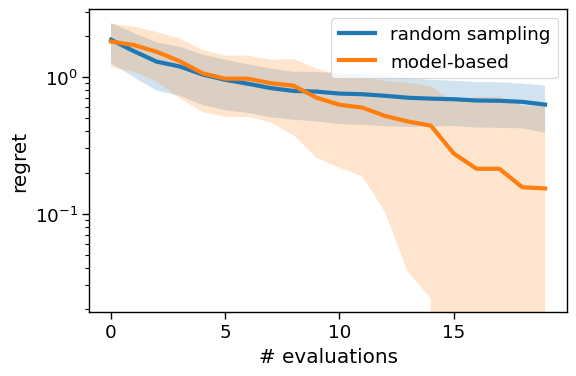

In [66]:
plt.figure(figsize=(6,4))
plt.plot(np.mean(regret_rand,axis=0), lw=3,label='random sampling')
plt.fill_between(
  np.arange(20),
  np.mean(regret_rand,axis=0)-np.std(regret_rand,axis=0),
  np.mean(regret_rand,axis=0)+np.std(regret_rand,axis=0),
  alpha=0.2
)
plt.plot(np.mean(regret_bo,axis=0), lw=3, label='model-based')
plt.fill_between(
  np.arange(20),
  np.mean(regret_bo,axis=0)-np.std(regret_bo,axis=0),
  np.mean(regret_bo,axis=0)+np.std(regret_bo,axis=0),
  alpha=0.2
)
plt.yscale('log')
plt.ylabel('regret')
plt.xlabel('# evaluations')
plt.legend()
plt.tight_layout()
# plt.savefig('synthetic_general_conditions_gradient.png', dpi=300)

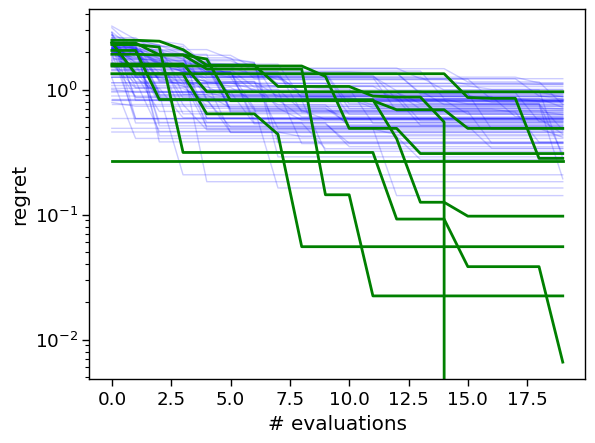

In [67]:
fig, ax = plt.subplots()

for r in regret_rand:
    ax.plot(r, lw=1, c='b', alpha=0.2)

for r in regret_bo:
    ax.plot(r, lw=2, c='g')

ax.set_yscale('log')
ax.set_ylabel('regret')
ax.set_xlabel('# evaluations')

plt.show()